# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import os
import pandas as pd
from typing import Dict
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-12-04 13:19:18,795 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_simulated_weekly.csv"
)

dt_prophet_holidays = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_prophet_holidays.csv"
)

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

Python window calculation (start):
window_start: 2016-01-01 00:00:00
closest_start_date: 2016-01-04 00:00:00
closest_start_idx: 6
days_diff first few values: [-39. -32. -25. -18. -11.]
Python window calculation (end):
window_end: 2018-12-31 00:00:00
closest_end_date: 2018-12-31 00:00:00
closest_end_idx: 162
days_diff first few values: [-1134. -1127. -1120. -1113. -1106.]
Window length: 157


DATE       revenue          tv_S     ooh_S       print_S  \
0 2015-11-23  2.754372e+06  22358.346667       0.0  12728.488889   
1 2015-11-30  2.584277e+06  28613.453333       0.0      0.000000   
2 2015-12-07  2.547387e+06      0.000000  132278.4    453.866667   
3 2015-12-14  2.875220e+06  83450.306667       0.0  17680.000000   
4 2015-12-21  2.215953e+06      0.000000  277336.0      0.000000   

     facebook_I  search_clicks_P     search_S  competitor_sales_B  \
0  2.430128e+07         0.000000     0.000000             8125009   
1  5.527033e+06      9837.238486  4133.333333             7901549   
2  1.665159e+07     12044.119653  3786.666667             8300197   
3  1.054977e+07     12268.070319  4253.333333             8122883   
4  2.934090e+06      9467.248023  3613.333333             7105985   

    facebook_S events    newsletter  
0  7607.132915     na  19401.653846  
1  1141.952450     na  14791.000000  
2  4256.375378     na  14544.000000  
3  2800.490677     na   2800.000000  
4   689.582605     na  15478.000000

## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    hyperparameters={
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-12-04 13:19:20,652 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-12-04 13:19:20,653 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-12-04 13:19:20,653 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/data/entities/mmmdata.py:255: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = ~selected_columns.applymap(
/Users/yijuilee/robynpy_release_reviews/robynvenv_py3.10/lib/python3.10/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
202

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt

%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(
    mmm_data, hyperparameters, featurized_mmmdata=featurized_mmm_data
)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result.get("channel")
    print(f"Processing channel: {channel}")  # Debugging line
    if not channel:
        print(f"Skipping invalid channel: {result}")
        continue

    try:
        fig = feature_plotter.plot_spend_exposure(channel)
        plt.show()
    except ValueError as e:
        print(f"Error plotting {channel}: {str(e)}")

2024-12-04 13:19:21,393 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-12-04 13:19:21,393 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-12-04 13:19:21,394 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-12-04 13:19:21,394 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-12-04 13:19:21,394 - robyn.visualization.feature_visualization - INFO - Found result for channel facebook_I
2024-12-04 13:19:21,508 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I
2024-12-04 13:19:21,508 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-12-04 13:19:21,508 - robyn.visualization.feature_visualization - INFO - Found result for channel search_clicks_P


Processing channel: facebook_I
Processing channel: search_clicks_P


2024-12-04 13:19:21,703 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P


In [9]:
print(featurized_mmm_data.modNLS["plots"].keys())

for result in featurized_mmm_data.modNLS["results"]:
    print(result.get("channel"))

dict_keys(['facebook_I', 'search_clicks_P'])
facebook_I
search_clicks_P


In [10]:
plot_data = featurized_mmm_data.modNLS["plots"].get("facebook_I")
print(plot_data)

           spend      exposure          yhat
6    3623.012233  1.371590e+07  1.404919e+07
7    4129.816153  1.885156e+07  1.595491e+07
8    3623.012233  1.191019e+07  1.404919e+07
9    3002.690585  1.062042e+07  1.169716e+07
10      0.000000  0.000000e+00  0.000000e+00
..           ...           ...           ...
158     0.000000  0.000000e+00  0.000000e+00
159     0.000000  0.000000e+00  0.000000e+00
160     0.000000  0.000000e+00  0.000000e+00
161  9068.007406  3.220052e+07  3.380801e+07
162     0.000000  0.000000e+00  0.000000e+00

[157 rows x 3 columns]


In [11]:
import numpy as np


# For MMM Data
def debug_mmm_data(mmm_data):
    print("=== MMM Data Debug ===")
    print("\nMMM Data Specification:")
    print(f"Dependent Variable: {mmm_data.mmmdata_spec.dep_var}")
    print(f"Paid Media Spends: {mmm_data.mmmdata_spec.paid_media_spends}")
    print(f"Paid Media Vars: {mmm_data.mmmdata_spec.paid_media_vars}")
    print(f"Organic Vars: {mmm_data.mmmdata_spec.organic_vars}")


# For Hyperparameters
def debug_hyperparameters(hyperparameters):
    print("=== Hyperparameters Debug ===")
    print("\nHyperparameters structure:")
    for channel, params in hyperparameters.hyperparameters.items():
        print(f"\nChannel: {channel}")
        print("Thetas:", getattr(params, "thetas", None))
        print("Alphas:", getattr(params, "alphas", None))
        print("Gammas:", getattr(params, "gammas", None))
        print("Shapes:", getattr(params, "shapes", None))
        print("Scales:", getattr(params, "scales", None))

    print("\nLambda:", hyperparameters.lambda_)
    print("Train size:", hyperparameters.train_size)


# For Featurized MMM Data
def debug_featurized_data(featurized_mmm_data):
    print("=== Featurized MMM Data Debug ===")
    print("\nFeaturized data shape:", featurized_mmm_data.dt_mod.shape)
    print("\nFeaturized data columns:", featurized_mmm_data.dt_mod.columns.tolist())

    # Basic statistics of the featurized data
    print("\nFeaturized data statistics:")
    print(featurized_mmm_data.dt_mod.describe())

    # Check for any transformations that occurred
    print("\nData types:")
    print(featurized_mmm_data.dt_mod.dtypes)

    # Check for any missing or infinite values
    print("\nMissing values count:")
    print(featurized_mmm_data.dt_mod.isnull().sum())
    print("\nInfinite values count:")
    print(np.isinf(featurized_mmm_data.dt_mod.select_dtypes(include=np.number)).sum())


# Combined debug function
def debug_all_inputs(mmm_data, hyperparameters, featurized_mmm_data):
    debug_mmm_data(mmm_data)
    print("\n" + "=" * 50 + "\n")
    debug_hyperparameters(hyperparameters)
    print("\n" + "=" * 50 + "\n")
    debug_featurized_data(featurized_mmm_data)


# Usage:
debug_all_inputs(mmm_data, hyperparameters, featurized_mmm_data)

=== MMM Data Debug ===

MMM Data Specification:
Dependent Variable: revenue
Paid Media Spends: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
Paid Media Vars: ['tv_S', 'ooh_S', 'print_S', 'facebook_I', 'search_clicks_P']
Organic Vars: ['newsletter']


=== Hyperparameters Debug ===

Hyperparameters structure:

Channel: facebook_S
Thetas: [0, 0.3]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Channel: print_S
Thetas: [0.1, 0.4]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Channel: tv_S
Thetas: [0.3, 0.8]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Channel: search_S
Thetas: [0, 0.3]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Channel: ooh_S
Thetas: [0.1, 0.4]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Channel: newsletter
Thetas: [0.1, 0.4]
Alphas: [0.5, 3]
Gammas: [0.3, 1]
Shapes: None
Scales: None

Lambda: [0, 1]
Train size: [0.5, 0.8]


=== Featurized MMM Data Debug ===

Featurized data shape: (20

In [12]:
print(mmm_data.mmmdata_spec.rolling_window_start_which)
print(mmm_data.mmmdata_spec.rolling_window_end_which)

6
162


2024-12-04 13:19:21,742 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-12-04 13:19:21,743 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-12-04 13:19:21,744 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-12-04 13:19:21,744 - robyn.common.common_util - WARNING - Requested cores (16) exceeds available cores (10). Will use 10 cores.
2024-12-04 13:19:21,744 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-12-04 13:19:21,745 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-12-04 13:19:21,745 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-12-04 13:19:21,745 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-12-04 13:19:21,746 - robyn.modeling.ridge.ridge_data_builder - INFO - Collecting hyperparameters for opt

>>> Starting 5 trials with 2000 iterations each using TwoPointsDE nevergrad algorithm on x cores...


Running trial 1 of total 5 trials:   0%|                                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6921455493357966, train_idx: 108
val_test_size: 24
After train split - X_train: (108, 11), y_train: (108,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 666721973.1881782
lambda_max (after 0.1 factor): 66672197.318817824
lambda_min: 6667.2197318817825
lambda_hp: 0.556948336053984
log_lambda: 13.934641964872279
final lambda: 1126517.9408019623

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7700406527393895, train_idx: 120
val_test_size: 18
After train split - X_train: (120, 11), y_train: (120,)



Running trial 1 of total 5 trials:   0%|                                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6625441849213707, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7583401978194102, train_idx: 119
val_test_size: 19
After train split - X_train: (119, 11), y_train: (119,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7518846920643882, train_idx: 118
val_test_size: 19
After train split - X_train: (118, 11), y_train: (118,)

ridge_data_builder

Running trial 1 of total 5 trials:   0%|▏                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7776339768037275, train_idx: 122
val_test_size: 17
After train split - X_train: (122, 11), y_train: (122,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7745302366300146, train_idx: 121
val_test_size: 18
After train split - X_train: (121, 11), y_train: (121,)


Running trial 1 of total 5 trials:   1%|▏                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6717100525583961, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7536346734839618, train_idx: 118
val_test_size: 19
After train split - X_train: (118, 11), y_train: (118,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)

Running trial 1 of total 5 trials:   1%|▏                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6501998775467843, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5328641718669298, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 1 of total 5 trials:   1%|▎                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6722173984990039, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6746376311842156, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5598745227314039, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)


Running trial 1 of total 5 trials:   1%|▎                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6665327174808691, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6546801220616463, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)


Running trial 1 of total 5 trials:   1%|▍                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5630170597943422, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 1 of total 5 trials:   1%|▍                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7872562020790592, train_idx: 123
val_test_size: 17
After train split - X_train: (123, 11), y_train: (123,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5449475840570033, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7560562481322395, train_idx: 118
val_test_size: 19
After train split - X_train: (118, 11), y_train: (118,)

ridge_data_builder pr

Running trial 1 of total 5 trials:   1%|▍                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7051402739011154, train_idx: 110
val_test_size: 23
After train split - X_train: (110, 11), y_train: (110,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7827520932339408, train_idx: 122
val_test_size: 17
After train split - X_train: (122, 11), y_train: (122,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6812198358251182, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder

Running trial 1 of total 5 trials:   2%|▌                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6151471936885031, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6612373857541614, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 1 of total 5 trials:   2%|▌                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5632133875267565, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6233342723160138, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 1 of total 5 trials:   2%|▋                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6625441849213707, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7583401978194102, train_idx: 119
val_test_size: 19
After train split - X_train: (119, 11), y_train: (119,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6229704775336428, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder pr

Running trial 1 of total 5 trials:   2%|▋                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7745302366300146, train_idx: 121
val_test_size: 18
After train split - X_train: (121, 11), y_train: (121,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6717100525583961, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 1 of total 5 trials:   2%|▋                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5456708340950247, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.73858467187137, train_idx: 115
val_test_size: 21
After train split - X_train: (115, 11), y_train: (115,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6501998775467843, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)


Running trial 1 of total 5 trials:   2%|▊                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5328641718669299, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7119343144614936, train_idx: 111
val_test_size: 23
After train split - X_train: (111, 11), y_train: (111,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 1 of total 5 trials:   2%|▊                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5110356939253887, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6746376311842156, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5570930739891133, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepa

Running trial 1 of total 5 trials:   3%|▉                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6665327174808691, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5501603592048953, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 603311097.6837705
lambda_max (after 0.1 factor): 60331109.76837706
lambda_min: 6033.110976837706
lambda_hp: 0.20096605937694173
log_lambda: 10.555983883315282
final lambda: 38406.5725204055

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 1 of total 5 trials:   3%|▉                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5987293863638388, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.581220316279121, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5308843438989794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:   3%|▉                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7051402739011154, train_idx: 110
val_test_size: 23
After train split - X_train: (110, 11), y_train: (110,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6432755074628043, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6812198358251182, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder

Running trial 1 of total 5 trials:   3%|█                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 1 of total 5 trials:   3%|█                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6921455493357966, train_idx: 108
val_test_size: 24
After train split - X_train: (108, 11), y_train: (108,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5215258293811983, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5632133875267565, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepa

Running trial 1 of total 5 trials:   3%|█▏                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.621557955657289, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6229704775336428, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6490087776808229, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepar

Running trial 1 of total 5 trials:   4%|█▎                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5542291768132946, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6465662528500287, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6718276551022786, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder pr

Running trial 1 of total 5 trials:   4%|█▍                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5250697366707743, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5775752815639537, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:   4%|█▌                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5198756087851643, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5449475840570033, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:   4%|█▌                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6812198358251182, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5105567051044618, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5952548288137888, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepa

Running trial 1 of total 5 trials:   5%|█▋                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5632133875267565, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5902060162894991, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:   5%|█▋                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6490087776808229, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7776339768037275, train_idx: 122
val_test_size: 17
After train split - X_train: (122, 11), y_train: (122,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)

Running trial 1 of total 5 trials:   5%|█▊                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.73858467187137, train_idx: 115
val_test_size: 21
After train split - X_train: (115, 11), y_train: (115,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.579507182106111, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:   6%|█▉                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5775752815639537, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5928630834428996, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6657633774263122, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepa

Running trial 1 of total 5 trials:   6%|██                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5646822030271925, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5090558503545907, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:   6%|██▏                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5737079293327607, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5904840303607705, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5215258293811983, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:   6%|██▎                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5256299767274333, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473209766796301, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:   7%|██▎                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50717388049044, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5456708340950248, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 1 of total 5 trials:   7%|██▍                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7172250146898577, train_idx: 112
val_test_size: 22
After train split - X_train: (112, 11), y_train: (112,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032532224035632, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 1 of total 5 trials:   7%|██▌                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5501603592048953, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6940730263145068, train_idx: 108
val_test_size: 24
After train split - X_train: (108, 11), y_train: (108,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5198756087851643, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepa

Running trial 1 of total 5 trials:   8%|██▋                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6432755074628043, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6812198358251182, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)

Running trial 1 of total 5 trials:   8%|██▋                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5095593191595966, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5902060162894991, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:   8%|██▊                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5384783679431118, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6029154107900488, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:   8%|██▉                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5456708340950248, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5232096640365866, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6312262069468213, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:   9%|██▉                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032532224035632, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5775752815639537, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5612789309646927, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:   9%|███                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5198756087851643, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5449475840570033, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5126570866256915, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:   9%|███▏                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5068367524804689, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5737079293327607, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5904840303607705, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:   9%|███▎                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6625441849213707, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5256299767274333, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 1 of total 5 trials:  10%|███▎                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5568668936838237, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5284030286680292, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5956386519723009, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  10%|███▍                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037268389798457, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5015869123756438, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032532224035632, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  10%|███▌                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5166573372285178, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.6696407653309927
log_lambda: 14.896790665132972
final lambda: 2948451.4701836333

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5987293863638388, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_

Running trial 1 of total 5 trials:  10%|███▋                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5314667255326928, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556441147264236, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5056927086523464, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  11%|███▋                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5215258293811983, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5323439834093268, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  11%|███▊                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.638731062591208, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.507064775688815, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6191959344098226, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare

Running trial 1 of total 5 trials:  11%|███▉                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5284030286680292, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5242127985516734, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409727080385339, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  12%|████                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457160415749931, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5068889795126621, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  12%|████                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5987293863638388, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5096269423080849, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5449475840570033, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  12%|████▏                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556441147264236, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6370940401478391, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5068367524804689, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepar

Running trial 1 of total 5 trials:  12%|████▎                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5215258293811983, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5632133875267565, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.551625278115382, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  12%|████▎                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.507064775688815, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5912976278859364, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5060237674434637, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  13%|████▍                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5242127985516735, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5232096640365866, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  13%|████▌                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5879750089196136, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5577415197787663, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 1 of total 5 trials:  13%|████▌                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.604506676017071, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6361562748732562, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5078856343675807, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  13%|████▋                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5677236681290906, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556441147264236, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  14%|████▊                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5210500933606167, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5904840303607705, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546254495501327, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  14%|████▉                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.632297810611886, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5950929869013722, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  14%|████▉                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5284030286680292, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5617467390423071, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  14%|█████                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5272047013104889, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032532224035632, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6631028557824129, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepa

Running trial 1 of total 5 trials:  15%|█████▏                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5987293863638388, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470783062730058, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  15%|█████▎                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556441147264236, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5056927086523464, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5068367524804689, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  15%|█████▎                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5632133875267565, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.551625278115382, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  16%|█████▍                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5835360187714741, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6029154107900488, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5568668936838237, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  16%|█████▌                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5232096640365866, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.579507182106111, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6745702926701762, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepar

Running trial 1 of total 5 trials:  16%|█████▌                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5172478318363068, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450084371066704, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  16%|█████▋                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5680414075851395, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5783395340703773, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5126570866256915, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  17%|█████▊                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541505643621846, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5737079293327607, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  17%|█████▉                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.551625278115382, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6625441849213707, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.632297810611886, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare

Running trial 1 of total 5 trials:  17%|█████▉                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5605519336570851, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546242646114948, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5242127985516735, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  17%|██████                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037268389798457, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5272047013104889, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032532224035632, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  18%|██████▏                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450084371066705, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5668558847617847, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 601288032.3783445
lambda_max (after 0.1 factor): 60128803.23783445
lambda_min: 6012.880323783445
lambda_hp: 0.8616039852542623
log_lambda: 16.637325137971292
final lambda: 16807321.247237574

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 1 of total 5 trials:  18%|██████▏                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5825965887524447, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5783395340703773, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5655064667342441, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  18%|██████▎                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262719776366931, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5737079293327607, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  18%|██████▎                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5398246089526147, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.551625278115382, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5657687879899512, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  18%|██████▍                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5233784761134984, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5912976278859364, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 1 of total 5 trials:  19%|██████▌                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6098914989660861, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5568668936838237, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546242646114948, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  19%|██████▌                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5252711387184771, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5291585550808957, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  19%|██████▋                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450084371066705, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5075347194352003, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5987293863638388, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  20%|██████▊                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091624609495504, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431678642164586, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  20%|██████▉                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5848888981208342, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5632133875267565, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288927868523458, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  20%|██████▉                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6257844990485627, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6098914989660861, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  20%|███████                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.516229518633484, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5322355368385092, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  21%|███████▏                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419816821527842, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5172478318363068, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  21%|███████▎                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5102706695526507, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5081188529916448, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  21%|███████▍                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5327952661081503, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5172632517988153, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  21%|███████▌                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.567043128357441, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491310948726281, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  22%|███████▌                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440544428893207, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5208374849795662, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  22%|███████▋                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5291585550808957, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032532224035632, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419816821527842, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  22%|███████▊                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5668558847617847, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5271084463978778, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.594014561788162, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  22%|███████▊                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5317427333025376, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091624609495504, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431678642164586, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  23%|███████▉                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5172632517988153, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.07759802979276995
log_lambda: 9.443875556070061
final lambda: 12630.57266634583

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5848888981208342, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_d

Running trial 1 of total 5 trials:  23%|████████                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5517234096520686, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175658964480875, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  23%|████████▏                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6087353364455325, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5558621701595529, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5902921142552686, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  24%|████████▏                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032532224035632, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419816821527842, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  24%|████████▎                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5076491731518291, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5074910337410781, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  24%|████████▍                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5147080157568387, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5769933997453713, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072792282211929, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  24%|████████▌                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.552894695584459, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288927868523458, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  24%|████████▌                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5302209286063161, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5246501902126225, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410184109502659, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  25%|████████▋                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5232096640365866, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5322355368385092, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  25%|████████▊                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419816821527842, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086262896422226, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  25%|████████▊                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387232615760588, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300492382714297, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5121615423510051, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  26%|████████▉                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5317160493683476, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072792282211929, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  26%|█████████                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5676279798034501, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520588875149004, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5313520113056016, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  26%|█████████▏                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468170449417274, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.560381222435807, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  27%|█████████▎                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5160759042347695, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386568008445759, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419816821527842, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  27%|█████████▎                         

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477653601779573, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5176389403643253, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300492382714297, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_tra

Running trial 1 of total 5 trials:  27%|█████████▍                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5384171861082536, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5674926691674489, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5694690674895885, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  27%|█████████▌                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229800461044589, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5115508402577049, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.552894695584459, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  27%|█████████▌                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5945493420175895, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5361116765364312, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  28%|█████████▋                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.560381222435807, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5232096640365866, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5322355368385092, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  28%|█████████▊                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5663018548816207, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511217300842144, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  28%|█████████▉                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300492382714297, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5500952915670664, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  29%|██████████                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5317160493683476, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430611046750798, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229800461044589, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  29%|██████████▏                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.525592251634881, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5240061647782136, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  29%|██████████▏                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.55305869635837, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468170449417274, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5500824008510248, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_da

Running trial 1 of total 5 trials:  29%|██████████▎                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5543663949828788, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.522362320383643, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  30%|██████████▍                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5279555735659196, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.548445964622039, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5920044774167702, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  30%|██████████▍                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.548681319728001, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5314538281724775, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091624609495504, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  30%|██████████▌                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386519307773255, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229800461044589, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 615633245.5838062
lambda_max (after 0.1 factor): 61563324.55838062
lambda_min: 6156.332455838062
lambda_hp: 0.8107854792251998
log_lambda: 16.192846730992333
final lambda: 10776158.773891553

ridge_d

Running trial 1 of total 5 trials:  30%|██████████▋                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5315610127397189, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5517234096520686, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175658964480875, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  31%|██████████▊                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468170449417274, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.560381222435807, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5191393647043788, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  31%|██████████▊                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5543663949828788, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5202016852727666, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5441212609535768, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  31%|██████████▉                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5659783196779976, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5508221896550402, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387232615760588, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  32%|███████████                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349939347414087, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091624609495504, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431678642164586, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  32%|███████████▏                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5569207632422079, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320260680476058, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  32%|███████████▏                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175658964480875, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475076954548291, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5820005001488695, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  32%|███████████▎                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5299661007940759, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5191393647043788, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5746216160812133, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  33%|███████████▍                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.557295734827877, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511217300842144, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  33%|███████████▍                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5504871529677469, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300492382714297, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  33%|███████████▌                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431678642164586, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5317160493683476, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430611046750798, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  33%|███████████▋                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5600784874707284, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5813510274231791, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5095571913831083, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  34%|███████████▊                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475076954548291, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5820005001488695, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5110126433095686, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  34%|███████████▊                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5191393647043788, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5595622183281294, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.562225470901864, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  34%|███████████▉                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311632910572347, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511217300842144, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5506669331447946, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  34%|███████████▉                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387232615760588, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399184291105465, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  34%|████████████                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5443021995657075, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431678642164586, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5317160493683476, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  35%|████████████▏                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5575950108583303, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320260680476058, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5613140257241133, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  35%|████████████▏                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5510874495137824, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5525611398084735, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  35%|████████████▎                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.560381222435807, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024911062272812, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5592309036039594, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  36%|████████████▍                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5441212609535769, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348459584340043, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  36%|████████████▌                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387232615760588, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300492382714297, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5537853656726196, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  36%|████████████▌                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5821672292711736, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5487779779537922, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5209971117743665, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  36%|████████████▋                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464805604865066, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5095571913831083, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  37%|████████████▊                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5820005001488695, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5635217967735623, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  37%|████████████▉                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5595622183281294, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5073669064081325, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  37%|████████████▉                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086977671779369, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5537031804519827, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.548445964622039, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  37%|█████████████                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5136556007607725, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.560770763500848, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5718928399345448, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  38%|█████████████▏                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.532079794472878, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5541488315287822, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5474165789806799, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
la

Running trial 1 of total 5 trials:  38%|█████████████▏                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5581573527973162, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464805604865066, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5804220669070278, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  38%|█████████████▎                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5709996361961228, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5635217967735623, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  38%|█████████████▍                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5595622183281294, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5073669064081325, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542910572869583, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  39%|█████████████▍                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348459584340043, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5687606132189829, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  39%|█████████████▌                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300492382714297, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.572018007138154, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5217284190697417, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  39%|█████████████▋                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5487779779537924, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5541488315287822, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229800461044589, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  39%|█████████████▊                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5695008998492564, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247574220097583, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  40%|█████████████▊                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5635217967735623, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468170449417274, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  40%|█████████████▉                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5073669064081325, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542910572869583, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54595790710631, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_dat

Running trial 1 of total 5 trials:  40%|██████████████                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5670483726820933, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 598933090.8259026
lambda_max (after 0.1 factor): 59893309.08259026
lambda_min: 5989.330908259026
lambda_hp: 0.42663157810417185
log_lambda: 12.627157031183925
final lambda: 304722.5688100078

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5258454513821168, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_d

Running trial 1 of total 5 trials:  40%|██████████████                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5559560892246432, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463529141722685, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5297092589371135, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  41%|██████████████▏                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5541488315287822, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229800461044589, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5569207632422079, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  41%|██████████████▎                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5695008998492564, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5784327198417761, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5580401845438518, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  41%|██████████████▍                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5347009130781445, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5584101118317879, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5363734187671126, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  41%|██████████████▍                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5280314060805362, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5524475740188445, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  42%|██████████████▌                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5336843782830794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54159013332265, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 1 of total 5 trials:  42%|██████████████▋                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.55223312719604, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5369400246433814, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544855485149725, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_dat

Running trial 1 of total 5 trials:  42%|██████████████▊                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5500076591944779, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5569207632422079, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5455715499681992, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  42%|██████████████▊                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5580401845438518, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5510874495137824, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5652751893617489, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  43%|██████████████▉                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442077311400122, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5599698748649816, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  43%|███████████████                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5524475740188445, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5582294422079785, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348459584340043, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  43%|███████████████▏                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422504806409792, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300492382714297, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  44%|███████████████▎                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5487779779537924, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5559729588372714, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  44%|███████████████▍                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546016715418246, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5499088175605018, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5574150931805965, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  44%|███████████████▍                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.558410111831788, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5291911825536363, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  44%|███████████████▌                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542088040221942, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5524475740188445, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5289079912042597, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  45%|███████████████▋                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5532523731799265, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54159013332265, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.539551807438212, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_dat

Running trial 1 of total 5 trials:  45%|███████████████▋                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5666747633477166, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5608144663238739, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.551478462381189, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  45%|███████████████▊                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5541488315287822, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5500076591944779, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 603311097.6837684
lambda_max (after 0.1 factor): 60331109.76837684
lambda_min: 6033.110976837685
lambda_hp: 0.5716644124521035
log_lambda: 13.970241890468522
final lambda: 1167344.2915031197

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 1 of total 5 trials:  45%|███████████████▉                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5696413218284084, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5595859336048671, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5499088175605018, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  46%|███████████████▉                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410306809510467, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.558410111831788, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  46%|████████████████                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492894139232702, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5523939996817057, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5524475740188445, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  46%|████████████████▏                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5532523731799265, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466441288436644, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  46%|████████████████▎                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463529141722686, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5323349824763433, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544855485149725, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  47%|████████████████▎                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5503679206994604, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526497062100054, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  47%|████████████████▍                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466747298773159, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5342573026335662, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  47%|████████████████▌                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526856596007179, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5544387804164779, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  48%|████████████████▋                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5391632449856584, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5537031804519827, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5532523731799265, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:
l

Running trial 1 of total 5 trials:  48%|████████████████▋                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311984781618537, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5366880052261166, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457278228090131, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  48%|████████████████▊                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425327271452826, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5448559480219826, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  48%|████████████████▉                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461240396250671, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5695008998492564, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5499088175605018, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  49%|█████████████████                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300467380546795, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457872773897646, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492606928763667, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  49%|█████████████████                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492894139232702, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542088040221942, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5499210459423851, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  49%|█████████████████▏                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5532523731799265, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466441288436644, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  49%|█████████████████▎                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463529141722686, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5474426549126651, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5519221813960743, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  50%|█████████████████▍                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5504502390461256, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5444896083505745, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5455715499681992, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  50%|█████████████████▌                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5402024531029287, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466923617403701, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  50%|█████████████████▌                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437360950818272, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460521231662622, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  50%|█████████████████▋                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5321576136815619, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5220996242345547, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  51%|█████████████████▊                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5508614458537718, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463312792608993, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5535964691734173, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  51%|█████████████████▉                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425169056257662, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5487274704361973, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  51%|█████████████████▉                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5695008998492564, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5499088175605018, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  52%|██████████████████                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437032742849487, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.558410111831788, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5490862697740242, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  52%|██████████████████▏                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5551700773889384, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5524475740188445, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415257020053547, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  52%|██████████████████▎                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466441288436644, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5604921649690251, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  53%|██████████████████▍                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5447738796249229, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544855485149725, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425327271452826, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  53%|██████████████████▍                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5555415888001971, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5521282908480634, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5530947906421512, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  53%|██████████████████▌                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5536482359327787, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466923617403701, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  53%|██████████████████▋                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460233519972019, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513526595796139, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  54%|██████████████████▊                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526757124821952, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544336493948422, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  54%|██████████████████▉                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5535084614846081, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463529141722686, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5447738796249229, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  54%|██████████████████▉                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5518655657254085, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5509512956325383, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  54%|███████████████████                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5499088175605018, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397540051293908, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5536482359327787, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  55%|███████████████████▏               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5406774604066797, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437360950818272, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  55%|███████████████████▎               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5524475740188445, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415257020053547, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.548544215380813, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  55%|███████████████████▎               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466441288436644, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5508614458537718, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463312792608993, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  55%|███████████████████▍               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5447738796249229, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5459353743764886, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  56%|███████████████████▌               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513106947476043, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5462053466831795, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  56%|███████████████████▌               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5485605442537671, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5536482359327787, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5445445363050146, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  56%|███████████████████▋               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5449082004655998, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460233519972019, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  56%|███████████████████▊               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5453080040649791, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542230366991672, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  57%|███████████████████▉               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5418031040271162, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5533455033108122, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  57%|███████████████████▉               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425327271452826, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.537751321992279, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5518655657254085, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  57%|████████████████████               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5530947906421512, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420062873097418, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  58%|████████████████████▏              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437032742849487, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.558410111831788, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 604025951.4935808
lambda_max (after 0.1 factor): 60402595.14935809
lambda_min: 6040.2595149358085
lambda_hp: 0.7613851713373896
log_lambda: 15.718818838247582
final lambda: 6708049.883035768

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final dat

Running trial 1 of total 5 trials:  58%|████████████████████▏              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460233519972019, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432046994444762, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542088040221942, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  58%|████████████████████▎              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5392890899192543, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5506210039452868, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470122114251675, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  58%|████████████████████▍              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5533455033108122, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5438720511985926, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  59%|████████████████████▌              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5383853265819792, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5518655657254085, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452839700898443, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  59%|████████████████████▋              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5485605442537671, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5417796732307664, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  59%|████████████████████▊              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437360950818272, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460233519972019, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  60%|████████████████████▊              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5549234535929807, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.550743131342981, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5506210039452868, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  60%|████████████████████▉              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5508614458537718, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463312792608993, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5533455033108122, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  60%|████████████████████▉              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5445461971590516, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451929873070885, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  60%|█████████████████████              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5472153587210752, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461240396250671, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  61%|█████████████████████▏             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5536482359327787, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421797095006599, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  61%|█████████████████████▎             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460233519972019, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432046994444762, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  61%|█████████████████████▍             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5528633879334487, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5506210039452868, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5541209374633501, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  61%|█████████████████████▌             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5485494736721613, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5438720511985927, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  62%|█████████████████████▌             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433936695484894, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5518655657254085, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5391996533226303, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  62%|█████████████████████▋             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5485605442537671, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5536482359327787, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  62%|█████████████████████▊             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.558410111831788, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5447273081666433, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437360950818272, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  62%|█████████████████████▉             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493254006084458, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5519171876907186, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  63%|█████████████████████▉             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379191439730823, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5508614458537718, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  63%|██████████████████████             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5462776045303844, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437732451118388, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  63%|██████████████████████▏            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452839700898443, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442896682319683, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461240396250671, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  64%|██████████████████████▏            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540844588855158, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421797095006599, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  64%|██████████████████████▎            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437360950818272, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460233519972019, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5447942175189057, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  64%|██████████████████████▍            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5519171876907186, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.548544215380813, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5441257735862658, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  64%|██████████████████████▌            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5500018658837132, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471466288621787, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469117303022959, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  65%|██████████████████████▌            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437365995874253, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5445461971590516, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  65%|██████████████████████▋            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429790724587777, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461240396250671, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468461342003057, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  65%|██████████████████████▊            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5536482359327787, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421797095006599, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  65%|██████████████████████▊            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437360950818272, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460233519972019, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422027746591208, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  66%|██████████████████████▉            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484854282064908, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476475910527696, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.548544215380813, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  66%|███████████████████████            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.535523503165314, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471466288621787, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  66%|███████████████████████▏           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5411324440989734, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5459428874243238, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  66%|███████████████████████▏           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433147531065016, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5555388899121351, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  67%|███████████████████████▎           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5448843355343069, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.558410111831788, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5447273081666433, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  67%|███████████████████████▍           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451961207981939, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5519171876907186, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  67%|███████████████████████▌           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494947919006458, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436502958292854, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451895917961896, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  67%|███████████████████████▌           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454178056104518, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5447738796249229, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5408407386859191, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  68%|███████████████████████▋           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457382623782777, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442011742330374, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  68%|███████████████████████▊           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540545664155511, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544475593630127, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 1 of total 5 trials:  68%|███████████████████████▉           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460233519972019, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5499028992978215, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  69%|████████████████████████           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425442188017613, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544186094103683, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450495646624938, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  69%|████████████████████████▏          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452829329149799, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.53891726954438, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 1 of total 5 trials:  69%|████████████████████████▏          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5459428874243238, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5434306789779603, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5441955409330425, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  69%|████████████████████████▎          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468461342003058, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5458025456321892, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  70%|████████████████████████▍          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544884335534307, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470758026684703, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436155926656879, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  70%|████████████████████████▍          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5445733573654201, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5456666548688953, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5441958858311983, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  70%|████████████████████████▌          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450495646624938, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.9986064579125876
log_lambda: 17.906999981999146
final lambda: 59828936.03060879

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436502958292854, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_d

Running trial 1 of total 5 trials:  70%|████████████████████████▋          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5438720511985927, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461085192124246, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  71%|████████████████████████▊          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451825426710611, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457382623782777, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425006201752322, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  71%|████████████████████████▊          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5446170795955786, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5467614655345385, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  71%|████████████████████████▉          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470758026684703, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5446675531188595, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452281154182524, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  72%|█████████████████████████          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5462317101686608, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5488447032903819, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  72%|█████████████████████████▏         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.548177652212693, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466819425843873, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461578293290191, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  72%|█████████████████████████▏         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457757551772348, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461994521900662, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  72%|█████████████████████████▎         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425006201752322, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461240396250671, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470134223906202, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  73%|█████████████████████████▍         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5467614655345385, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544475593630127, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  73%|█████████████████████████▍         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475788176667287, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460233519972019, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432965434087996, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  73%|█████████████████████████▌         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5519171876907186, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468356930185299, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475627723396386, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  73%|█████████████████████████▋         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471466288621787, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5446054431266212, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468166715349254, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  74%|█████████████████████████▊         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461481392369177, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451825426710611, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  74%|█████████████████████████▊         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545957008264124, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469818595633121, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5446170795955786, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  74%|█████████████████████████▉         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470758026684703, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451876921697776, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  74%|██████████████████████████         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468245693041399, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464279773919121, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461862276907724, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  75%|██████████████████████████▏        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450495646624938, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5455223327275956, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464273177796825, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  75%|██████████████████████████▏        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468166715349255, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5444194487608737, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  75%|██████████████████████████▎        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451825426710611, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.006299424168135116
log_lambda: 8.767514447706683
final lambda: 6422.189920981747

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477222864548515, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_

Running trial 1 of total 5 trials:  75%|██████████████████████████▍        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461200708784908, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475609087746663, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5467614655345385, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  76%|██████████████████████████▍        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5453304561205824, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5462919406949378, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437360950818272, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  76%|██████████████████████████▌        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468245693041399, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460425271799874, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  76%|██████████████████████████▋        

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450495646624938, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5458856348217093, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471308768250841, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_tra

Running trial 1 of total 5 trials:  76%|██████████████████████████▊        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466050463977122, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5488130830654765, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457757551772348, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  77%|██████████████████████████▊        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470991388350868, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451825426710611, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477222864548515, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  77%|██████████████████████████▉        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5458188276927403, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5446170795955786, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  77%|███████████████████████████        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.547788963931742, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5447273081666433, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473076879030446, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  78%|███████████████████████████▏       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493021235871022, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471599123467263, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461862276907724, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  78%|███████████████████████████▏       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5486450234472108, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 603311097.6837684
lambda_max (after 0.1 factor): 60331109.76837684
lambda_min: 6033.110976837685
lambda_hp: 0.9986064579125876
log_lambda: 17.90252344826731
final lambda: 59561708.35343907

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436502958292854, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_dat

Running trial 1 of total 5 trials:  78%|███████████████████████████▎       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483235461498915, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461085192124248, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  78%|███████████████████████████▎       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461481392369177, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483357073644873, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477222864548515, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  78%|███████████████████████████▍       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470134223906203, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461200708784908, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5446170795955786, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  79%|███████████████████████████▌       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464676512740402, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5474458687633951, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  79%|███████████████████████████▋       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468245693041399, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468959464849238, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461862276907724, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  79%|███████████████████████████▋       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436502958292854, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471308768250841, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  79%|███████████████████████████▊       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5481881311321909, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457617841615726, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  80%|███████████████████████████▉       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477222864548515, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5441977909040329, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  80%|███████████████████████████▉       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450539147749491, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5478538866638577, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471614818674158, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  80%|████████████████████████████       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450099390119462, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437360950818272, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  80%|████████████████████████████▏      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5467360943254003, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491622816860601, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  81%|████████████████████████████▎      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5480414820150791, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.549718349670904, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476319805849396, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  81%|████████████████████████████▍      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5455487589953308, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469926459640168, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  81%|████████████████████████████▍      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425006201752322, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440290774385849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5480233359567722, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  82%|████████████████████████████▌      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466230486034065, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5472154702749366, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  82%|████████████████████████████▋      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477363736502071, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473919628912428, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  82%|████████████████████████████▊      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452842168472333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5472244746950902, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  82%|████████████████████████████▊      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546030948466797, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5459903419521733, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470912641843663, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  83%|████████████████████████████▉      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450680297758401, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.2936304213867595
log_lambda: 11.413930731509556
final lambda: 90574.74781657018

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477222864548515, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_d

Running trial 1 of total 5 trials:  83%|█████████████████████████████      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461200708784908, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451189464230259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466394344806188, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  83%|█████████████████████████████      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450099390119462, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437360950818272, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  84%|█████████████████████████████▏     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471599123467263, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477637807115975, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452842168472333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  84%|█████████████████████████████▎     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546361044800893, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476276284443691, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5465988380839962, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  84%|█████████████████████████████▍     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461994521900662, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5478166140822543, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  84%|█████████████████████████████▌     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5458898489048883, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471909444075045, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5489272253877964, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  85%|█████████████████████████████▋     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460636981967751, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5487895926174431, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54648458908544, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_da

Running trial 1 of total 5 trials:  85%|█████████████████████████████▊     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468245693041399, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471318125455236, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461862276907724, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  85%|█████████████████████████████▊     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5481822593671394, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466938322500264, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  86%|█████████████████████████████▉     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5482664397823737, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461994521900662, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  86%|██████████████████████████████     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461240396250671, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469530671242102, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  86%|██████████████████████████████▏    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466230486034065, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454401131171417, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5445684761640766, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  86%|██████████████████████████████▏    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473919628912428, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5462870717833773, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5501780716449147, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  87%|██████████████████████████████▍    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5503480790170263, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436502958292854, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  87%|██████████████████████████████▍    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477674865315092, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461994521900662, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  87%|██████████████████████████████▌    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5480652779971457, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471909444075045, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461200708784908, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  88%|██████████████████████████████▋    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5459985262833821, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.5423431594820214
log_lambda: 13.704659704213086
final lambda: 895072.2356406235

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450099390119462, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_d

Running trial 1 of total 5 trials:  88%|██████████████████████████████▊    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468245693041399, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452862930610157, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5462227759632099, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  88%|██████████████████████████████▉    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436502958292854, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.547799847099934, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials:  88%|██████████████████████████████▉    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5467807863111261, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457757551772348, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463342191467663, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  89%|███████████████████████████████    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5481917711489198, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425006201752322, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461240396250671, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  89%|███████████████████████████████▏   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5446170795955786, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466394344806188, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473179242121861, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  89%|███████████████████████████████▏   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468887338853149, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5458362385746766, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460233519972019, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  90%|███████████████████████████████▎   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471599123467263, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469380018382527, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452842168472333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  90%|███████████████████████████████▍   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436502958292854, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5474788793558644, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469589452193631, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  90%|███████████████████████████████▍   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461085192124248, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457757551772348, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473552113958939, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  90%|███████████████████████████████▌   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477222864548515, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473602052966433, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461240396250671, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  91%|███████████████████████████████▋   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466394344806188, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463864218039777, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  91%|███████████████████████████████▋   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469704257319203, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470821429413707, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  91%|███████████████████████████████▊   

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471599123467263, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545116082481159, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5449922754636612, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_trai

Running trial 1 of total 5 trials:  91%|███████████████████████████████▉   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436502958292854, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5474788793558644, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469589452193631, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  91%|████████████████████████████████   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461085192124248, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457757551772348, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  92%|████████████████████████████████   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461777977504072, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425006201752322, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  92%|████████████████████████████████▏  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5446170795955786, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466394344806188, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  92%|████████████████████████████████▎  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468887338853149, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466199077317906, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  92%|████████████████████████████████▍  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463480117365277, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5472717791682559, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  93%|████████████████████████████████▍  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464350048442179, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.9986064579125876
log_lambda: 17.906999981999146
final lambda: 59828936.03060879

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436502958292854, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 1 of total 5 trials:  93%|████████████████████████████████▌  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470912641843663, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461085192124248, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457757551772348, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  93%|████████████████████████████████▋  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450680297758401, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461777977504072, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463603802932285, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  93%|████████████████████████████████▋  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5446170795955786, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470376359218553, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  94%|████████████████████████████████▊  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5474791943937811, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468887338853149, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468364351749984, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  94%|████████████████████████████████▉  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5444707498747694, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5480650860513674, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450897751870278, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  94%|████████████████████████████████▉  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450495646624938, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.547436823252802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5478505541256756, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  94%|█████████████████████████████████  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470912641843663, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461085192124248, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457757551772348, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  95%|█████████████████████████████████  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469823833733871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5481248947020947, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5474605933942643, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  95%|█████████████████████████████████▏ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464244617544617, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5458822113907539, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  95%|█████████████████████████████████▎ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463864218039777, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546947346558011, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461317258825925, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
la

Running trial 1 of total 5 trials:  95%|█████████████████████████████████▎ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470821429413707, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5500388413182049, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  96%|█████████████████████████████████▍ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452842168472333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483170655315884, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  96%|█████████████████████████████████▌ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469589452193631, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469573209587781, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470912641843663, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  96%|█████████████████████████████████▋ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5455771721972975, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545290085708359, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450680297758401, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 1 of total 5 trials:  96%|█████████████████████████████████▋ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425006201752322, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476344905819335, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461362307849945, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  97%|█████████████████████████████████▊ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463864218039777, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454401131171417, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  97%|█████████████████████████████████▉ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470821429413707, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473919628912428, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  97%|██████████████████████████████████ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452842168472333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5472244746950902, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450495646624938, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  97%|██████████████████████████████████ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469776957425823, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469508239164383, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470912641843663, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  98%|██████████████████████████████████▏


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469823833733871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450680297758401, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.9880660354549355
log_lambda: 17.809919103499748
final lambda: 54293718.86305261

ridge_d

Running trial 1 of total 5 trials:  98%|██████████████████████████████████▎


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471909444075045, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469767697017017, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  98%|██████████████████████████████████▎

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463864218039777, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454401131171417, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464702814304226, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  98%|██████████████████████████████████▍


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473919628912428, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5459834822295878, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 1 of total 5 trials:  99%|██████████████████████████████████▌

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5472244746950902, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450495646624938, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483001381236497, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  99%|██████████████████████████████████▋

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451635726382612, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470912641843663, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5465580770756026, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  99%|██████████████████████████████████▋

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469823833733871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450680297758401, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5465777655523443, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials:  99%|██████████████████████████████████▊

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5482705296222234, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5443832511935518, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469603877185524, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials: 100%|██████████████████████████████████▊


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463864218039777, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546648681756579, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 1 of total 5 trials: 100%|██████████████████████████████████▉

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470451229705455, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471691841142777, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461395761767757, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-12-04 13:20:53,281 - robyn.modeling.ridge.ridge_evaluate_model - INFO -  Finished in 1.53 mins



ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545116082481159, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452842168472333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:   0%|                                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397181351058338, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 608790361.1824789
lambda_max (after 0.1 factor): 60879036.1182479
lambda_min: 6087.90361182479
lambda_hp: 0.5431327110915285
log_lambda: 13.716496203237295
final lambda: 905729.7064275787

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6298051161503676, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data

Running trial 2 of total 5 trials:   0%|                                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5735101485344579, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6377732704159437, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:   1%|▏                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6078457397706577, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7056245788362437, train_idx: 110
val_test_size: 23
After train split - X_train: (110, 11), y_train: (110,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:   1%|▎                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7484834498908516, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6110825337971909, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:   1%|▍                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.543954260915614, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6811739648875473, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 2 of total 5 trials:   1%|▍                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6224373696722445, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.653630518639613, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6033228961274655, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepar

Running trial 2 of total 5 trials:   1%|▍                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6563236129059392, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397760609753657, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)


Running trial 2 of total 5 trials:   2%|▌                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7533482260433402, train_idx: 118
val_test_size: 19
After train split - X_train: (118, 11), y_train: (118,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397181351058338, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:   2%|▋                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.554980969318731, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5766629702295722, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.547294200384889, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:   2%|▋                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5337346795630651, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.57628832449974, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6476770501498106, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare

Running trial 2 of total 5 trials:   2%|▊                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5840158013520752, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7286066961514249, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7509085080603242, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

ridge_data_builder pr

Running trial 2 of total 5 trials:   3%|▉                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5489318459489488, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6811739648875473, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.548878622428729, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:

Running trial 2 of total 5 trials:   3%|▉                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.653630518639613, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6693153596928456, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5355389856971242, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder pre

Running trial 2 of total 5 trials:   3%|█                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6139230394831603, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5119450787219676, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5782402244115679, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:   3%|█▏                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5380751706450978, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5735101485344579, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:   4%|█▏                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5337346795630651, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6333993050197965, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:   4%|█▎                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6567220208823701, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5840158013520752, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7286066961514249, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder pr

Running trial 2 of total 5 trials:   4%|█▍                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5260951594783235, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6811739648875473, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:   4%|█▌                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.648248124006805, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5669385914421883, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 2 of total 5 trials:   5%|█▌                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54861752150836, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5667052878791082, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 2 of total 5 trials:   5%|█▋                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5290951688664218, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5257287777086066, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5735101485344579, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:   5%|█▊                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5396620195617413, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5974827640701519, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6305573541391832, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:   5%|█▊                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6226827022086995, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5840158013520752, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6900328634730735, train_idx: 108
val_test_size: 24
After train split - X_train: (108, 11), y_train: (108,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:   6%|█▉                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5439542609156142, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5254190589464142, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:   6%|██                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6286874075276728, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:   6%|██                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54861752150836, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397760609753657, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 2 of total 5 trials:   6%|██▏                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6353886767752247, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.554980969318731, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:   7%|██▎                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5396620195617413, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5128447364718105, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:   7%|██▍                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5529111179257271, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5638069048249926, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:   7%|██▌                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454557216784346, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5439542609156142, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5830700230454043, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:   7%|██▌                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6286874075276728, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5590558890138544, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:   8%|██▋                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54861752150836, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397760609753657, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6639408318449442, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare

Running trial 2 of total 5 trials:   8%|██▋                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5059943304195775, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.503738425410982, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475548666556047, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:   8%|██▊                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5396620195617413, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5974827640701519, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.57628832449974, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:   8%|██▊                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6226827022086995, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5638069048249926, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:   8%|██▉                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5075770131002846, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5439542609156142, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:   9%|███                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6980343226836919, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.617604264542404, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder pre

Running trial 2 of total 5 trials:   9%|███                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340125181421708, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54861752150836, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 2 of total 5 trials:   9%|███▏                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5632749748163656, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5290951688664218, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  10%|███▎                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5268683010555658, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5396620195617413, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5641288611113567, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  10%|███▍                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6226827022086995, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5638069048249926, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  10%|███▌                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454557216784346, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5621109811821999, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  10%|███▌                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.617604264542404, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6604324849145842, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

ridge_data_builder pre

Running trial 2 of total 5 trials:  11%|███▋                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54861752150836, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5859414234511946, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6138796388685701, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  11%|███▊                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5290951688664218, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6542496101692888, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5240958862489656, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  11%|███▉                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6198849640528402, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5287932308762882, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  11%|███▉                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5053909242217098, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6328621133154176, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  11%|████                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454557216784346, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5439542609156142, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  12%|████                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6317068903293102, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  12%|████▏                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54861752150836, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397760609753657, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 2 of total 5 trials:  12%|████▎                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5290951688664218, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6542496101692888, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  12%|████▍                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5396620195617413, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6221488463271962, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  13%|████▍                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5990889586147632, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5601740318967641, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 2 of total 5 trials:  13%|████▍                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7286066961514249, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6351034165108829, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7001815538532379, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder pr

Running trial 2 of total 5 trials:  13%|████▌                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5130684933974254, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.564685138290996, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  13%|████▋                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6604324849145842, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5590558890138544, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  14%|████▊                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6138796388685701, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5766202714867203, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.531389061659123, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  14%|████▊                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6048985083333308, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5224909155238054, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5268683010555658, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  14%|████▉                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6003170445824649, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6788172428161738, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  14%|█████                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7286066961514249, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6351034165108829, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  15%|█████                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6448516074696163, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6546986936460708, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6980343226836919, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder

Running trial 2 of total 5 trials:  15%|█████▏                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7016515475941769, train_idx: 110
val_test_size: 23
After train split - X_train: (110, 11), y_train: (110,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.697823179141076, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6407291447721447, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder 

Running trial 2 of total 5 trials:  15%|█████▎                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6138796388685701, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6199548502264242, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 632944695.6371471
lambda_max (after 0.1 factor): 63294469.56371471
lambda_min: 6329.446956371472
lambda_hp: 0.707879845404207
log_lambda: 15.27278246129429
final lambda: 4294228.4635100085

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data

Running trial 2 of total 5 trials:  15%|█████▎                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6048985083333308, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6229681256026461, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5268683010555658, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  16%|█████▍                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.57628832449974, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6788172428161738, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138938020311733, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare

Running trial 2 of total 5 trials:  16%|█████▌                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7286066961514249, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526897601293945, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6707218320559682, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder pr

Running trial 2 of total 5 trials:  16%|█████▋                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5254190589464142, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5871481003769286, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  16%|█████▋                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6604324849145842, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5038600073338112, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  17%|█████▊                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5766202714867203, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5209821034939696, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  17%|█████▉                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6552247257231704, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5224909155238054, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.587398425832404, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepar

Running trial 2 of total 5 trials:  17%|██████                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5314181775635302, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6788172428161738, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138938020311733, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  17%|██████                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526897601293945, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5302871063280591, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  18%|██████▏                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.536189775573636, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 608790361.1824789
lambda_max (after 0.1 factor): 60879036.1182479
lambda_min: 6087.90361182479
lambda_hp: 0.4090783281458919
log_lambda: 12.481809707952742
final lambda: 263500.2795707993

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6980343226836919, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_da

Running trial 2 of total 5 trials:  18%|██████▎                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6601414631548593, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5539642517897008, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  18%|██████▎                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545503476454217, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5504874630298354, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5632749748163656, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  18%|██████▍                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5889213263566496, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5224909155238054, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.511188678938894, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  19%|██████▌                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5782552406558702, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6041145148424942, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6788172428161738, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  19%|██████▌                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7286066961514249, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5864285991946815, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  19%|██████▋                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615773517113557, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.558061296951015, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  19%|██████▊                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5746592159854748, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5302163402204358, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  20%|██████▊                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6138796388685701, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450117777439084, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  20%|██████▉                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5889213263566496, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5636544549765512, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  20%|███████                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.57628832449974, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6788172428161738, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 672180806.8712615
lambda_max (after 0.1 factor): 67218080.68712614
lambda_min: 6721.808068712615
lambda_hp: 0.500925596114603
log_lambda: 13.426807696422326
final lambda: 677935.6808519032

ridge_da

Running trial 2 of total 5 trials:  20%|███████▏                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7370585163592629, train_idx: 115
val_test_size: 21
After train split - X_train: (115, 11), y_train: (115,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6209170470955849, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  21%|███████▏                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5004481919208865, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6317366066178676, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  21%|███████▎                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470085566754322, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5367332550965447, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5426136991382328, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  21%|███████▍                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6138796388685701, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5504874630298354, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430577396932285, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  21%|███████▍                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6048977571619043, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5763524611679894, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.560239956665229, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  22%|███████▌                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.57628832449974, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468784901881735, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138938020311733, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  22%|███████▋                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6425515224761051, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526897601293945, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  22%|███████▋                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6078019996327843, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.558061296951015, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  22%|███████▊                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470085566754322, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5590558890138544, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  23%|███████▉                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6226862941140062, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6204946156845531, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 632944695.6371471
lambda_max (after 0.1 factor): 63294469.56371471
lambda_min: 6329.446956371472
lambda_hp: 0.3644226920024204
log_lambda: 12.109425175273797
final lambda: 181575.20060406698

ridge_d

Running trial 2 of total 5 trials:  23%|███████▉                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5889213263566496, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5115638165803245, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  23%|████████                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.525761639681125, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.57628832449974, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6788172428161738, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  23%|████████▏                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5644667562130166, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5601740318967641, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7286066961514249, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  24%|████████▎                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5129446227552543, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476634254864041, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6401403357770805, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  24%|████████▎                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5106472672869488, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  24%|████████▍                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5396699653539627, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5223609780750447, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  24%|████████▍                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108675711928206, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5055217711604236, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  24%|████████▌                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5226745812073837, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432550301878382, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  25%|████████▋                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6607534757027146, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7286066961514249, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)

Running trial 2 of total 5 trials:  25%|████████▋                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5129446227552543, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5107112947502119, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 2 of total 5 trials:  25%|████████▊                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5004481919208865, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5063811185191744, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622168572.1123414
lambda_max (after 0.1 factor): 62216857.211234145
lambda_min: 6221.685721123415
lambda_hp: 0.6259805163555
log_lambda: 14.501289787132295
final lambda: 1985318.2508418167

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data

Running trial 2 of total 5 trials:  25%|████████▊                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5104329832586998, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5287992529955872, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5216794208315221, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  26%|████████▉                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5054018536712912, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5223609780750447, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  26%|█████████                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5255895393970812, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430577396932285, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108675711928206, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  26%|█████████                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5224909155238054, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5280302524226261, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5063106717744204, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  26%|█████████▏                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.531261315769165, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5243585266472327, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138938020311733, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  26%|█████████▎                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7286066961514249, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526897601293945, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5302871063280591, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  27%|█████████▎                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5004481919208865, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5063811185191744, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  27%|█████████▍                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5216794208315221, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5578733425891397, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  27%|█████████▍                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6138796388685701, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7111406627043118, train_idx: 111
val_test_size: 23
After train split - X_train: (111, 11), y_train: (111,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  27%|█████████▌                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266533861879077, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5181428188080391, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  28%|█████████▋                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340073506763502, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5363155607008026, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  28%|█████████▋                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5374330763153633, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5137616976097816, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5517936692428294, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  28%|█████████▊                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5302871063280591, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5129446227552543, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  28%|█████████▊                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5395545580865221, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5951174095468026, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5716063347045949, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  28%|█████████▉                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6589765451248617, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5539642517897008, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5054018536712912, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  29%|██████████                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5255895393970812, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430577396932285, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108675711928206, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  29%|██████████▏                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6001187707137517, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6229890928122158, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135189921965069, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  29%|██████████▏                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5243585266472327, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138938020311733, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468199789589121, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  29%|██████████▎                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.614816930294419, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5066775308829556, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5577761176773854, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  30%|██████████▍                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5099236205706292, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091249342021424, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  30%|██████████▍                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.53666721941727, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088101753210984, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5954247438330387, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  30%|██████████▌                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5223609780750447, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6138796388685701, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6050217977443079, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

DEBUG lambda calculation:
l

Running trial 2 of total 5 trials:  30%|██████████▌                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025443841276496, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5889213263566496, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5525942940827034, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  31%|██████████▋                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135189921965069, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6123746997061803, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  31%|██████████▊                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5191055010692772, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5155852032466757, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  31%|██████████▉                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5129446227552543, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5099236205706292, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  31%|██████████▉                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5100611389159135, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5536785786013462, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5132500667516388, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  32%|███████████                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5655360326761399, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5223609780750447, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5211251374999362, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  32%|███████████                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108675711928206, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5353028658988689, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5889213263566496, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  32%|███████████▏                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5990866088156737, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042398637041565, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5151118226384681, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  32%|███████████▎                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5742541017346549, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.614816930294419, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  32%|███████████▎                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5197730593745272, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5158164305691266, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  33%|███████████▍                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091249342021424, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622168572.1123414
lambda_max (after 0.1 factor): 62216857.211234145
lambda_min: 6221.685721123415
lambda_hp: 0.8726519548051346
log_lambda: 16.773217695298403
final lambda: 19253774.84462371

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5997644558528397, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_d

Running trial 2 of total 5 trials:  33%|███████████▌                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5150418031103153, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072755780778084, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  33%|███████████▌                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5169254087032148, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430577396932285, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  33%|███████████▋                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5525942940827034, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.581904296524239, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  34%|███████████▊                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5338708402474776, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138938020311733, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  34%|███████████▉                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.614816930294419, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526897601293945, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  34%|███████████▉                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221585030603992, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091249342021424, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5395545580865221, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  34%|████████████                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6164796742762392, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5150418031103153, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072755780778084, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  35%|████████████▏                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5211251374999362, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6198355470914357, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5744899691729866, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  35%|████████████▏                      

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5353028658988689, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5889213263566496, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5525942940827034, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_tra

Running trial 2 of total 5 trials:  35%|████████████▎                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.53007643502688, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5363155607008027, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 2 of total 5 trials:  35%|████████████▎                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5243908260395744, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.614816930294419, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  36%|████████████▍                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221585030603992, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  36%|████████████▍                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5391804794483346, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6211637791338739, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5742062354507841, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  36%|████████████▌                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072755780778084, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5230740219316208, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5374140156146546, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  36%|████████████▋                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430577396932285, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108675711928206, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  36%|████████████▊                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5962343157077812, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135189921965069, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  37%|████████████▊                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6054635020819125, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5213171701654953, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  37%|████████████▉                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5038422771982578, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221429973824229, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5069535678072982, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  37%|█████████████                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5971034571603877, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5540527863685901, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  38%|█████████████▏                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072755780778084, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5113258476828857, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  38%|█████████████▏                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5040175598566681, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108675711928206, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  38%|█████████████▎                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5455713329939216, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135189921965069, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  38%|█████████████▍                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5003429585912595, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  38%|█████████████▍                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221429973824229, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5069535678072982, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  39%|█████████████▌                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6346063969152169, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.505983293483198, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5318798037102133, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  39%|█████████████▌                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5162289011023106, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072755780778084, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5113258476828857, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  39%|█████████████▋                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5211251374999362, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5729949563752449, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430577396932285, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  39%|█████████████▊                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5219530099246259, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5121952378964838, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6012196179391548, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  40%|█████████████▉                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013535383098753, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  40%|█████████████▉                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5251057139936617, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  40%|██████████████                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5074121211741903, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622168572.1123414
lambda_max (after 0.1 factor): 62216857.211234145
lambda_min: 6221.685721123415
lambda_hp: 0.8726519548051346
log_lambda: 16.773217695298403
final lambda: 19253774.84462371

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.505983293483198, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_da

Running trial 2 of total 5 trials:  40%|██████████████                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5171372744578803, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072755780778084, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  41%|██████████████▏                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5255895393970812, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5289425977921345, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  41%|██████████████▎                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5889213263566496, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.524390163996429, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024342995867083, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  41%|██████████████▍                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032575687909344, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013535383098753, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421396128173734, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  41%|██████████████▍                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088974574092584, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172032, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5949912296548605, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  42%|██████████████▌                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5134348455946218, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221585030603992, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091249342021424, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  42%|██████████████▋                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5046300350233253, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  42%|██████████████▋                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5272431342566442, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5211251374999362, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.607262714021314, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  42%|██████████████▊                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108675711928206, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5353028658988689, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5889213263566496, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  43%|██████████████▉                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5304479536188732, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131999499390063, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  43%|███████████████                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5039472502535166, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5066987253589088, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  43%|███████████████                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221585030603992, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091249342021424, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  43%|███████████████▏                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6004472959836584, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5046300350233253, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5217030674101211, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  44%|███████████████▎                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5079268185521, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5211251374999362, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5113588518011117, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_dat

Running trial 2 of total 5 trials:  44%|███████████████▎                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6484696772057406, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5190677970130557, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  44%|███████████████▍                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5367820363919061, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5890494180973563, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013535383098753, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  44%|███████████████▍                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.518383646124266, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  45%|███████████████▌                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000488806838888, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  45%|███████████████▋                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5046300350233253, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 2 of total 5 trials:  45%|███████████████▋                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5062914029611706, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5081982299951756, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6229655973179636, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  45%|███████████████▊                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127140963504657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5113588518011117, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 620601634.2731832
lambda_max (after 0.1 factor): 62060163.42731833
lambda_min: 6206.016342731833
lambda_hp: 0.894568556651802
log_lambda: 16.97255537121147
final lambda: 23501043.237437025

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data

Running trial 2 of total 5 trials:  45%|███████████████▉                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5594336355330027, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5190677970130557, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340965467283884, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  46%|███████████████▉                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131999499390063, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5672300855564827, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  46%|████████████████                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5067288257716773, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  46%|████████████████▏                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5095115263880848, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.507880092817443, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  46%|████████████████▎                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5845152403154676, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5065987451447407, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502478865899848, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  47%|████████████████▍                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5289425977921345, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5686894166741054, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  47%|████████████████▍                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340965467283884, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135189921965069, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5104373230339913, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  47%|████████████████▌                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5078087061845293, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026506074099237, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  48%|████████████████▋                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5223011852368558, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5861027796744744, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  48%|████████████████▋                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5296271047773623, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  48%|████████████████▊                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5056182200026387, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5059840433066288, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5055758457753662, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  48%|████████████████▉                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108675711928206, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  49%|█████████████████                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5104373230339913, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131999499390063, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  49%|█████████████████                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.517399907697555, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5196304570297775, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  49%|█████████████████▏                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221585030603992, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  49%|█████████████████▎                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5046300350233253, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  50%|█████████████████▍                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5181495315055962, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239743190182701, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  50%|█████████████████▍                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025067764311186, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  50%|█████████████████▌                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022538003818535, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622903442.6182985
lambda_max (after 0.1 factor): 62290344.26182985
lambda_min: 6229.034426182986
lambda_hp: 0.9210966757958816
log_lambda: 17.220590511573924
final lambda: 30116703.566819552

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.508826464641777, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_da

Running trial 2 of total 5 trials:  50%|█████████████████▋                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018088607460086, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025675060532272, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  51%|█████████████████▋                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221585030603992, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  51%|█████████████████▊                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5217030674101211, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  51%|█████████████████▉                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127140963504657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.515190944352114, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  51%|█████████████████▉                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5033118241045411, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025067764311186, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  52%|██████████████████                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5104373230339913, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131999499390063, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022538003818535, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  52%|██████████████████▏                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5168766539625494, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  52%|██████████████████▏                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221585030603992, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  52%|██████████████████▎                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5888508057055021, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5217030674101211, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  52%|██████████████████▍                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502478865899848, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127140963504657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  53%|██████████████████▍                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5073193596458829, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5997537201367191, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  53%|██████████████████▌                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135189921965069, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5104373230339913, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131999499390063, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  53%|██████████████████▋                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.521571132508053, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  54%|██████████████████▋                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6420695827579072, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221585030603992, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  54%|██████████████████▊                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5296271047773623, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  54%|██████████████████▉                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5176610782373856, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5488620182220123, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  54%|███████████████████                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5355110677196494, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.518018887576074, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5783930218245446, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  55%|███████████████████                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131999499390063, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5030983675419323, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  55%|███████████████████▏               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  55%|███████████████████▎               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622903442.6182985
lambda_max (after 0.1 factor): 62290344.26182985
lambda_min: 6229.034426182986
lambda_hp: 0.7284060748782218
log_lambda: 15.445844490641655
final lambda: 5105579.353687351

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final dat

Running trial 2 of total 5 trials:  55%|███████████████████▎               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5210321733842919, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5217030674101211, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5015380560636025, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  56%|███████████████████▍               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5218589656606244, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239743190182701, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5059566226910588, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  56%|███████████████████▌               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5193790586424345, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  56%|███████████████████▌               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5203980762154393, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.526361527226009, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131999499390063, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  56%|███████████████████▋               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5182782254845855, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.517399907697555, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  56%|███████████████████▊               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5112704070920764, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  57%|███████████████████▊               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5519491528517289, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5296271047773623, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  57%|███████████████████▉               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5228204398635203, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5015380560636025, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502478865899848, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  57%|████████████████████               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239743190182701, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5159680177200892, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018022617094003, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  57%|████████████████████               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5190168470692667, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5176645459571686, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5152107860484353, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  58%|████████████████████▏              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022538003818535, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622903442.6182985
lambda_max (after 0.1 factor): 62290344.26182985
lambda_min: 6229.034426182986
lambda_hp: 0.6200526494082721
log_lambda: 14.447872561593863
final lambda: 1882050.7440458564

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_d

Running trial 2 of total 5 trials:  58%|████████████████████▎              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5069535678072982, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  58%|████████████████████▎              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500096482088756, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5296271047773623, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  58%|████████████████████▍              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5524639643623716, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502478865899848, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  59%|████████████████████▌              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5986089818429752, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5248739735878416, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  59%|████████████████████▋              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025067764311186, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  59%|████████████████████▊              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5328319586928792, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  59%|████████████████████▊              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5242088843725462, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  60%|████████████████████▉              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5259342832265648, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5296271047773623, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  60%|█████████████████████              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.515282712734748, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300221753105473, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  60%|█████████████████████              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010210766712934, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  60%|█████████████████████▏             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5215050261466657, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135189921965069, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50355459748966, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  61%|█████████████████████▎             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.506994223647525, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.511674189969366, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  61%|█████████████████████▍             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5388323332558993, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  61%|█████████████████████▍             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5250777168701594, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  62%|█████████████████████▌             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5283431801360062, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  62%|█████████████████████▋             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5122547295235704, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6488684553511873, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131871990901232, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  62%|█████████████████████▋             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135189921965069, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50355459748966, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5224506686250784, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  62%|█████████████████████▊             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091680664607228, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.517399907697555, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  63%|█████████████████████▉             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  63%|██████████████████████             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  63%|██████████████████████             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.592034604516208, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5241904068073681, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239743190182701, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  63%|██████████████████████▏            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5404223836680209, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  64%|██████████████████████▏            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5178741101688767, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131999499390063, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  64%|██████████████████████▎            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.517399907697555, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  64%|██████████████████████▍            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  64%|██████████████████████▌            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6641274064691514, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5882619479282373, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepa

Running trial 2 of total 5 trials:  65%|██████████████████████▌            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127140963504657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5268628531485305, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  65%|██████████████████████▋            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5177802265391372, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335752736126599, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  65%|██████████████████████▊            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6489370929810366, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131999499390063, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 2 of total 5 trials:  65%|██████████████████████▊            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000580559842775, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  66%|██████████████████████▉            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5223347340312612, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.536697303314679, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  66%|███████████████████████            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5089004236607864, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5296271047773623, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5654949680326413, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  66%|███████████████████████▏           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5182225756282891, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  66%|███████████████████████▏           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5080300443484849, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335752736126599, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  67%|███████████████████████▎           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50355459748966, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 2 of total 5 trials:  67%|███████████████████████▍           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.521735906818343, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5212067839878304, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.526061951359268, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  67%|███████████████████████▌           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5256151185248766, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  67%|███████████████████████▌           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229010442851431, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  68%|███████████████████████▋           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127140963504657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239743190182701, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 615633245.5838062
lambda_max (after 0.1 factor): 61563324.55838062
lambda_min: 6156.332455838062
lambda_hp: 0.7311448379554987
log_lambda: 15.45932931745593
final lambda: 5174893.501356513

ridge_dat

Running trial 2 of total 5 trials:  68%|███████████████████████▊           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335752736126599, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5287089063688183, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  68%|███████████████████████▊           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50355459748966, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5128111184090245, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  68%|███████████████████████▉           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  69%|████████████████████████           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5005497363713329, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288720382429773, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  69%|████████████████████████▏          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5043581134194, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5181709243533061, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_dat

Running trial 2 of total 5 trials:  69%|████████████████████████▏          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5609943569910508, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5264424513409289, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5347491635011921, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  69%|████████████████████████▎          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5212903141779747, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025067764311186, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  70%|████████████████████████▎          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.512042618202973, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5133678303016281, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  70%|████████████████████████▍          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.517399907697555, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.523241202835243, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  70%|████████████████████████▌          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622903442.6182985
lambda_max (after 0.1 factor): 62290344.26182985
lambda_min: 6229.034426182986
lambda_hp: 0.8614999552572813
log_lambda: 16.671684430359875
final lambda: 17394844.555351086

ridge_d

Running trial 2 of total 5 trials:  70%|████████████████████████▋          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5213908743770964, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  71%|████████████████████████▊          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5078315990261818, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037614660251603, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  71%|████████████████████████▊          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025067764311186, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5052570081448006, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  71%|████████████████████████▉          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138633986529431, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135477224578489, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  72%|█████████████████████████          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5388323332558993, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  72%|█████████████████████████          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470089251653073, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5296271047773623, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5644249112873047, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  72%|█████████████████████████▏         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5181709243533061, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502478865899848, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  72%|█████████████████████████▎         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5187055897836843, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024154938709955, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349765890338748, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  72%|█████████████████████████▎         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5337839412359006, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50355459748966, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 2 of total 5 trials:  73%|█████████████████████████▍         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5283015409921737, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 615633245.5838062
lambda_max (after 0.1 factor): 61563324.55838062
lambda_min: 6156.332455838062
lambda_hp: 0.9396972687186758
log_lambda: 17.38016819018779
final lambda: 35327356.38512839

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025560393737154, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_dat

Running trial 2 of total 5 trials:  73%|█████████████████████████▌         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229673676271284, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  73%|█████████████████████████▋         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5054535805551755, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5084050313898796, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  74%|█████████████████████████▋         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502478865899848, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 2 of total 5 trials:  74%|█████████████████████████▊         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5406101421965757, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5060930153699574, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  74%|█████████████████████████▉         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135189921965069, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5140580659491254, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  74%|██████████████████████████         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.506994223647525, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.534033999182698, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  75%|██████████████████████████         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010377620052269, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  75%|██████████████████████████▏        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5146440452695484, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5029751622591813, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  75%|██████████████████████████▎        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5047447612092526, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5230660010972515, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  75%|██████████████████████████▎        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239696774773003, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  76%|██████████████████████████▍        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5083076536064547, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5186405959696804, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  76%|██████████████████████████▌        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5403090535314417, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5200355544013721, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  76%|██████████████████████████▋        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5038835014206126, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5317728905848805, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5139478288816806, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  76%|██████████████████████████▋        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.551615375797445, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483927003384556, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  77%|██████████████████████████▊        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5337164780843978, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  77%|██████████████████████████▉        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5659069894812748, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5244947368403255, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5129110300756914, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  77%|███████████████████████████        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540725960833775, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022538003818535, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  77%|███████████████████████████        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5233999539385391, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  78%|███████████████████████████▏       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622903442.6182985
lambda_max (after 0.1 factor): 62290344.26182985
lambda_min: 6229.034426182986
lambda_hp: 0.848589407429846
log_lambda: 16.552773890480516
final lambda: 15444660.308655865

ridge_da

Running trial 2 of total 5 trials:  78%|███████████████████████████▎       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5045437711849998, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  78%|███████████████████████████▎       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5215165202917649, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5222520081956177, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5187055897836843, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  78%|███████████████████████████▍       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349794948107878, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  79%|███████████████████████████▌       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5083076536064547, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491583850201524, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  79%|███████████████████████████▌       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5362465527519543, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  79%|███████████████████████████▋       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5038835014206126, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5251636449695678, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  79%|███████████████████████████▋       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5073003136671866, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5510507934916224, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  79%|███████████████████████████▊       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5333017706110469, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  80%|███████████████████████████▉       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5084865412979872, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5093271025621093, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  80%|███████████████████████████▉       

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5353895468262493, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5323170122777241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_trai

Running trial 2 of total 5 trials:  80%|████████████████████████████       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5163223530988986, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.8615434084139589
log_lambda: 16.664279326208952
final lambda: 17266509.67275797

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 2 of total 5 trials:  80%|████████████████████████████       

train_size: 0.5120825630946323, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5079487287607419, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)

Running trial 2 of total 5 trials:  80%|████████████████████████████▏      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5038835014206126, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  81%|████████████████████████████▎      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5073003136671866, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5775583613752271, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  81%|████████████████████████████▎      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5285936950948394, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024437049013997, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  81%|████████████████████████████▍      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024154938709955, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5206733313123562, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  81%|████████████████████████████▍      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5201415477414014, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262354432249713, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  82%|████████████████████████████▌      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5178864732137964, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.506994223647525, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  82%|████████████████████████████▋      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5174232059408017, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5038835014206126, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  82%|████████████████████████████▊      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5176954012429886, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5073003136671866, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5775583613752271, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  83%|████████████████████████████▉      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221533168735554, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127140963504657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5245605510212609, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

DEBUG lambda calculation:
l

Running trial 2 of total 5 trials:  83%|████████████████████████████▉      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349794948107878, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  83%|█████████████████████████████      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.532290020813327, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  83%|█████████████████████████████      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.517399907697555, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042389333678967, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5345124688730997, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)


Running trial 2 of total 5 trials:  84%|█████████████████████████████▏     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5230526544317273, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5388323332558993, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  84%|█████████████████████████████▎     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.518307596256974, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5209526720641429, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  84%|█████████████████████████████▍     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042127008251603, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5404632568625919, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  84%|█████████████████████████████▍     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5273313984750354, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5187055897836843, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5192119277801415, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  84%|█████████████████████████████▌     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311143605692366, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.563895376578872, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  85%|█████████████████████████████▌     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175433024018017, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5276606365198896, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  85%|█████████████████████████████▋     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332931451024211, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  85%|█████████████████████████████▊     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5038835014206126, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  85%|█████████████████████████████▊     

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.533378777988407, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_trai

Running trial 2 of total 5 trials:  86%|█████████████████████████████▉     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5119013849435228, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239657303480229, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  86%|██████████████████████████████     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5376418420824737, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429735601278906, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349794948107878, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  86%|██████████████████████████████     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022538003818535, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  86%|██████████████████████████████▏    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  87%|██████████████████████████████▎    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500096482088756, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  87%|██████████████████████████████▍    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5775583613752271, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  87%|██████████████████████████████▍    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5167541497333801, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127140963504657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5117454763882572, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  87%|██████████████████████████████▌    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5285103089422368, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  88%|██████████████████████████████▋    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5322900208133271, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.51595627598451, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022538003818535, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

DEBUG lambda calculation:
lam

Running trial 2 of total 5 trials:  88%|██████████████████████████████▋    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.517399907697555, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  88%|██████████████████████████████▊    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5214872761792131, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  88%|██████████████████████████████▉    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  89%|███████████████████████████████    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520004752933752, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127140963504657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  89%|███████████████████████████████    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5172187291482337, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349794948107878, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  89%|███████████████████████████████▏   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452878589751359, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320203030117292, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  89%|███████████████████████████████▎   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  90%|███████████████████████████████▍   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5045177283665698, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5235275085447813, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  90%|███████████████████████████████▍   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  90%|███████████████████████████████▌   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5754219021503443, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239743190182701, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 615633245.5838062
lambda_max (after 0.1 factor): 61563324.55838062
lambda_min: 6156.332455838062
lambda_hp: 0.3836719702326904
log_lambda: 12.25898593570221
final lambda: 210867.6439340055

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data

Running trial 2 of total 5 trials:  90%|███████████████████████████████▋   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5192045081634618, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  91%|███████████████████████████████▋   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.579514823305315, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5360160234852022, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  91%|███████████████████████████████▊   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5246640219816582, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  91%|███████████████████████████████▉   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5227122304032313, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5180664545455084, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  91%|████████████████████████████████   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  92%|████████████████████████████████   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127140963504657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239743190182701, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.51416637328929, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_da

Running trial 2 of total 5 trials:  92%|████████████████████████████████▏  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295158961570519, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500628436886863, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020784213005508, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  92%|████████████████████████████████▎  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5733298429566218, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5139369238906392, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  92%|████████████████████████████████▍  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5809943442060732, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057416904504962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  93%|████████████████████████████████▍  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500096482088756, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5177372491156875, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  93%|████████████████████████████████▌  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5041717221995368, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5768800334670016, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  93%|████████████████████████████████▋  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002671204540887, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5257416354136779, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  94%|████████████████████████████████▋  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5253447941419351, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5073389221227249, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  94%|████████████████████████████████▊  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5206179262105656, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5187400458756277, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  94%|████████████████████████████████▉  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262606216231694, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  94%|█████████████████████████████████  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432511143400345, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5369683349997311, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  94%|█████████████████████████████████  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.521864263727336, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127140963504657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5370393638438279, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)


Running trial 2 of total 5 trials:  95%|█████████████████████████████████▏ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5187055897836843, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5260853546937398, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  95%|█████████████████████████████████▎ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5245212037385273, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5322900208133271, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  95%|█████████████████████████████████▎ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007983538273852, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5197793826729004, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5067295132479108, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  96%|█████████████████████████████████▍ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5380882437294477, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5038835014206126, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  96%|█████████████████████████████████▌ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5073003136671866, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5775583613752271, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  96%|█████████████████████████████████▌ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502478865899848, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175502391417611, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  96%|█████████████████████████████████▋ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5192119277801415, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5192605697495253, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  96%|█████████████████████████████████▊ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5182790216896522, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5322900208133271, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  97%|█████████████████████████████████▉ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.517399907697555, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5116893425067683, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 2 of total 5 trials:  97%|█████████████████████████████████▉ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5209601415086899, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5038835014206126, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  97%|██████████████████████████████████ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5775583613752271, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5153171813429348, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  98%|██████████████████████████████████▏

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5338361236370429, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.538628318830407, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 608790361.1824789
lambda_max (after 0.1 factor): 60879036.1182479
lambda_min: 6087.90361182479
lambda_hp: 0.27293159929598537
log_lambda: 11.227851994713953
final lambda: 75195.90056689864

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data 

Running trial 2 of total 5 trials:  98%|██████████████████████████████████▏

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5283817239330717, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349794948107878, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5216011389033633, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  98%|██████████████████████████████████▎


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022538003818535, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  98%|██████████████████████████████████▍


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5364585819022517, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086180108353124, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  99%|██████████████████████████████████▌

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5261815776212527, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000591232661112, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500096482088756, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 2 of total 5 trials:  99%|██████████████████████████████████▌

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5456690814553562, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010031926756698, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070153579544974, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials:  99%|██████████████████████████████████▋


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5297989130087765, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5303362430889261, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials:  99%|██████████████████████████████████▊


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349794948107878, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5280463288722088, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials: 100%|██████████████████████████████████▉

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5218179470342287, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019000740936103, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022538003818535, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 2 of total 5 trials: 100%|██████████████████████████████████▉


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5318824199847295, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189454758172033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-12-04 13:22:31,732 - robyn.modeling.ridge.ridge_evaluate_model - INFO -  Finished in 1.64 mins


Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5183115939056268, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5281947896003792, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)


Running trial 3 of total 5 trials:   0%|                                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6832555432857754, train_idx: 107
val_test_size: 25
After train split - X_train: (107, 11), y_train: (107,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 669820545.9918135
lambda_max (after 0.1 factor): 66982054.599181354
lambda_min: 6698.205459918136
lambda_hp: 0.7720410312639253
log_lambda: 15.920355606772029
final lambda: 8205831.40772025

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5282114976683632, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge

Running trial 3 of total 5 trials:   0%|▏                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5723333321021473, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7953055802908919, train_idx: 124
val_test_size: 16
After train split - X_train: (124, 11), y_train: (124,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6217755705712162, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:   1%|▏                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6475176528609069, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5164537156066203, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6381870418521849, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder pr

Running trial 3 of total 5 trials:   1%|▎                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7719397645393917, train_idx: 121
val_test_size: 18
After train split - X_train: (121, 11), y_train: (121,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5803667720491098, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 3 of total 5 trials:   1%|▎                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5316153044627687, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7382818256098946, train_idx: 115
val_test_size: 21
After train split - X_train: (115, 11), y_train: (115,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7559741254302101, train_idx: 118
val_test_size: 19
After train split - X_train: (118, 11), y_train: (118,)

ridge_data_builder pr

Running trial 3 of total 5 trials:   1%|▍                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7184391282740229, train_idx: 112
val_test_size: 22
After train split - X_train: (112, 11), y_train: (112,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6803492048962387, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)

Running trial 3 of total 5 trials:   1%|▌                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7408016760404106, train_idx: 116
val_test_size: 20
After train split - X_train: (116, 11), y_train: (116,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.762009032367637, train_idx: 119
val_test_size: 19
After train split - X_train: (119, 11), y_train: (119,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)


Running trial 3 of total 5 trials:   2%|▌                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300055459053578, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6212751974400524, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)


Running trial 3 of total 5 trials:   2%|▋                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6152040433889454, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7953055802908919, train_idx: 124
val_test_size: 16
After train split - X_train: (124, 11), y_train: (124,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 3 of total 5 trials:   2%|▊                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6835594876447335, train_idx: 107
val_test_size: 25
After train split - X_train: (107, 11), y_train: (107,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6903160239497323, train_idx: 108
val_test_size: 24
After train split - X_train: (108, 11), y_train: (108,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)

Running trial 3 of total 5 trials:   2%|▊                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5102823409853924, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6250295694395986, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:   3%|▉                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7559741254302101, train_idx: 118
val_test_size: 19
After train split - X_train: (118, 11), y_train: (118,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 635256961.9998636
lambda_max (after 0.1 factor): 63525696.19998637
lambda_min: 6352.569619998637
lambda_hp: 0.7502397278423858
log_lambda: 15.666577928605976
final lambda: 6366611.431343954

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final 

Running trial 3 of total 5 trials:   3%|█                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6060214442031048, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7354941780292825, train_idx: 115
val_test_size: 21
After train split - X_train: (115, 11), y_train: (115,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7408016760404106, train_idx: 116
val_test_size: 20
After train split - X_train: (116, 11), y_train: (116,)

ridge_data_builder pr

Running trial 3 of total 5 trials:   3%|█                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5380418318959986, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5282114976683632, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:   4%|█▏                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6121538720566158, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511506709830699, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5932781837143811, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:   4%|█▎                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386395012189366, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7711750437540908, train_idx: 121
val_test_size: 18
After train split - X_train: (121, 11), y_train: (121,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6236288276310809, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:   4%|█▍                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7219975464440325, train_idx: 113
val_test_size: 22
After train split - X_train: (113, 11), y_train: (113,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5956830568064583, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 3 of total 5 trials:   4%|█▍                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7184391282740229, train_idx: 112
val_test_size: 22
After train split - X_train: (112, 11), y_train: (112,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6803492048962387, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder pr

Running trial 3 of total 5 trials:   5%|█▌                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5289300496377242, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7408016760404106, train_idx: 116
val_test_size: 20
After train split - X_train: (116, 11), y_train: (116,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7620090323676371, train_idx: 119
val_test_size: 19
After train split - X_train: (119, 11), y_train: (119,)

ridge_data_builder pr

Running trial 3 of total 5 trials:   5%|█▋                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7528898604726023, train_idx: 118
val_test_size: 19
After train split - X_train: (118, 11), y_train: (118,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6148696255029124, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 3 of total 5 trials:   5%|█▊                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5104863654439131, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7399456543797651, train_idx: 116
val_test_size: 20
After train split - X_train: (116, 11), y_train: (116,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 3 of total 5 trials:   5%|█▉                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5203594407579704, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6371979359515778, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6833820790945174, train_idx: 107
val_test_size: 25
After train split - X_train: (107, 11), y_train: (107,)

ridge_data_builder pr

Running trial 3 of total 5 trials:   6%|█▉                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5663659449980467, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7559741254302101, train_idx: 118
val_test_size: 19
After train split - X_train: (118, 11), y_train: (118,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 3 of total 5 trials:   6%|██                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6500644940425238, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6191493810939149, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6289967522242577, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:   6%|██                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6128273715811278, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6644202709288703, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:   6%|██▏                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6413584414429319, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493252145186337, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5901786933126509, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:   7%|██▎                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5543987443667343, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6100477664190741, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5563834991197615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:   7%|██▍                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5781189495332903, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5381191610487177, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:   7%|██▍                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5162254793173247, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7559741254302101, train_idx: 118
val_test_size: 19
After train split - X_train: (118, 11), y_train: (118,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:   7%|██▌                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6478586539388071, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6088408227315469, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5048674416946412, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:   8%|██▋                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5118108039249957, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5922542482561598, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025461741083439, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

DEBUG lambda calculation:
l

Running trial 3 of total 5 trials:   8%|██▋                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6572156542254186, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6500847624709478, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)

Running trial 3 of total 5 trials:   8%|██▊                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6181362031152756, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6156253388252286, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545092249071952, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:   8%|██▉                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5781189495332903, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002326031515231, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332249615976574, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:   9%|███                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.655012111278173, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5049923026786975, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 3 of total 5 trials:   9%|███                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.572528846489471, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5736279469725377, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6289967522242577, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:   9%|███▏                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5529692705895263, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:   9%|███▎                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6413584414429319, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493252145186337, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5372043168724406, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:  10%|███▍                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6181362031152756, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.618382771762729, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  10%|███▍                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5090634637447553, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002326031515231, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332249615976575, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  10%|███▌                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188182588506847, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.807911094289229
log_lambda: 16.170307458183444
final lambda: 10535988.787364978

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_d

Running trial 3 of total 5 trials:  10%|███▋                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.572528846489471, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6478586539388071, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5640200420732675, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepar

Running trial 3 of total 5 trials:  11%|███▋                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5118108039249957, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5882786209223981, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5699363577167871, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  11%|███▊                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6413584414429319, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5055893142610668, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5825228843727984, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:  11%|███▉                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5104863654439131, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6181362031152756, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5227980642373441, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  11%|███▉                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5223727199374061, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6077556911984828, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  12%|████                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5977289316279413, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5865016499517219, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6211695404552695, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  12%|████▏                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6174600157698423, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6289967522242577, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  12%|████▎                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6711281751707658, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6752634929849373, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)

Running trial 3 of total 5 trials:  12%|████▎                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5607120066510619, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6658647138997525, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:  13%|████▍                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5563834991197615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 604025951.4935808
lambda_max (after 0.1 factor): 60402595.14935809
lambda_min: 6040.2595149358085
lambda_hp: 0.7002090660791935
log_lambda: 15.155366086187755
final lambda: 3818491.801220309

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6381870418521849, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridg

Running trial 3 of total 5 trials:  13%|████▌                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002326031515231, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332249615976575, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5956830568064583, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  13%|████▌                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5087369346918824, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6064746704330038, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7184391282740229, train_idx: 112
val_test_size: 22
After train split - X_train: (112, 11), y_train: (112,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:  13%|████▋                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6478586539388071, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5541363208263707, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6852381014462823, train_idx: 107
val_test_size: 25
After train split - X_train: (107, 11), y_train: (107,)

ridge_data_builder pr

Running trial 3 of total 5 trials:  14%|████▊                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.564668211870495, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  14%|████▉                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108915812461435, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5036675315256021, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559592587527205, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  14%|████▉                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5852576619954056, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451602983168965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  14%|█████                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502512064278187, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332249615976575, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5916470474101297, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  15%|█████▏                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6780105090901761, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 3 of total 5 trials:  15%|█████▎                             

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5540662443373656, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5081659326156621, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6115907099746964, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_tra

Running trial 3 of total 5 trials:  15%|█████▎                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5131197248953174, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300055459053578, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6413584414429319, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:  15%|█████▍                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5836009650282256, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  16%|█████▌                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.612449652745703, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451602983168965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  16%|█████▌                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5377818290696378, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5956830568064583, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.568233920566991, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  16%|█████▋                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6691959401566099, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6780105090901761, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5704069431018323, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder pr

Running trial 3 of total 5 trials:  16%|█████▋                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.575341813182851, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.539194353272338, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 3 of total 5 trials:  17%|█████▊                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6124920705870134, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  17%|█████▉                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5833844835766601, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5372043168724406, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  17%|██████                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5704506905513888, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.664719815139295, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 3 of total 5 trials:  17%|██████                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.564221455386086, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002326031515231, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5374137745700565, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  18%|██████▏                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5076430910506952, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6211695404552695, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 632944695.6371471
lambda_max (after 0.1 factor): 63294469.56371471
lambda_min: 6329.446956371472
lambda_hp: 0.6921929264759423
log_lambda: 15.128300598577376
final lambda: 3716528.525844661

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final dat

Running trial 3 of total 5 trials:  18%|██████▎                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6478586539388071, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6289967522242577, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.575341813182851, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepar

Running trial 3 of total 5 trials:  18%|██████▎                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5633575964638955, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5767440308152929, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  18%|██████▍                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.584271754546057, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5076269458957066, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  18%|██████▍                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5114627823451707, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 3 of total 5 trials:  19%|██████▌                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.573277499450096, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451602983168965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5304425037619319, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  19%|██████▋                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332249615976575, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5668106813830557, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5152892165695717, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  19%|██████▊                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6780105090901761, train_idx: 106
val_test_size: 25
After train split - X_train: (106, 11), y_train: (106,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5704069431018323, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 3 of total 5 trials:  20%|██████▊                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6033561833939202, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5882786209223981, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  20%|██████▉                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.58538015675741, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.599446327106194, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108322589459513, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_dat

Running trial 3 of total 5 trials:  20%|███████                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5613529689840464, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6181362031152756, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  20%|███████▏                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5090634637447553, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526740703256958, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  21%|███████▏                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5715266401713295, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  21%|███████▎                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420276972252425, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5632730833212268, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.568582766502473, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  21%|███████▍                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5251940384080398, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6433145332135625, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325903231135608, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepa

Running trial 3 of total 5 trials:  21%|███████▌                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5241602524099027, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5015213267826687, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109559736099218, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  22%|███████▌                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5402768275011153, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5114627823451707, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135261486352027, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  22%|███████▋                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373762193939707, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5204299189794717, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  22%|███████▊                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5120488171733326, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6085185864587539, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  22%|███████▊                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5580441536043856, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6150295355856905, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.575341813182851, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  23%|███████▉                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 603311097.6837684
lambda_max (after 0.1 factor): 60331109.76837684
lambda_min: 6033.110976837685
lambda_hp: 0.6388542510884412
log_lambda: 14.58908317384735
final lambda: 2167496.0686148577

ridge_da

Running trial 3 of total 5 trials:  23%|████████                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5108322589459513, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5299184838297234, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  23%|████████▏                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5111326523207256, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5052952562819832, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  23%|████████▏                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002326031515231, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371690167735883, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  24%|████████▎                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5618340613203249, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5149703401609608, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  24%|████████▍                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5861540328217115, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416837867750357, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  24%|████████▍                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556689608629539, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300055459053578, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  24%|████████▌                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6226227613326542, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024904950010092, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  25%|████████▋                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5199600916398238, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451602983168965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006856912905737, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  25%|████████▋                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50683107484075, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5668106813830557, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5152892165695717, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_da

Running trial 3 of total 5 trials:  25%|████████▊                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5149703401609608, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  26%|████████▉                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.575341813182851, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416837867750357, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5184816967104527, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  26%|█████████                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5173553873274683, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5219124878411859, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  26%|█████████                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559592587527205, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5104863654439131, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  26%|█████████▏                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451602983168965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5062745832736049, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  26%|█████████▎                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5668106813830557, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5152892165695717, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5254615539344755, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  27%|█████████▍                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088651401810282, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358062679633965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  27%|█████████▍                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175265677066067, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416837867750357, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5090596555623862, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  27%|█████████▌                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5327543149831817, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288902254117755, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  28%|█████████▋                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559592587527205, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5155407398525539, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  28%|█████████▋                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.507011247523229, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5495151653647211, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5062745832736049, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  28%|█████████▊                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5118325272488258, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50683107484075, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5668106813830557, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_da

Running trial 3 of total 5 trials:  28%|█████████▊                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024922609047924, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493779246640509, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  28%|█████████▉                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.520471575629559, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5285934555605313, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416837867750357, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  29%|██████████                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.551548624795234, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5248630146498691, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288902254117755, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  29%|██████████                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5015213267826687, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5153569619848004, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5369081307623869, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  29%|██████████▏                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6181362031152756, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5509075174778133, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  29%|██████████▎                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011172850309772, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5338636141612356, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  30%|██████████▍                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5663659449980467, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5618340613203249, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  30%|██████████▍                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346963659670014, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.510882131690738, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.511270661890392, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_da

Running trial 3 of total 5 trials:  30%|██████████▌                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 603311097.6837684
lambda_max (after 0.1 factor): 60331109.76837684
lambda_min: 6033.110976837685
lambda_hp: 0.6388542510884412
log_lambda: 14.58908317384735
final lambda: 2167496.0686148577

ridge_da

Running trial 3 of total 5 trials:  30%|██████████▋                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5195137716285991, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5015213267826687, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  31%|██████████▋                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6181362031152756, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5509075174778134, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  31%|██████████▊                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.534816413950802, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011172850309772, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5480734618157608, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  31%|██████████▉                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5244941055663126, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5663659449980467, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032903341665054, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  31%|██████████▉                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491991844572238, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5204715756295591, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  32%|███████████                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422737989684322, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5101612828481054, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5152432215815131, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  32%|███████████                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5177289414133772, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5015213267826687, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  32%|███████████▏                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5369081307623869, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.534068425468481, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6181362031152756, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  32%|███████████▎                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5206146846142695, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348164139508021, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011172850309772, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  32%|███████████▍                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5668106813830557, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5120426764828843, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5179183957812196, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  33%|███████████▍                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325359773451573, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5149703401609608, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026280896098066, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  33%|███████████▌                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5241446816194963, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416837867750357, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5118108039249957, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  33%|███████████▋                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5190130807807072, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288902254117755, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  34%|███████████▋                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436552691096511, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024267798839441, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  34%|███████████▊                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.507011247523229, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5030896026327927, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5147465791550688, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  34%|███████████▉                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431008168288848, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.522532588402811, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5152892165695717, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  34%|███████████▉                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5369369517963194, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5149703401609608, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5294537808311099, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  34%|████████████                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5127954845555878, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 3 of total 5 trials:  35%|████████████                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.527945151132042, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416837867750357, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5227881882114418, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  35%|████████████▏                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288902254117755, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5219124878411859, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  35%|████████████▎                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5106999278765121, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526347151826667, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  35%|████████████▎                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.507011247523229, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5103492369153403, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.549228142849974, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_da

Running trial 3 of total 5 trials:  35%|████████████▍                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50683107484075, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.526652523677781, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_si

Running trial 3 of total 5 trials:  36%|████████████▌                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5268356460445229, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358062679633965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  36%|████████████▌                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.575341813182851, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416837867750357, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.522533087084553, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_da

Running trial 3 of total 5 trials:  36%|████████████▋                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556689608629539, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288902254117755, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5219124878411859, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  36%|████████████▊                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5152709597243302, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5852137764840831, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  37%|████████████▊                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5077208297355237, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5030896026327927, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5772914749018667, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  37%|████████████▉                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5180182462116462, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.526652523677781, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  37%|████████████▉                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5161296493647057, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5149703401609608, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  37%|█████████████                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221358254062725, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  38%|█████████████▏                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 603311097.6837684
lambda_max (after 0.1 factor): 60331109.76837684
lambda_min: 6033.110976837685
lambda_hp: 0.7808876076398021
log_lambda: 15.897258731859637
final lambda: 8018474.356305774

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288432868894731, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final dat

Running trial 3 of total 5 trials:  38%|█████████████▎                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5160914997709402, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037902062129922, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  38%|█████████████▎                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5211843649807051, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.51644702897449, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348164139508021, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_da

Running trial 3 of total 5 trials:  38%|█████████████▍                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50683107484075, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.526652523677781, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_si

Running trial 3 of total 5 trials:  39%|█████████████▌                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5234011026070428, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5055099692924598, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358062679633965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  39%|█████████████▋                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5797141637430624, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5118108039249957, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  39%|█████████████▋                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556689608629539, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349324755431132, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.528224075580568, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_da

Running trial 3 of total 5 trials:  40%|█████████████▊                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.513522741147777, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024267798839441, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  40%|█████████████▉                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.507011247523229, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5030896026327927, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  40%|█████████████▉                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5093937424612262, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50683107484075, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375605165737565, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_da

Running trial 3 of total 5 trials:  40%|██████████████                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5684414171830824, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 598933090.8259047
lambda_max (after 0.1 factor): 59893309.082590476
lambda_min: 5989.330908259048
lambda_hp: 0.9285853347044607
log_lambda: 17.250321980464676
final lambda: 31025561.291064166

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final d

Running trial 3 of total 5 trials:  40%|██████████████▏                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5763763844076847, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5293638518909063, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  41%|██████████████▏                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556689608629539, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  41%|██████████████▎                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001221418646289, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5369081307623869, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  41%|██████████████▍                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6181362031152756, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5509075174778134, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5180927470206949, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  41%|██████████████▌                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002326031515231, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50683107484075, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 3 of total 5 trials:  42%|██████████████▌                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5618340613203249, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5394466722211104, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  42%|██████████████▋                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194057082065131, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5164468269815891, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  42%|██████████████▊                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556689608629539, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  42%|██████████████▊                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001221418646289, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5039161780331213, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5369081307623869, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  43%|██████████████▉                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.516218059529083, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.520667819393718
log_lambda: 13.524699126834665
final lambda: 747656.6494960932

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5139244679857213, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_dat

Running trial 3 of total 5 trials:  43%|███████████████                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002326031515231, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5129871970625852, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  43%|███████████████                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5618340613203249, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  43%|███████████████▏                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5313218904837179, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  44%|███████████████▎                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556689608629539, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  44%|███████████████▎                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014574264412821, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.528461061009156, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  44%|███████████████▍                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5225746580482429, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.516218059529083, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  44%|███████████████▌                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011172850309772, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501089663551478, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  45%|███████████████▌                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502266043265676, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.527717202487116, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 3 of total 5 trials:  45%|███████████████▋                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5016093192648998, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5204715756295591, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5074871149121187, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  45%|███████████████▊                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5153523162128056, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 620601634.2731832
lambda_max (after 0.1 factor): 62060163.42731833
lambda_min: 6206.016342731833
lambda_hp: 0.830276349581249
log_lambda: 16.380402260826106
final lambda: 12999250.511809763


Running trial 3 of total 5 trials:  45%|███████████████▊                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556689608629539, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502631049765689, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 3 of total 5 trials:  46%|███████████████▉                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5307301270922514, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024267798839441, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  46%|████████████████                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5308069847806267, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229703546824365, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  46%|████████████████                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5052288191559574, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332183053315405, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5085198902303804, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  46%|████████████████▏                  

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399678770779874, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358062679633965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_tra

Running trial 3 of total 5 trials:  47%|████████████████▎                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416837867750357, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5118108039249957, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  47%|████████████████▎                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138320436583779, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5021171654803234, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5219124878411859, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  47%|████████████████▍                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5083701192409111, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024267798839441, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  47%|████████████████▌                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011431920331987, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348164139508021, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  47%|████████████████▌                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5203648054783957, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5141831325553279, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  48%|████████████████▋                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5117413202212673, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  48%|████████████████▊                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5263967367604024, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  48%|████████████████▊                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010210526910769, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  48%|████████████████▉                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379859255743547, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346254901772842, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5133570234649507, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  49%|█████████████████                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332027687657424, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5041581655323755, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5424412694066564, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  49%|█████████████████                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5023471843452987, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011172850309772, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501089663551478, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  49%|█████████████████▏                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5085198902303804, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5008738691379164, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5618340613203249, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  49%|█████████████████▏                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5117413202212673, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358062679633965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5034738281917042, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  50%|█████████████████▎                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.518868431882511, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5164695884167315, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  50%|█████████████████▍                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5052970511947962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  50%|█████████████████▌                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5099212349391793, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332027687657424, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  50%|█████████████████▌                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5116513123571471, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5474146847969465, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  50%|█████████████████▋                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.526652523677781, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5085198902303804, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5008738691379164, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  51%|█████████████████▊                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311276526515749, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358062679633965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  51%|█████████████████▊                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070806055788719, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5118108039249957, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  51%|█████████████████▉                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5219124878411859, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  52%|██████████████████                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024267798839441, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300645458984959, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5041581655323755, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  52%|██████████████████▏                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348164139508021, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011172850309772, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5196754427257161, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  52%|██████████████████▏                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5085198902303804, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5008738691379164, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  52%|██████████████████▎                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5116704956090514, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5034738281917042, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247995273609425, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  53%|██████████████████▍                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5118108039249957, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5606216989363457, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  53%|██████████████████▍                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400478452479309, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5052970511947962, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  53%|██████████████████▌                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5009773769532615, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024267798839441, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5075551073797074, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  53%|██████████████████▋                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018894141731038, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5050556057957436, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5060116921884725, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  53%|██████████████████▋                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5083148124050119, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002923037484388, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5394480109257275, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  54%|██████████████████▊                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5218127796848779, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5117413202212673, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358062679633965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  54%|██████████████████▉                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5009881313299249, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070806055788719, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  54%|███████████████████                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007934056018637, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349704984882581, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  55%|███████████████████                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5126625656470528, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024267798839441, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  55%|███████████████████▏               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5267774539024438, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011431920331987, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5008842213440408, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  55%|███████████████████▏               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5044908792216932, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431337163773198, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5380807848714363, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  55%|███████████████████▎               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5117413202212673, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358062679633965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  56%|███████████████████▍               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5132567734459446, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5427881045621834, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001089229003848, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  56%|███████████████████▍               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5424595002771151, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5052483142339732, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024472878519656, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  56%|███████████████████▌               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5276381449981737, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5083701192409111, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  56%|███████████████████▋               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5438579678577493, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5021864686882122, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  56%|███████████████████▊               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5083148124050119, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5085754809219349, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  57%|███████████████████▊               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5129692117809577, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  57%|███████████████████▉               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5312592631468237, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.506288295928797, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  57%|████████████████████               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5021171654803234, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024472878519656, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  57%|████████████████████▏              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024267798839441, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020816431299844, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  58%|████████████████████▏              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348164139508021, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019171893904542, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  58%|████████████████████▎              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020919780738106, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014783098923072, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  58%|████████████████████▍              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5008857858517153, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5009881313299249, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  59%|████████████████████▌              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5089731934518753, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  59%|████████████████████▌              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5275096633546806, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002582713716769, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5135397614494148, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  59%|████████████████████▋              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5424838730528723, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5036994472237033, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  59%|████████████████████▊              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5178815042524768, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501089663551478, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5083148124050119, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  60%|████████████████████▊              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014783098923072, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5075096991574929, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  60%|████████████████████▉              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5008857858517153, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5090896073407927, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  60%|█████████████████████              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5150275362802813, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5114549605206833, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 620601634.2731832
lambda_max (after 0.1 factor): 62060163.42731833
lambda_min: 6206.016342731833
lambda_hp: 0.6388542510884412
log_lambda: 14.617339578989398
final lambda: 2229615.21448451

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data

Running trial 3 of total 5 trials:  60%|█████████████████████              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.531528550033691, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5139552084848058, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  61%|█████████████████████▏             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5209309829728913, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5093982502439772, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5269190624364478, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  61%|█████████████████████▎             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262021101232895, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5178815042524768, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501089663551478, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  61%|█████████████████████▍             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5097647361652292, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500054382989386, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013893234957074, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  61%|█████████████████████▍             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.516733386864669, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5008857858517153, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  62%|█████████████████████▌             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5118108039249957, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5227355833128134, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  62%|█████████████████████▋             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002582713716769, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  62%|█████████████████████▊             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011683113152416, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020178364899146, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  62%|█████████████████████▊             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5257271520802301, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5112259187748672, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  63%|█████████████████████▉             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500054382989386, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5206220621182015, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.8100095801372561
log_lambda: 16.189635227109548
final lambda: 10741606.610048747

ridge_d

Running trial 3 of total 5 trials:  63%|██████████████████████             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358062679633965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5028452864414166, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022060225714055, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  63%|██████████████████████             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5362124253986081, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070771417735046, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  64%|██████████████████████▏            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5265995128163319, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5132920930956899, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  64%|██████████████████████▎            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5069023738018802, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011431920331987, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  64%|██████████████████████▍            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072746924765851, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5043485691796887, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010132052275155, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  64%|██████████████████████▍            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5143851800947045, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5091223452522391, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  64%|██████████████████████▌            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502000361722245, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5078987272819202, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  65%|██████████████████████▋            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5264079220298882, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.519556954514534, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  65%|██████████████████████▋            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5097096756880799, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5132920930956899, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022544107556317, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)


Running trial 3 of total 5 trials:  65%|██████████████████████▊            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332027687657424, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037193931342661, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622168572.1123414
lambda_max (after 0.1 factor): 62216857.211234145
lambda_min: 6221.685721123415
lambda_hp: 0.5940664945239517
log_lambda: 14.207350783425056
final lambda: 1479701.2739252255

ridge_

Running trial 3 of total 5 trials:  65%|██████████████████████▉            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024685637483064, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022378822561675, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5053988724524558, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  66%|███████████████████████            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358613960538191, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001061606043748, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5058065084770127, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  66%|███████████████████████            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022060225714055, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5126772747836267, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5380111613272824, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  66%|███████████████████████▏           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5359487772700834, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007201943058266, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  66%|███████████████████████▎           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002582713716769, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5132920930956899, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  67%|███████████████████████▍           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5036994472237033, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501163287458833, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  67%|███████████████████████▍           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020104044575576, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002923037484388, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5286490315890465, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  67%|███████████████████████▌           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5030070503571701, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358062679633965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  68%|███████████████████████▋           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416386957942726, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461347201113006, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5165415498410397, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  68%|███████████████████████▋           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5168448093031449, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.506012625141792, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5090464551261853, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  68%|███████████████████████▊           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5062646436670863, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5238436553689325, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011683113152416, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  68%|███████████████████████▊           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501670519411807, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501163287458833, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 3 of total 5 trials:  68%|███████████████████████▉           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501089663551478, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5035188590225619, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025359607633434, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  69%|████████████████████████           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001061606043748, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5285150046141079, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.503484416708109, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  69%|████████████████████████           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5317521972843359, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5090671189994423, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024079794127272, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  69%|████████████████████████▏          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.50794230496927, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5104697841988932, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 3 of total 5 trials:  70%|████████████████████████▎          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5177550737485903, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5132920930956899, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  70%|████████████████████████▍          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5327742675512839, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501670519411807, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501163287458833, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_da

Running trial 3 of total 5 trials:  70%|████████████████████████▍          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006156859113686, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397525914103172, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5269131486139905, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  70%|████████████████████████▌          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194095138424241, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.5938214195815043
log_lambda: 14.19846868399964
final lambda: 1466616.6157302766

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037007355632277, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 3 of total 5 trials:  70%|████████████████████████▋          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020221650695111, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5036529551432218, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  71%|████████████████████████▋          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5234043848724288, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5550280949779771, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  71%|████████████████████████▊          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5098752214563549, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  71%|████████████████████████▊          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019855956544238, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502263632870671, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  71%|████████████████████████▉          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012849006520633, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024685637483064, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  71%|████████████████████████▉          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5030094536046361, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501033017959744, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  72%|█████████████████████████          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032895982180385, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037007355632277, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  72%|█████████████████████████▏         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020221650695111, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022060225714055, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5098918776078103, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  72%|█████████████████████████▏         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288686285354675, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5123907944595524, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  72%|█████████████████████████▎         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5264079220298882, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5021171654803234, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5094374181602972, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  72%|█████████████████████████▎         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538494554435166, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5132920930956899, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  73%|█████████████████████████▍         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332027687657424, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5041581655323755, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622168572.1123414
lambda_max (after 0.1 factor): 62216857.211234145
lambda_min: 6221.685721123415
lambda_hp: 0.39707215129408635
log_lambda: 12.392965830924094
final lambda: 241099.7026647733

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final d

Running trial 3 of total 5 trials:  73%|█████████████████████████▍         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501163287458833, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5064291131862839, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.528119132779154, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_da

Running trial 3 of total 5 trials:  73%|█████████████████████████▌         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501089663551478, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020104044575576, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002923037484388, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  73%|█████████████████████████▌         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032895982180385, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014944355461266, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  73%|█████████████████████████▋         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020221650695111, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022060225714055, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  74%|█████████████████████████▋         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189951507114893, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5101100436755508, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  74%|█████████████████████████▊         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020769133432352, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5005540313574843, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  74%|█████████████████████████▉         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019855956544238, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.511308830823684, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  74%|█████████████████████████▉         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000703458713531, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026668847088636, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  74%|██████████████████████████         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5385940019931785, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295292221911192, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5031187561832302, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  75%|██████████████████████████▏        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037007355632277, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5009812537461689, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  75%|██████████████████████████▏        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5092525250565011, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024667388893422, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  75%|██████████████████████████▎        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5114985928623857, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 620601634.2731832
lambda_max (after 0.1 factor): 62060163.42731833
lambda_min: 6206.016342731833
lambda_hp: 0.6388542510884412
log_lambda: 14.617339578989398
final lambda: 2229615.21448451

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data

Running trial 3 of total 5 trials:  75%|██████████████████████████▎        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5005540313574843, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  76%|██████████████████████████▍        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5132920930956899, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014829466394133, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332027687657424, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  76%|██████████████████████████▌        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5005807730632609, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5267268666963093, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012849006520633, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  76%|██████████████████████████▌        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025355886586024, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011217530721821, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5031187561832302, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  76%|██████████████████████████▋        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037007355632277, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5009812537461689, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001191263032092, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  77%|██████████████████████████▊        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5096004490999212, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022008612665748, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042167230337946, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  77%|██████████████████████████▊        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5264079220298882, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5038688130190245, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5028270431333001, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  77%|██████████████████████████▉        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5005540313574843, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5139195489012652, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037338654191907, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  77%|██████████████████████████▉        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5294817592835878, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.511308830823684, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5004644032895089, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  77%|███████████████████████████        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019031804359583, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012849006520633, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 3 of total 5 trials:  77%|███████████████████████████        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026668847088636, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5035739312914426, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5076999543188938, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  77%|███████████████████████████        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5031187561832302, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5017373050110798, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 3 of total 5 trials:  78%|███████████████████████████▏       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5124368455577112, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 620601634.2731811
lambda_max (after 0.1 factor): 62060163.42731811
lambda_min: 6206.016342731811
lambda_hp: 0.543402599429694
log_lambda: 13.738197378145028
final lambda: 925599.9289911399

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037007355632277, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data

Running trial 3 of total 5 trials:  78%|███████████████████████████▏       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5274637689720695, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018521765231958, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  78%|███████████████████████████▎       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042167230337946, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5084789964472265, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  78%|███████████████████████████▍       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5291603796715443, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007256692093961, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  79%|███████████████████████████▌       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019855956544238, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5119224777352112, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  79%|███████████████████████████▌       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012849006520633, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.519837586319796, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  79%|███████████████████████████▋       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025694314797894, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032895982180385, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  79%|███████████████████████████▊       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018321839265419, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5064609136716365, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  80%|███████████████████████████▉       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5144085601974767, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5494513464816984, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088027288584482, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  80%|███████████████████████████▉       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5235265166881125, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5139195489012652, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  80%|████████████████████████████       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5298869195216034, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5023443750173843, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622903442.6182985
lambda_max (after 0.1 factor): 62290344.26182985
lambda_min: 6229.034426182986
lambda_hp: 0.635824724283078
log_lambda: 14.59313873956312
final lambda: 2176304.3405497186

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data

Running trial 3 of total 5 trials:  80%|████████████████████████████▏      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026668847088636, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018064092338347, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022819859229396, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  81%|████████████████████████████▏      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5126574665729923, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5033506595325441, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042282884045244, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  81%|████████████████████████████▎      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014414970049308, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5221122967571623, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5113806480712613, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  81%|████████████████████████████▍      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088027288584482, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5027109924327686, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007256692093961, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  81%|████████████████████████████▌      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5139195489012652, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5033289683730084, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5028879432343107, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  82%|████████████████████████████▌      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002038104208173, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5023799029517387, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501163287458833, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  82%|████████████████████████████▋      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018064092338347, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020104044575576, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002923037484388, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  82%|████████████████████████████▊      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032895982180385, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037007355632277, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  82%|████████████████████████████▊      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018321839265419, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086201389367749, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.527995855334132, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  83%|████████████████████████████▉      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5125534439947464, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 620601634.2731832
lambda_max (after 0.1 factor): 62060163.42731833
lambda_min: 6206.016342731833
lambda_hp: 0.6388542510884412
log_lambda: 14.617339578989398
final lambda: 2229615.21448451

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data

Running trial 3 of total 5 trials:  83%|█████████████████████████████      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006565893833002, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022118692017509, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  83%|█████████████████████████████▏     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5023443750173843, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501670519411807, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  83%|█████████████████████████████▏     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018064092338347, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5036647517338839, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002923037484388, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  84%|█████████████████████████████▎     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022778922911226, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5037007355632277, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012973223916939, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  84%|█████████████████████████████▍     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014414970049308, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018321839265419, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5055069930656676, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  84%|█████████████████████████████▍     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5137753663072047, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430501596703199, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088027288584482, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  84%|█████████████████████████████▌     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024219907454414, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014521903452203, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.506696176353704, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  85%|█████████████████████████████▋     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5150373703646951, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5023443750173843, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  85%|█████████████████████████████▋     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011591208446095, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5080229547065518, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  85%|█████████████████████████████▊     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032895982180385, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622168572.1123414
lambda_max (after 0.1 factor): 62216857.211234145
lambda_min: 6221.685721123415
lambda_hp: 0.2143039781289024
log_lambda: 10.709608746908467
final lambda: 44784.11353444626

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5027664502557674, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_d

Running trial 3 of total 5 trials:  85%|█████████████████████████████▉     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018321839265419, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5118616110477543, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  86%|█████████████████████████████▉     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088027288584482, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5034380419385727, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  86%|██████████████████████████████     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001070528278774, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5139195489012652, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  86%|██████████████████████████████▏    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.501670519411807, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5029710713711798, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  86%|██████████████████████████████▎    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020213040576395, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002923037484388, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  87%|██████████████████████████████▍    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014001917349424, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012973223916939, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  87%|██████████████████████████████▍    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5015244731793745, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5105440174232307, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  87%|██████████████████████████████▌    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088027288584482, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5028874233283888, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002589052101327, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  88%|██████████████████████████████▋    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5033289683730084, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5036272526695802, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  88%|██████████████████████████████▋    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335549423643683, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012849006520633, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026668847088636, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  88%|██████████████████████████████▊    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5000531166121511, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5031187561832302, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  88%|██████████████████████████████▉    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012973223916939, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025529182596652, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  89%|███████████████████████████████    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018521765231958, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288561839169492, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  89%|███████████████████████████████    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5028874233283888, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5224745296858387, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024989027045996, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  89%|███████████████████████████████▏   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019855956544238, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088487978130241, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032686359153326, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  89%|███████████████████████████████▎   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013532241218365, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026668847088636, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  90%|███████████████████████████████▎   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006765753975354, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5323103585557716, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013146664572706, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  90%|███████████████████████████████▍   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012973223916939, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5021558660699099, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5277942572840594, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  90%|███████████████████████████████▌   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024153823854315, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  90%|███████████████████████████████▌   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020165718786178, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5003807952166104, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022118692017509, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  91%|███████████████████████████████▋   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019855956544238, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5068900310930988, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  91%|███████████████████████████████▊   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024383066806628, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024137832484349, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010166568096979, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  91%|███████████████████████████████▉   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5029554938571165, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013146664572706, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  91%|███████████████████████████████▉   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025529182596652, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014414970049308, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018321839265419, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  92%|████████████████████████████████   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024153823854315, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013207392273851, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  92%|████████████████████████████████▏  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026755149621775, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002935707937902, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  92%|████████████████████████████████▎  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332027687657424, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5023443750173843, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012108862340031, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  92%|████████████████████████████████▍  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026668847088636, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018064092338347, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020213040576395, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  93%|████████████████████████████████▍  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024020284251771, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622903442.6182985
lambda_max (after 0.1 factor): 62290344.26182985
lambda_min: 6229.034426182986
lambda_hp: 0.3650579289710521
log_lambda: 12.099284393310157
final lambda: 179743.19079037872

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014001917349424, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 3 of total 5 trials:  93%|████████████████████████████████▌  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018321839265419, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5033531206959911, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  93%|████████████████████████████████▋  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.504167930927228, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5027265545783923, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  94%|████████████████████████████████▋  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5033824856966269, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012490054346714, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  94%|████████████████████████████████▊  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007570281498099, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437982450834729, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5010854386989501, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  94%|████████████████████████████████▉  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014868401089971, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502870596766226, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  94%|█████████████████████████████████  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011131682445741, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012973223916939, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  94%|█████████████████████████████████  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5226242148674578, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5021102065662433, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  95%|█████████████████████████████████▏ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088027288584482, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013330010650192, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5396682809286848, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  95%|█████████████████████████████████▏ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332562725864848, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012490054346714, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5045153271143064, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  95%|█████████████████████████████████▎ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020573515270159, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622903442.6182985
lambda_max (after 0.1 factor): 62290344.26182985
lambda_min: 6229.034426182986
lambda_hp: 0.5519993203239667
log_lambda: 13.821078237281306
final lambda: 1005583.2076490684

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5078211036912817, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 3 of total 5 trials:  96%|█████████████████████████████████▍ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018064092338347, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5020213040576395, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002923037484388, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  96%|█████████████████████████████████▍ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006693705000165, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5014001917349424, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5408254459560929, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  96%|█████████████████████████████████▌ 

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018321839265419, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5075933021429249, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500238987706153, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_trai

Running trial 3 of total 5 trials:  96%|█████████████████████████████████▋ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025813505232732, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546949578192999, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013207392273851, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  96%|█████████████████████████████████▋ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006117585313615, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.523335204570789, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022118692017509, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials:  97%|█████████████████████████████████▊ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019855956544238, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5332027687657424, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026658613258163, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  97%|█████████████████████████████████▉ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5029710713711798, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013532241218365, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  97%|█████████████████████████████████▉ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002923037484388, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.500829343608056, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 3 of total 5 trials:  97%|██████████████████████████████████ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5324300841661728, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5025529182596652, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  98%|██████████████████████████████████▏


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5008456465267119, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024153823854315, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  98%|██████████████████████████████████▏

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013835257224624, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011670858959397, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006117585313615, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  98%|██████████████████████████████████▎

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012886333467201, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011495585825594, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019855956544238, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  98%|██████████████████████████████████▍

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019846470265471, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5029710713711798, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022425928942817, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  98%|██████████████████████████████████▍


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002923037484388, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5017337254909845, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials:  99%|██████████████████████████████████▌

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011530183490472, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5273535646325637, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5026604416337399, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  99%|██████████████████████████████████▋

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400598628819105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5017065272863603, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019881780508932, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 3 of total 5 trials:  99%|██████████████████████████████████▋

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5007246148770073, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.503346322114729, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5006117585313615, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials: 100%|██████████████████████████████████▊

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5012886333467201, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540530708252179, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018013371031189, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 3 of total 5 trials: 100%|██████████████████████████████████▉


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5237064043792863, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013532241218365, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-12-04 13:24:11,320 - robyn.modeling.ridge.ridge_evaluate_model - INFO -  Finished in 1.66 mins


Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5013619907722022, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5002923037484388, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5017337254909845, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:   0%|                                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7454595155134875, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 645369934.316059
lambda_max (after 0.1 factor): 64536993.431605905
lambda_min: 6453.699343160591
lambda_hp: 0.6544381853273361
log_lambda: 14.80000722623619
final lambda: 2676464.3958830945

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.656338085770401, train_idx: 103
val_test_size: 27
After train split - X_train: (103, 11), y_train: (103,)

rid

Running trial 4 of total 5 trials:   0%|▏                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5242295056814715, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.703061330156871, train_idx: 110
val_test_size: 23
After train split - X_train: (110, 11), y_train: (110,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 4 of total 5 trials:   1%|▏                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.582233553170356, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6404376206644002, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 4 of total 5 trials:   1%|▎                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7215117827376545, train_idx: 113
val_test_size: 22
After train split - X_train: (113, 11), y_train: (113,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5842252612636717, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:   1%|▎                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410035113795859, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6295648407285677, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:   1%|▍                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546069975693304, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6425479894751989, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:   2%|▌                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6984695167299189, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6254350402769362, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:   2%|▋                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5560180906909785, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6915186736234453, train_idx: 108
val_test_size: 24
After train split - X_train: (108, 11), y_train: (108,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:   2%|▊                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7431128673999124, train_idx: 116
val_test_size: 20
After train split - X_train: (116, 11), y_train: (116,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.582233553170356, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 4 of total 5 trials:   2%|▊                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7215117827376545, train_idx: 113
val_test_size: 22
After train split - X_train: (113, 11), y_train: (113,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6980142320970564, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5790933212683623, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder pr

Running trial 4 of total 5 trials:   3%|▉                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5800348035327916, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541003511379586, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6295648407285677, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:   3%|▉                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546069975693304, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410205203442604, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6292864362693225, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:   3%|█                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5617160989418105, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5147684516844098, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:   3%|█▏                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6915186736234453, train_idx: 108
val_test_size: 24
After train split - X_train: (108, 11), y_train: (108,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.537302576437351, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 4 of total 5 trials:   4%|█▏                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7126617726018639, train_idx: 111
val_test_size: 23
After train split - X_train: (111, 11), y_train: (111,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6171763543523131, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.582233553170356, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepar

Running trial 4 of total 5 trials:   4%|█▎                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5865628436693763, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.689771717080959, train_idx: 108
val_test_size: 24
After train split - X_train: (108, 11), y_train: (108,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 4 of total 5 trials:   4%|█▍                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.729238429102038, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175776531957529, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.62714015268947, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:   4%|█▍                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247823002414198, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6722099479080186, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546069975693304, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepa

Running trial 4 of total 5 trials:   4%|█▌                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5502302458494687, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5509183036033386, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:   5%|█▋                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7454595155134875, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5050370610361636, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:   5%|█▊                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5709164967851875, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6215138155608033, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6015790418197676, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:   5%|█▊                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6497828485602963, train_idx: 102
val_test_size: 27
After train split - X_train: (102, 11), y_train: (102,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 664591381.4302444
lambda_max (after 0.1 factor): 66459138.143024445
lambda_min: 6645.913814302445
lambda_hp: 0.9683368542425167
log_lambda: 17.720469503077116
final lambda: 49648041.57559106

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6085480032617068, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final

Running trial 4 of total 5 trials:   5%|█▉                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7416459025731709, train_idx: 116
val_test_size: 20
After train split - X_train: (116, 11), y_train: (116,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175776531957529, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:   6%|██                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247823002414198, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6722099479080186, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5778495854414494, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepa

Running trial 4 of total 5 trials:   6%|██                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5125336505289154, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6984695167299189, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:   6%|██▏                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5596930800329211, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5726585102042359, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:   6%|██▎                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6215138155608033, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6015790418197676, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:   7%|██▎                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6085480032617068, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6167491934192347, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5365463537869981, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:   7%|██▍                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6072473707192954, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6702821860899673, train_idx: 105
val_test_size: 26
After train split - X_train: (105, 11), y_train: (105,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5890065400545071, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepa

Running trial 4 of total 5 trials:   7%|██▍                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5380538505108176, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5404450226896852, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247823002414198, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:   7%|██▌                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546069975693304, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410205203442604, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5361255036693747, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:   8%|██▋                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6984695167299189, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5617160989418105, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:   8%|██▋                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5596930800329211, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5726585102042359, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6068637617691957, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:   8%|██▊                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484968228273581, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.582233553170356, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:   8%|██▉                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6640097079540436, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5365463537869981, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:   8%|██▉                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175776531957529, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541003511379586, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:   9%|███                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6118663720588134, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5546069975693304, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:   9%|███                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420751320097069, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6984695167299189, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:   9%|███▏                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5817972281816187, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5596930800329211, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:   9%|███▎                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5719266217471631, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6215138155608033, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5385506577583286, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)


Running trial 4 of total 5 trials:   9%|███▎                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6171763543523131, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451993600887293, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 4 of total 5 trials:  10%|███▍                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442342876137265, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.576230328657091, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6640097079540436, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepar

Running trial 4 of total 5 trials:  10%|███▍                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5838918849916177, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5790933212683623, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  10%|███▍                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5592640776693595, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541003511379586, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5394118613033067, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)


Running trial 4 of total 5 trials:  10%|███▌                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247823002414198, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 615633245.5838062
lambda_max (after 0.1 factor): 61563324.55838062
lambda_min: 6156.332455838062
lambda_hp: 0.4080831395415762
log_lambda: 12.483821113914987
final lambda: 264030.8189903877

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6118663720588134, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_da

Running trial 4 of total 5 trials:  10%|███▌                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5502302458494687, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5125336505289154, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  11%|███▋                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5807657256543531, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5147684516844098, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7428608375570153, train_idx: 116
val_test_size: 20
After train split - X_train: (116, 11), y_train: (116,)

ridge_data_builder prepa

Running trial 4 of total 5 trials:  11%|███▋                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5596930800329211, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5726585102042359, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  11%|███▊                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5719266217471631, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6215138155608033, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5884126146041404, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  11%|███▉                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442342876137265, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.581091736561681, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  11%|███▉                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5838918849916177, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5790933212683623, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  12%|████                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5162427974207033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5434350377194259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6130981914932155, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  12%|████                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.514307139259201, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410205203442604, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5807659181498868, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  12%|████▏                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513745209887907, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7008785609162587, train_idx: 110
val_test_size: 23
After train split - X_train: (110, 11), y_train: (110,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:  12%|████▎                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5596930800329211, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5726585102042359, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5561450500160964, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  12%|████▎                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5611833374495819, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138210087672793, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  13%|████▍                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6111004174980115, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6640097079540436, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:  13%|████▌                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.596132353114374, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5830661589135616, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  13%|████▌                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.586823926826275, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.514307139259201, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 4 of total 5 trials:  14%|████▋                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5125336505289154, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513745209887907, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  14%|████▊                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484405266315615, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6379856695464636, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5670608604370877, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepa

Running trial 4 of total 5 trials:  14%|████▉                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5926856833795069, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5611833374495819, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239439782934511, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  14%|████▉                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.576230328657091, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6640097079540436, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 4 of total 5 trials:  14%|█████                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5790933212683623, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5676068608459776, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5830661589135616, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  15%|█████▏                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247823002414198, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5079025075606171, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.514307139259201, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  15%|█████▎                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5087068927896179, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.507914630818477, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  15%|█████▎                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6379856695464636, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5596930800329211, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 4 of total 5 trials:  15%|█████▍                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5168555808425581, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5472126035218768, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5778382448133683, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  16%|█████▍                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442342876137265, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.576230328657091, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6640097079540436, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepar

Running trial 4 of total 5 trials:  16%|█████▌                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5838918849916177, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5181264359695518, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5676068608459776, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  16%|█████▌                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.527580258809896, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247823002414198, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  16%|█████▋                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410205203442604, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5807659181498868, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5502302458494687, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  17%|█████▊                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5807657256543531, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5147684516844098, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  17%|█████▉                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5031677610677101, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5767413697856826, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  17%|█████▉                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5187487304799476, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5664846705523027, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5040463665672524, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  17%|██████                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5086177299537972, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5547590586672064, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.615279250720833, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  18%|██████▏                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5938895811631705, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5324856425137392, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5536738326242533, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  18%|██████▏                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.514307139259201, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410205203442604, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5807659181498868, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  18%|██████▎                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.581254012261838, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5620348311669994, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373597566483815, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  18%|██████▍                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5596930800329211, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.570360545076956, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419529299487977, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  18%|██████▍                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5884126146041404, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5363518203398561, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6037643504580609, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  19%|██████▌                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5305818567638096, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6640097079540436, train_idx: 104
val_test_size: 26
After train split - X_train: (104, 11), y_train: (104,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373527028338185, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepa

Running trial 4 of total 5 trials:  19%|██████▋                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5751937399881035, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5162427974207033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  19%|██████▋                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5069854067502085, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5626507305402574, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  20%|██████▊                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5969296601313497, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540064349430656, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  20%|██████▉                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5094150698071294, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5596930800329211, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  20%|██████▉                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5505524418224758, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5679272051807046, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5884126146041404, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  20%|███████                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442342876137265, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.15326395129076906
log_lambda: 10.121107765112667
final lambda: 24862.29717132014

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5305818567638096, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final d

Running trial 4 of total 5 trials:  20%|███████▏                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5936398226194978, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5708457714551727, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5676068608459776, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  21%|███████▏                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5536738326242533, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348386223153389, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  21%|███████▎                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5099850409377397, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5236824274650614, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5502302458494687, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  21%|███████▍                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5298465668687011, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373597566483815, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484405266315615, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  21%|███████▍                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5643495007983567, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419529299487977, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5234400532100326, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  22%|███████▌                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475639835089489, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5877073538758295, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442342876137265, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  22%|███████▌                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373527028338185, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5479833895166789, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5790933212683623, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  22%|███████▋                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5751937399881035, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5141183245533705, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5412392006393976, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  22%|███████▊                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5626507305402574, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5393400471879581, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  22%|███████▉                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373597566483815, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484405266315615, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 603311097.6837684
lambda_max (after 0.1 factor): 60331109.76837684
lambda_min: 6033.110976837685
lambda_hp: 0.341076449773117
log_lambda: 11.846448268514516
final lambda: 139587.6877118781

ridge_dat

Running trial 4 of total 5 trials:  23%|███████▉                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5643495007983567, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5125056811549289, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)


Running trial 4 of total 5 trials:  23%|████████                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5465671043966045, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5488206099006461, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  23%|████████                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072653658049242, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546282418414484, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  23%|████████▏                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5790933212683623, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5676068608459776, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  24%|████████▎                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348386223153389, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.52904736977655, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 4 of total 5 trials:  24%|████████▎                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5157218056240396, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5641315378466758, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5612715289593498, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  24%|████████▍                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5691389281357021, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484405266315615, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5094150698071294, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  24%|████████▌                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5643495007983567, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5251855022831226, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.513152747950426, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  25%|████████▌                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5954734488737748, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399650600631237, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5125562565752568, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  25%|████████▋                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373527028338185, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5294177568707482, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5041520614145889, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  25%|████████▊                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5162427974207033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5536738326242533, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5655853601946267, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

DEBUG lambda calculation:
l

Running trial 4 of total 5 trials:  25%|████████▊                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5165866813305471, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5246750651084543, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5877887161046081, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  26%|████████▉                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5561940280012259, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5353256887094285, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5243084958676841, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  26%|█████████                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001144021397999, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5643495007983567, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  26%|█████████                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542509840657419, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  26%|█████████▏                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386531194782447, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  26%|█████████▏                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5041520614145889, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5676068608459776, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109858225157187, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  27%|█████████▎                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5849509671529911, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018083741129675, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  27%|█████████▍                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5166590201583989, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  27%|█████████▌                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5443869979609598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484405266315615, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  27%|█████████▌                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5643495007983567, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288406912342021, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.513152747950426, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  28%|█████████▋                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5061735989627368, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399650600631237, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  28%|█████████▋                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5126795273784824, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  28%|█████████▊                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5676068608459776, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109858225157187, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5233910279422034, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  28%|█████████▊                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018083741129675, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5069854067502085, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  28%|█████████▉                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5555654491576338, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5561940280012259, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  29%|██████████                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5094150698071294, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001144021397999, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  29%|██████████▏                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5008984540484889, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340052913111308, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  29%|██████████▏                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5287907247857129, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5884363083142826, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  30%|██████████▎                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109858225157187, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5107431726484274, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300468096291783, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  30%|██████████▍                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5069854067502085, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5315311072001211, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  30%|██████████▌                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5561940280012259, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5353256887094285, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5727059357115044, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  30%|██████████▌                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5105535226996618, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5165208282792444, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288406912342021, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  30%|██████████▋                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5385194726629696, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5331990698708804, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5579085101158648, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  31%|██████████▊                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5275410306029323, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5437026437554818, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  31%|██████████▊                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320849698218489, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5162427974207033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  31%|██████████▉                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175690198182948, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5315311072001211, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  32%|███████████                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5283203491167333, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5353256887094285, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  32%|███████████▏                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5809321640271932, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001144021397999, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  32%|███████████▏                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5585503654065984, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  32%|███████████▎                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442491457575119, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5388747230242927, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5555071550748102, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  32%|███████████▎                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5676068608459776, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320849698218489, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5352886975755812, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  33%|███████████▍                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5655853601946267, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 601288032.3783445
lambda_max (after 0.1 factor): 60128803.23783445
lambda_min: 6012.880323783445
lambda_hp: 0.28544505507432455
log_lambda: 11.330705282660405
final lambda: 83341.78163522485

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018083741129675, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 4 of total 5 trials:  33%|███████████▌                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5092854547410365, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5482636157411113, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5501439480516762, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  33%|███████████▌                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5175002803564088, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5809321640271932, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436265525971175, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  33%|███████████▋                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.570476693618692, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375916998512992, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  34%|███████████▊                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5696376410165525, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386531194782447, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  34%|███████████▉                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346251477542487, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320849698218489, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  34%|███████████▉                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5684947735807497, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5334016092823642, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5315311072001211, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  34%|████████████                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5496149909122813, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5568966839772626, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5068029717110211, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  35%|████████████▏                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5754206527398888, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.538928022879391, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  35%|████████████▏                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431395191778436, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375916998512992, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  35%|████████████▎                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5216656912917589, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.4847984302943257
log_lambda: 13.194329844294412
final lambda: 537309.65406612

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5348293763469248, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_dat

Running trial 4 of total 5 trials:  35%|████████████▍                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5323255217548917, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5244995977337975, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  36%|████████████▍                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5655853601946267, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5684947735807497, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320131319348819, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  36%|████████████▌                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5496149909122813, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5331509525549979, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  36%|████████████▋                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5395759106450176, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5754206527398888, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  36%|████████████▋                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5337925558551707, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375916998512992, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  37%|████████████▊                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5585503654065984, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399650600631237, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5216656912917589, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  37%|████████████▉                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5263052331064003, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  37%|█████████████                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340611184392446, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5655853601946267, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  37%|█████████████                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5539490677054991, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5384030657540029, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  38%|█████████████▏                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492529057789317, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484405266315615, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 603311097.6837684
lambda_max (after 0.1 factor): 60331109.76837684
lambda_min: 6033.110976837685
lambda_hp: 0.23180743053379416
log_lambda: 10.840043409208338
final lambda: 51023.592827987086

ridge_

Running trial 4 of total 5 trials:  38%|█████████████▏                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5356559435655457, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5382318997464649, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  38%|█████████████▎                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5319792455512393, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5296028648168316, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5316829910165132, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  38%|█████████████▍                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477585615118609, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  39%|█████████████▌                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.537230026344507, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5655853601946267, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  39%|█████████████▌                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5573971429227158, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5322022801822809, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5515851756207298, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  39%|█████████████▋                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492529057789317, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484405266315615, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5692172600238133, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  39%|█████████████▊                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288406912342021, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431395191778436, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375916998512992, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  40%|█████████████▊                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5585503654065984, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5402933914649533, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5136285851657243, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  40%|█████████████▉                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  40%|██████████████                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320849698218489, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5162427974207033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  40%|██████████████                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320131319348819, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5315311072001211, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  40%|██████████████                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5447612689908389, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 4 of total 5 trials:  41%|██████████████▏                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5573721888075507, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5441766419357271, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5523821724472346, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  41%|██████████████▎                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288406912342021, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5034040727224597, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  41%|██████████████▍                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5585503654065984, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5073155527203335, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5316829910165132, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  41%|██████████████▍                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.561821584194209, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  42%|██████████████▌                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.528137942065805, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54351775620402, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5482201215387618, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_dat

Running trial 4 of total 5 trials:  42%|██████████████▋                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484931503872268, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  42%|██████████████▊                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545577478246939, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  42%|██████████████▊                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431395191778436, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5384277592902095, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  43%|██████████████▉                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5824544464355265, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5316829910165132, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 612364741.4305602
lambda_max (after 0.1 factor): 61236474.14305603
lambda_min: 6123.647414305603
lambda_hp: 0.47923693114881316
log_lambda: 13.133848435410755
final lambda: 505775.6322520916

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 4 of total 5 trials:  43%|███████████████                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.550227027249845, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5323255217548917, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  43%|███████████████                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320618090893103, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5235073050279933, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  43%|███████████████▏                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5496149909122813, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  44%|███████████████▎                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492529057789317, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5391321472728966, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5754206527398888, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  44%|███████████████▎                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5557493556695879, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5140680053965518, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431395191778436, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  44%|███████████████▍                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5402933914649534, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5316829910165132, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  44%|███████████████▌                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469365350098351, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5323255217548917, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  45%|███████████████▋                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320618090893103, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5482201215387618, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  45%|███████████████▋                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463454045827675, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5384030657540029, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  45%|███████████████▊                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.53108718853613, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.40088935045335095
log_lambda: 12.401821976146511
final lambda: 243244.3995003746

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final dat

Running trial 4 of total 5 trials:  45%|███████████████▊                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541019147866592, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5412696562498364, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431395191778436, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  46%|███████████████▉                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5412948239417872, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5402933914649534, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5316829910165132, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  46%|████████████████                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5242992582642187, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  46%|████████████████                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5162427974207033, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5362206617290182, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  46%|████████████████▏                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5094502254396661, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5482651062759892, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5496149909122813, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  46%|████████████████▎                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5060749802972382, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5369651766065447, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492529057789317, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  47%|████████████████▍                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5253817651136076, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5673581049872628, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  47%|████████████████▍                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5624487746030774, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  47%|████████████████▌                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.602446022413502, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5344667770538323, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  48%|████████████████▋                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320618090893103, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5482201215387618, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 603311097.6837684
lambda_max (after 0.1 factor): 60331109.76837684
lambda_min: 6033.110976837685
lambda_hp: 0.5177564639334213
log_lambda: 13.47373133585649
final lambda: 710505.0512020343

ridge_dat

Running trial 4 of total 5 trials:  48%|████████████████▋                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188523882545004, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5067271452261277, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5496149909122813, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  48%|████████████████▊                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5573721888075507, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5354701994069848, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5070684612203229, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  48%|████████████████▉                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541019147866592, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497454788496001, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  49%|█████████████████                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5347027019528466, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5446890705561199, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  49%|█████████████████                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  49%|█████████████████▏                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5583977906674702, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5331755394615567, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5113629615506657, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  49%|█████████████████▎                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5403562475527602, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5361940267587294, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  50%|█████████████████▎                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5363087853938099, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5193907587489339, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.535341320000821, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  50%|█████████████████▍                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001144021397999, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545257505913849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  50%|█████████████████▍                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5406625245438942, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5182520477464146, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  50%|█████████████████▌                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5515438962724247, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  50%|█████████████████▋                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5323255217548917, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5583977906674702, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545784527763882, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  51%|█████████████████▋                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471758797945344, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5403562475527602, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  51%|█████████████████▊                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526395691082057, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513212958212029, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5537388572195966, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  51%|█████████████████▉                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5754206527398888, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  51%|█████████████████▉                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457379559158385, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.538515709154274, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  52%|██████████████████                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371202562195599, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5316829910165132, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  52%|██████████████████                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397285928098139, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  52%|██████████████████▏                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5438726316026707, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.537286404498871, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  52%|██████████████████▎                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414055576444655, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  52%|██████████████████▍                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5537388572195966, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.560641728615164, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  53%|██████████████████▍                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5269330228760235, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)


Running trial 4 of total 5 trials:  53%|██████████████████▍                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545257505913849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497454788496001, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  53%|██████████████████▌                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5329692323937198, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.534289414207598, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  53%|██████████████████▋                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  54%|██████████████████▊                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457845277638821, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320618090893103, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  54%|██████████████████▊                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431007333236526, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5345093324048071, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440789905686682, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  54%|██████████████████▉                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5345771620356173, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5389029930791097, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5255193942690641, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  54%|██████████████████▉                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5001144021397999, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5533892967679446, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5258472270846578, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  55%|███████████████████                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.538086149503432, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.502393004805223, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 4 of total 5 trials:  55%|███████████████████▏               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5398219237505754, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  55%|███████████████████▎               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457845277638821, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346385463490495, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  55%|███████████████████▎               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5389477783401222, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  56%|███████████████████▍               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492529057789317, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  56%|███████████████████▌               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5205574155536765, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431395191778436, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  56%|███████████████████▌               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371202562195599, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5316829910165132, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5543435203814221, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  56%|███████████████████▋               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  57%|███████████████████▊               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320618090893103, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422673573797866, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  57%|███████████████████▉               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5337573726001875, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399439845090995, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440789905686682, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  57%|███████████████████▉               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5378301061954258, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373462676472417, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  57%|████████████████████               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349961866995471, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5431395191778436, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  58%|████████████████████▏              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371202562195599, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5316829910165132, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 612364741.4305602
lambda_max (after 0.1 factor): 61236474.14305603
lambda_min: 6123.647414305603
lambda_hp: 0.4408122892639036
log_lambda: 12.779944404979444
final lambda: 355025.32536857255

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 4 of total 5 trials:  58%|████████████████████▏              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5364997078129689, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 4 of total 5 trials:  58%|████████████████████▎              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5291149815302884, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5154187121009179, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5231033494226439, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  58%|████████████████████▍              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5393229812776121, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5423311376416291, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5176287777353673, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  58%|████████████████████▍              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513212958212029, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5406355767626246, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5428517536600178, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  59%|████████████████████▌              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401219058380092, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463095134061116, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  59%|████████████████████▋              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5434486286708116, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5378589455306487, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  59%|████████████████████▊              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5407240042241414, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5072108925547302, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  60%|████████████████████▊              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457407726565833, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340943899966039, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  60%|████████████████████▉              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414055576444655, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  60%|█████████████████████              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5573721888075507, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.514665056737515, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
la

Running trial 4 of total 5 trials:  60%|█████████████████████              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5560034313554925, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379077819045527, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416945635805871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  61%|█████████████████████▏             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422083477479744, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371202562195599, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  61%|█████████████████████▎             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5663315393942626, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5317960022684239, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410045972816934, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  61%|█████████████████████▎             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433187634257486, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457407726565833, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340943899966039, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  61%|█████████████████████▍             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5326019293683117, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  62%|█████████████████████▌             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5478787275157576, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5573721888075507, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.53676072360385, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_da

Running trial 4 of total 5 trials:  62%|█████████████████████▌             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5305792488854963, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497454788496001, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  62%|█████████████████████▋             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  62%|█████████████████████▊             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5360691469209922, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  62%|█████████████████████▉             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5384780490366704, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457407726565833, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  63%|█████████████████████▉             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414620175375523, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414055576444655, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  63%|██████████████████████             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5537388572195966, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5573721888075507, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  63%|██████████████████████▏            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5754206527398888, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5359305533596859, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545257505913849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  63%|██████████████████████▏            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401940097055168, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5184676733978462, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  64%|██████████████████████▎            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5333001714235716, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5411355281464292, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  64%|██████████████████████▍            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5531185430723894, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429512185898259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5272796223190642, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  64%|██████████████████████▍            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457639796907208, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5219786627558232, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414055576444655, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  64%|██████████████████████▌            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325687953284419, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513212958212029, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  65%|██████████████████████▋            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416724355932065, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  65%|██████████████████████▋            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416945635805871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401940097055168, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  65%|██████████████████████▊            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373118565626173, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325791463727739, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 612364741.4305602
lambda_max (after 0.1 factor): 61236474.14305603
lambda_min: 6123.647414305603
lambda_hp: 0.3735974792349032
log_lambda: 12.160873126574632
final lambda: 191161.35224816873

ridge_d

Running trial 4 of total 5 trials:  65%|██████████████████████▊            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460768398310417, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  66%|██████████████████████▉            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457407726565833, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340943899966039, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  66%|███████████████████████            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5357099140588328, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5617596397520372, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  66%|███████████████████████            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541022190156812, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5472632979074287, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492529057789317, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  66%|███████████████████████▏           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5256162054882632, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545257505913849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375809033988483, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  66%|███████████████████████▎           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5315603825121981, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  67%|███████████████████████▍           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5315664633423247, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  67%|███████████████████████▍           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5474315029883204, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433857720124594, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  67%|███████████████████████▌           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.532079830524479, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430599045933461, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  68%|███████████████████████▋           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5438347075070608, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5537388572195966, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  68%|███████████████████████▋           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401312214776047, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.530213740204903, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545257505913849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_da

Running trial 4 of total 5 trials:  68%|███████████████████████▊           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379824419384126, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  68%|███████████████████████▊           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5316829910165132, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5515438962724247, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  68%|███████████████████████▉           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416942308332143, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419059813897696, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  69%|████████████████████████           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421193792302225, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414620175375523, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  69%|████████████████████████           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5441884861190609, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5260038013684957, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5406943045930203, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  69%|████████████████████████▏          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401312214776047, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5388018019873321, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  69%|████████████████████████▎          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416945635805871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5359166046356312, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5411751610623406, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  70%|████████████████████████▍          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325291158022419, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5515438962724247, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  70%|████████████████████████▍          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5444098521706223, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416942308332143, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  70%|████████████████████████▌          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422673573797866, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.48407701030908595
log_lambda: 13.168008638166011
final lambda: 523351.5192260133

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421193792302225, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final d

Running trial 4 of total 5 trials:  70%|████████████████████████▋          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440789905686682, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513212958212029, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  71%|████████████████████████▋          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492529057789317, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5501575166697215, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  71%|████████████████████████▊          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416945635805871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379824419384126, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  71%|████████████████████████▉          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371202562195599, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529804412135113, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546411545959998, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_da

Running trial 4 of total 5 trials:  71%|█████████████████████████          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416942308332143, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  72%|█████████████████████████          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5260978097391673, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325178369627219, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  72%|█████████████████████████▏         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.554403389051906, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440789905686682, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513212958212029, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  72%|█████████████████████████▎         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476219951666701, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5407646696787339, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  72%|█████████████████████████▍         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379824419384126, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  73%|█████████████████████████▍         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5515438962724247, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468657918296435, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  73%|█████████████████████████▌         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399110217527159, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5274154433034849, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  73%|█████████████████████████▋         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419699423913646, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  74%|█████████████████████████▋         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476401215877883, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492529057789317, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5172845830890725, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  74%|█████████████████████████▊         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545257505913849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5354648182762535, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5385668367524292, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  74%|█████████████████████████▉         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371202562195599, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491368351809953, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  74%|██████████████████████████         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5615660830736274, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  75%|██████████████████████████         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433857720124594, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5271821720977704, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  75%|██████████████████████████▏        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414620175375523, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.539188385781087, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_da

Running trial 4 of total 5 trials:  75%|██████████████████████████▎        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454856225204735, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436010454341672, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5402981201381739, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  75%|██████████████████████████▎        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.530213740204903, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545257505913849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 4 of total 5 trials:  76%|██████████████████████████▍        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  76%|██████████████████████████▌        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387730895803315, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  76%|██████████████████████████▌        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460269754376444, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5353550292889613, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433857720124594, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  76%|██████████████████████████▋        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421193792302225, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415773468079981, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414055576444655, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  77%|██████████████████████████▊        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436363508279602, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476401215877883, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  77%|██████████████████████████▊        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5305390016138254, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545257505913849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497454788496001, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  77%|██████████████████████████▉        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5391390057402047, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  77%|███████████████████████████        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5388188675629608, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416299646648252, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  77%|███████████████████████████        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400112860321439, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429512185898259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  78%|███████████████████████████▏       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5383116811647497, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414620175375523, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.550341813103154, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  78%|███████████████████████████▎       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440789905686682, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513212958212029, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436363508279602, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  78%|███████████████████████████▎       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401312214776047, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.530213740204903, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  78%|███████████████████████████▍       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5291693683383075, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409577027607816, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  79%|███████████████████████████▌       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5356603793685499, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5578182567420343, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  79%|███████████████████████████▋       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371302539358566, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416942308332143, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  79%|███████████████████████████▋       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5323267767489661, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421193792302225, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  79%|███████████████████████████▊       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544642349128084, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5324001140974896, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  80%|███████████████████████████▉       

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5392619375506914, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410612315434847, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.530213740204903, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_trai

Running trial 4 of total 5 trials:  80%|███████████████████████████▉       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5382267180348227, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379824419384126, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.531336367978714, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  80%|████████████████████████████       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420124682897742, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349949078808672, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 612364741.4305602
lambda_max (after 0.1 factor): 61236474.14305603
lambda_min: 6123.647414305603
lambda_hp: 0.38330748766016626
log_lambda: 12.25030560918606
final lambda: 209045.16523141065

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 4 of total 5 trials:  80%|████████████████████████████       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5359795683275105, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387857805336692, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  81%|████████████████████████████▏      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433857720124594, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340943899966039, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422673573797866, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  81%|████████████████████████████▎      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414055576444655, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5388893740689685, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  81%|████████████████████████████▎      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476401215877883, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5255901233600414, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  81%|████████████████████████████▍      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451132892641829, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497454788496001, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  82%|████████████████████████████▌      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5383313254961059, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  82%|████████████████████████████▋      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511544758850808, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5378619717733236, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  82%|████████████████████████████▋      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429512185898259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433857720124594, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340943899966039, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  82%|████████████████████████████▊      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414055576444655, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5559107056337479, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  82%|████████████████████████████▉      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436363508279602, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476401215877883, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  83%|████████████████████████████▉      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5250813898924761, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.543593838855942, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  83%|█████████████████████████████      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379824419384126, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5394018709666119, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  83%|█████████████████████████████      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5515438962724247, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  83%|█████████████████████████████▏     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5370622577723915, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416942308332143, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429512185898259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  84%|█████████████████████████████▎     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5282323633340867, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5381802088262158, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  84%|█████████████████████████████▎     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5351644133282876, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436363508279602, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  84%|█████████████████████████████▍     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5382541683318327, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5354633918359454, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  84%|█████████████████████████████▌     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387812177750988, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.538847296121645, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  85%|█████████████████████████████▋     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5450245053043793, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511544758850808, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  85%|█████████████████████████████▋     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5331975391984876, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429512185898259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  85%|█████████████████████████████▊     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422673573797866, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.1619235771762085
log_lambda: 10.20086586701154
final lambda: 26926.49074354077

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5287871699444942, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final dat

Running trial 4 of total 5 trials:  85%|█████████████████████████████▉     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440789905686682, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433102797557966, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  86%|█████████████████████████████▉     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5360656176586251, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5390466826256494, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.524818680946273, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  86%|██████████████████████████████     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5444416811329198, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373062133454103, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  86%|██████████████████████████████▏    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5515438962724247, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5334363361675923, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5394744286219341, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  86%|██████████████████████████████▎    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5445526878409197, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429512185898259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  87%|██████████████████████████████▎    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5495375187403541, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5334865018130379, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  87%|██████████████████████████████▍    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513212958212029, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5391861327529028, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  87%|██████████████████████████████▌    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440620056088203, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5331468928803741, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  88%|██████████████████████████████▋    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5380406812003948, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5480219191524329, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  88%|██████████████████████████████▋    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288628702492235, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 612364741.4305602
lambda_max (after 0.1 factor): 61236474.14305603
lambda_min: 6123.647414305603
lambda_hp: 0.3573343872225986
log_lambda: 12.01108451364054
final lambda: 164568.88472130054

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5515438962724247, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_da

Running trial 4 of total 5 trials:  88%|██████████████████████████████▊    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415354273255469, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387531749724198, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  88%|██████████████████████████████▉    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422673573797866, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421193792302225, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414620175375523, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  88%|██████████████████████████████▉    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5374429498551566, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5455436162288063, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466027559419487, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  89%|███████████████████████████████    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349104657433025, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401312214776047, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  89%|███████████████████████████████    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497454788496001, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416945635805871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379824419384126, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  89%|███████████████████████████████▏   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5395553826757975, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454322648436306, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325131974392915, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  89%|███████████████████████████████▎   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5384610291462655, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5448668277479224, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  90%|███████████████████████████████▎   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433857720124594, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335711292619425, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5550938653388048, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  90%|███████████████████████████████▍   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414055576444655, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559147346430615, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5370193176229895, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  90%|███████████████████████████████▌   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476401215877883, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542774777175529, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
la

Running trial 4 of total 5 trials:  90%|███████████████████████████████▌   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545257505913849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497454788496001, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  90%|███████████████████████████████▋   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466057772845876, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386627219775563, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  91%|███████████████████████████████▋   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5465434430682324, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511544758850808, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  91%|███████████████████████████████▊   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416695915145354, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429512185898259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  91%|███████████████████████████████▉   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5339395983523779, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414620175375523, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.535658415500697, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  91%|███████████████████████████████▉   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440789905686682, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5426625658298471, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436363508279602, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  92%|████████████████████████████████   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401312214776047, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.530213740204903, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  92%|████████████████████████████████▏  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379866432280779, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416945635805871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379824419384126, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  92%|████████████████████████████████▏  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457084400147802, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454322648436306, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288628702492235, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  92%|████████████████████████████████▎  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511544758850808, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  93%|████████████████████████████████▍  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5412744469892807, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5246796892934928, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  93%|████████████████████████████████▍  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414620175375523, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5394199695418023, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  93%|████████████████████████████████▌  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432565843163065, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436363508279602, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  93%|████████████████████████████████▌  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5360690197550076, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.530213740204903, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  93%|████████████████████████████████▋  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416945635805871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379824419384126, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  94%|████████████████████████████████▊  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454322648436306, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5525464238615899, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  94%|████████████████████████████████▊  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5329098854587468, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  94%|████████████████████████████████▉  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433857720124594, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340943899966039, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422673573797866, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  94%|████████████████████████████████▉  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414055576444655, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 4 of total 5 trials:  94%|█████████████████████████████████  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375907309673036, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440789905686682, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513212958212029, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  95%|█████████████████████████████████  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5508305867655037, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5395132494762934, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  95%|█████████████████████████████████▏ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5449218036773259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497454788496001, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416945635805871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  95%|█████████████████████████████████▎ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5350544720005307, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454322648436306, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  95%|█████████████████████████████████▎ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5351000544879775, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5427061487612975, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  95%|█████████████████████████████████▍ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.537537689309607, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429512185898259, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5433857720124594, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  96%|█████████████████████████████████▍ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5413314378050974, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421193792302225, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414620175375523, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  96%|█████████████████████████████████▌ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371085482092208, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541427451600735, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513212958212029, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 4 of total 5 trials:  96%|█████████████████████████████████▌ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5438424076880601, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5354734525344372, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  96%|█████████████████████████████████▋ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.545257505913849, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497454788496001, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  96%|█████████████████████████████████▊ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373452075122118, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454322648436306, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288628702492235, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  97%|█████████████████████████████████▉ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5293379499013778, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262521369973685, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  97%|█████████████████████████████████▉ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325061244736652, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5556290845752145, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5362246291757902, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  97%|██████████████████████████████████ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5334250326031649, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414620175375523, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5441760369357452, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  97%|██████████████████████████████████ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513212958212029, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436363508279602, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  98%|██████████████████████████████████▏


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468706611599303, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.08661637463234814
log_lambda: 9.507260899121235
final lambda: 13457.08347913946

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401312214776047, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_d

Running trial 4 of total 5 trials:  98%|██████████████████████████████████▎


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416945635805871, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5517365322839021, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  98%|██████████████████████████████████▎


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454322648436306, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5288628702492235, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  98%|██████████████████████████████████▍


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492039374555432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5370067922130812, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  98%|██████████████████████████████████▍


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451033336277433, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5439347606419127, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  99%|██████████████████████████████████▌


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414055576444655, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5415168115524276, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials:  99%|██████████████████████████████████▋

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373245512874323, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400313979785493, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5508305867655037, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 4 of total 5 trials:  99%|██████████████████████████████████▋


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.530213740204903, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5393318737460344, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 4 of total 5 trials:  99%|██████████████████████████████████▊


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375026359220455, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475703282395333, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials: 100%|██████████████████████████████████▉


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5407224739273263, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469873248358822, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials: 100%|██████████████████████████████████▉


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420900558651348, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5445526878409197, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-12-04 13:25:51,335 - robyn.modeling.ridge.ridge_evaluate_model - INFO -  Finished in 1.66 mins
Running trial 5 of total 5 trials:   0%|                                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5084495395612629, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622168572.1123414
lambda_max (after 0.1 factor): 62216857.211234145
lambda_min: 6221.685721123415
lambda_hp: 0.46052999775042414
log_lambda: 12.97743419605957
final lambda: 432541.77749775443

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7480507439466328, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

rid

Running trial 5 of total 5 trials:   0%|                                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7037834077929738, train_idx: 110
val_test_size: 23
After train split - X_train: (110, 11), y_train: (110,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6202883528416525, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 5 of total 5 trials:   1%|▏                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7895418731971382, train_idx: 123
val_test_size: 17
After train split - X_train: (123, 11), y_train: (123,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6997315611515902, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5281189173682883, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder pr

Running trial 5 of total 5 trials:   1%|▎                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7427583603203229, train_idx: 116
val_test_size: 20
After train split - X_train: (116, 11), y_train: (116,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5584042050408128, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tr

Running trial 5 of total 5 trials:   1%|▎                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7273268086691039, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.579920945597169, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 5 of total 5 trials:   1%|▍                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7727887686424295, train_idx: 121
val_test_size: 18
After train split - X_train: (121, 11), y_train: (121,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7611244538825885, train_idx: 119
val_test_size: 19
After train split - X_train: (119, 11), y_train: (119,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7125473486900052, train_idx: 111
val_test_size: 23
After train split - X_train: (111, 11), y_train: (111,)

ridge_data_builder

Running trial 5 of total 5 trials:   1%|▌                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7323687391555738, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7271935426734355, train_idx: 114
val_test_size: 21
After train split - X_train: (114, 11), y_train: (114,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)

Running trial 5 of total 5 trials:   2%|▌                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375875254506502, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.748050743946633, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7969529279484409, train_idx: 125
val_test_size: 16
After train split - X_train: (125, 11), y_train: (125,)

ridge_data_builder pre

Running trial 5 of total 5 trials:   2%|▋                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5591893772456772, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6202883528416525, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   2%|▋                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6997315611515902, train_idx: 109
val_test_size: 24
After train split - X_train: (109, 11), y_train: (109,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6427605957491136, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)

Running trial 5 of total 5 trials:   2%|▊                                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5584042050408128, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5645474153768205, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   3%|▉                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335647547452583, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.747696504806864, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6408134686915533, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

DEBUG lambda calculati

Running trial 5 of total 5 trials:   3%|▉                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5276997440782636, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5937268236283092, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.549869552997543, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:   3%|█                                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6918216321286906, train_idx: 108
val_test_size: 24
After train split - X_train: (108, 11), y_train: (108,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7677107208829943, train_idx: 120
val_test_size: 18
After train split - X_train: (120, 11), y_train: (120,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5084495395612629, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder pr

Running trial 5 of total 5 trials:   3%|█▏                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5622618333218065, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5098826664860991, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   3%|█▏                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6316687657736382, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262527405437453, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   4%|█▎                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5281189173682884, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5601273237985277, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5044079182030334, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:   4%|█▎                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6266160232212556, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   4%|█▍                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.747696504806864, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6408134686915533, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6266920887026965, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder pre

Running trial 5 of total 5 trials:   4%|█▌                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6156004599732443, train_idx: 96
val_test_size: 30
After train split - X_train: (96, 11), y_train: (96,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5178800437883879, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6101468415872613, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:   5%|█▌                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5084495395612629, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.748050743946633, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 5 of total 5 trials:   5%|█▋                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6247874037886998, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138943972768043, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   5%|█▊                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6316687657736382, train_idx: 99
val_test_size: 29
After train split - X_train: (99, 11), y_train: (99,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262527405437453, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   5%|█▊                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5166221689418966, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5044079182030334, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7460420084484333, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

ridge_data_builder prepa

Running trial 5 of total 5 trials:   5%|█▊                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5645474153768205, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   6%|█▉                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019859235544581, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.747696504806864, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 5 of total 5 trials:   6%|██                                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464010999087427, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6221896064692756, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6459309624861289, train_idx: 101
val_test_size: 28
After train split - X_train: (101, 11), y_train: (101,)

ridge_data_builder prepa

Running trial 5 of total 5 trials:   6%|██                                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6101468415872613, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6064855964786626, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   6%|██▏                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5043150317323186, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5312162615344908, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   6%|██▎                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6202883528416525, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5797643321021558, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   7%|██▎                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5310769344503908, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5011448690722727, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   7%|██▍                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5584042050408128, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5461239770822708, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:   7%|██▍                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556531986242721, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6408134686915533, train_idx: 100
val_test_size: 28
After train split - X_train: (100, 11), y_train: (100,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5468163879346526, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepar

Running trial 5 of total 5 trials:   7%|██▌                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6221896064692756, train_idx: 97
val_test_size: 30
After train split - X_train: (97, 11), y_train: (97,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5363640906607591, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5178800437883879, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:   8%|██▋                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5756721588341186, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5361115580781244, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   8%|██▋                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.686625941152919, train_idx: 107
val_test_size: 25
After train split - X_train: (107, 11), y_train: (107,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5098826664860991, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
tra

Running trial 5 of total 5 trials:   8%|██▊                                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5195804086972067, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262527405437453, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   8%|██▉                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.576072242028914, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5044079182030334, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.7460420084484333, train_idx: 117
val_test_size: 20
After train split - X_train: (117, 11), y_train: (117,)

ridge_data_builder prepar

Running trial 5 of total 5 trials:   8%|██▉                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5779407824187441, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5018734315708583, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:   9%|███                                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5896969706294322, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.530247281174259, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5632170884831053, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:   9%|███▏                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6101468415872613, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6064855964786626, train_idx: 95
val_test_size: 31
After train split - X_train: (95, 11), y_train: (95,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   9%|███▎                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5218651987814601, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5605437826510357, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:   9%|███▎                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6002800437934096, train_idx: 94
val_test_size: 31
After train split - X_train: (94, 11), y_train: (94,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5195804086972067, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262527405437453, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  10%|███▍                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5166221689418966, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5044079182030334, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5591891605012019, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  10%|███▍                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5196223538499272, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5779407824187441, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5312931670545847, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  10%|███▌                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540631388191665, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 608790361.1824789
lambda_max (after 0.1 factor): 60879036.1182479
lambda_min: 6087.90361182479
lambda_hp: 0.14570621092702013
log_lambda: 10.056062863878925
final lambda: 23296.60367433244

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436205299376985, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data

Running trial 5 of total 5 trials:  10%|███▋                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5890388976585769, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5216492051057949, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  11%|███▋                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5556063330847293, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5205049291229746, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  11%|███▊                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401057626730345, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5138943972768043, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  11%|███▊                               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262527405437453, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5567326655906929, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  11%|███▉                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5044079182030334, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5591891605012019, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5584042050408128, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  11%|████                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5057603775548707, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5197350314422302, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5019859235544581, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  12%|████                               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436205299376985, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.530247281174259, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541234793390634, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_da

Running trial 5 of total 5 trials:  12%|████▏                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5589285499832689, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5641716286217925, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109792983182637, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  12%|████▎                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5056838048835965, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5605437826510357, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229787257322162, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  12%|████▍                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5282684155885545, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.506407448540731, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.536255624255855, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_da

Running trial 5 of total 5 trials:  13%|████▍                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5093576066509367, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622168572.1123414
lambda_max (after 0.1 factor): 62216857.211234145
lambda_min: 6221.685721123415
lambda_hp: 0.22188903969853768
log_lambda: 10.779469745707203
final lambda: 48024.65220759251

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5166221689418966, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final d

Running trial 5 of total 5 trials:  13%|████▍                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5124187541292182, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 5 of total 5 trials:  13%|████▌                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5779407824187441, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5232240192209815, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556531986242721, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  13%|████▋                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419415400366339, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5890388976585769, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5216492051057949, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  14%|████▊                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5556063330847293, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5084495395612629, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  14%|████▊                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5350560915562965, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5428215654384599, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  14%|████▉                              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5287768967523608, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5093576066509367, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  14%|█████                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5023308779928966, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5584042050408128, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5119360299700431, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  15%|█████                              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5030822273019437, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.556531986242721, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540631388191665, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_da

Running trial 5 of total 5 trials:  15%|█████▏                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5479923274803942, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5216492051057949, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  15%|█████▎                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5203415359694791, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5084495395612629, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 622168572.1123414
lambda_max (after 0.1 factor): 62216857.211234145
lambda_min: 6221.685721123415
lambda_hp: 0.24447431940166922
log_lambda: 10.987487859169331
final lambda: 59129.655294063705

ridge

Running trial 5 of total 5 trials:  15%|█████▎                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.521161860041134, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5428215654384599, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  16%|█████▍                             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262527405437453, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5567326655906929, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5079041140980708, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  16%|█████▌                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5045098636623875, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5052824010071424, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  16%|█████▌                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.51198265551108, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529792784425681, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_si

Running trial 5 of total 5 trials:  16%|█████▋                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5287937886213933, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541234793390634, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  16%|█████▋                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5044326062229325, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5093591612010937, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  17%|█████▊                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5218651987814601, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5605437826510357, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  17%|█████▉                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5428215654384599, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5049196634985638, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  17%|██████                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5093576066509367, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5003946254093219, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  17%|██████                             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5088441121881541, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5259520073879219, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  18%|██████▏                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529792784425681, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5267012980596779, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422399211874848, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
la

Running trial 5 of total 5 trials:  18%|██████▏                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541234793390634, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5280080016368068, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5017835859145836, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  18%|██████▎                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109792983182637, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5423318648803226, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  18%|██████▎                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229787257322162, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301468408342739, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  18%|██████▍                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5195804086972067, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262527405437453, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  19%|██████▌                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5117512818270765, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5341616867213735, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)


Running trial 5 of total 5 trials:  19%|██████▌                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466857189903059, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5119360299700431, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  19%|██████▋                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5911991277799713, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5659991886964234, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  19%|██████▊                            

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.526824380546658, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5621904913261404, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5024721332847053, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_trai

Running trial 5 of total 5 trials:  20%|██████▊                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5372851286125216, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5327068606974671, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5137740652179532, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  20%|██████▉                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5167545580989836, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5579861391631428, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5428215654384599, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  20%|███████                            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262527405437453, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5735534572660501, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.539794310202162, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

DEBUG lambda calculation:
la

Running trial 5 of total 5 trials:  20%|███████                            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5611066937805863, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5334507658676064, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  21%|███████▏                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529792784425681, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5267012980596779, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422399211874848, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  21%|███████▎                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266299392638997, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.6277809064479641, train_idx: 98
val_test_size: 29
After train split - X_train: (98, 11), y_train: (98,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5017835859145836, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  21%|███████▎                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5858027536082154, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109792983182637, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5372851286125216, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  21%|███████▍                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5137740652179532, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5564510572599658, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229787257322162, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  22%|███████▌                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5849543437141562, train_idx: 91
val_test_size: 33
After train split - X_train: (91, 11), y_train: (91,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.575899973060732, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  22%|███████▌                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5617393147635578, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5517877849601963, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5045098636623875, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  22%|███████▋                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5119360299700431, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5498900367176666, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  22%|███████▋                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422399211874848, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436205299376985, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5492884292797587, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  22%|███████▊                           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5017835859145836, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5224621701262323, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  23%|███████▉                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5372851286125216, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5404668612840808, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 608790361.1824789
lambda_max (after 0.1 factor): 60879036.1182479
lambda_min: 6087.90361182479
lambda_hp: 0.25091837984802756
log_lambda: 11.025102750915256
final lambda: 61396.171017688415

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final dat

Running trial 5 of total 5 trials:  23%|███████▉                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5676338920953503, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5665153756832397, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5652020058006494, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  23%|████████                           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262527405437453, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5567326655906929, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5367420090008967, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  23%|████████▏                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5225525576078937, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5351190591601326, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5119360299700431, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  24%|████████▎                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529792784425681, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5267012980596779, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422399211874848, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  24%|████████▎                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5587385913620295, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5389218377429068, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  24%|████████▍                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109792983182637, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5530790195537993, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5205602916083606, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  24%|████████▌                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301468408342739, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5564790480763327, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  25%|████████▋                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5032191234220313, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5367420090008967, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5617393147635578, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  25%|████████▋                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5535053467111254, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.509373454385848, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  25%|████████▊                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477695209351663, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422399211874848, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 606017894.1760392
lambda_max (after 0.1 factor): 60601789.417603925
lambda_min: 6060.178941760393
lambda_hp: 0.12482575559278336
log_lambda: 9.85918230316935
final lambda: 19133.237849241792

ridge_d

Running trial 5 of total 5 trials:  25%|████████▊                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5890388976585769, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5152059831729069, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  26%|████████▉                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5069574292609832, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109792983182637, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5294940630002777, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  26%|████████▉                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5326954467335141, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247953469506095, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  26%|█████████                          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)


Running trial 5 of total 5 trials:  26%|█████████                          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5456683943918843, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5708584711451677, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429237042989924, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  26%|█████████▏                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421748437256614, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5115210152835543, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5045098636623875, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  26%|█████████▏                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.509373454385848, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5174606512358523, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  27%|█████████▎                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5344717696201468, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422399211874848, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.516033505583563, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  27%|█████████▍                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5160727960129105, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5017835859145836, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5405674317186244, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  27%|█████████▍                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109792983182637, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5977400992730234, train_idx: 93
val_test_size: 32
After train split - X_train: (93, 11), y_train: (93,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5404668612840808, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  27%|█████████▌                         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5613598577132821, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546553908255543, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  28%|█████████▋                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5635373494414082, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5319039733446255, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5698335355168088, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

DEBUG lambda calculation:
l

Running trial 5 of total 5 trials:  28%|█████████▋                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5071956632131375, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5584042050408128, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.509373454385848, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  28%|█████████▊                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5338687977948093, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529792784425681, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5516508791360389, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  28%|█████████▉                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436205299376985, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5678703834002083, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5354656528759159, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  28%|█████████▉                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5224621701262323, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5128616017782132, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109792983182637, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  29%|██████████                         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5128798369299453, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301829458323789, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5393682820148137, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  29%|██████████▏                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.549164840805443, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5708584711451677, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  29%|██████████▏                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5421748437256614, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311418227498051, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  29%|██████████▎                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5498900367176666, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  30%|██████████▎                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5428378802330673, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5436205299376985, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  30%|██████████▍                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5224621701262323, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  30%|██████████▌                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5171038812219987, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5404668612840808, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 608790361.1824789
lambda_max (after 0.1 factor): 60879036.1182479
lambda_min: 6087.90361182479
lambda_hp: 0.159711538852022
log_lambda: 10.185056701089334
final lambda: 26504.152586872115

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data 

Running trial 5 of total 5 trials:  30%|██████████▌                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5434697670096696, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493338457936586, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  30%|██████████▋                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5429237042989924, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5517118766642655, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  31%|██████████▊                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5045098636623875, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.518045205085866, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  31%|██████████▊                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5498900367176666, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5408991551475392, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  31%|██████████▉                        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5678703834002083, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  32%|███████████                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5294058922250906, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5128616017782132, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109792983182637, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  32%|███████████                        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301829458323789, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247953469506095, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.561905599208929, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  32%|███████████▏                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.515725907887799, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.549164840805443, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5708584711451677, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_da

Running trial 5 of total 5 trials:  32%|███████████▎                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5287959550528599, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5227237346066893, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5489355849998016, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  32%|███████████▎                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5232924556206803, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.509373454385848, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  33%|███████████▍                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5698819559499372, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5907654422550819, train_idx: 92
val_test_size: 32
After train split - X_train: (92, 11), y_train: (92,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5643121941303999, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

DEBUG lambda calculation:
l

Running trial 5 of total 5 trials:  33%|███████████▍                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5678703834002083, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5544380088810995, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  33%|███████████▌                       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5109792983182637, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5488956639803967, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  33%|███████████▋                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5247953469506095, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5124265583426898, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5516908047822752, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  34%|███████████▋                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5708584711451677, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5510290276055829, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5133898545939407, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  34%|███████████▊                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5627926602431341, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311418227498051, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5045098636623875, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  34%|███████████▉                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5141092659837811, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5498900367176666, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529792784425681, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  34%|███████████▉                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5289909722190765, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5229737781961677, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5338254057934539, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  34%|████████████                       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5544380088810995, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5294058922250906, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  35%|████████████▏                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5488956639803967, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5351072368389296, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301829458323789, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  35%|████████████▏                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5434697670096696, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493338457936586, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  35%|████████████▎                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5573610659780724, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5376185691811911, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  35%|████████████▎                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491298549145769, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5584042050408128, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  36%|████████████▍                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464381667974598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529792784425681, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  36%|████████████▍                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5531167360318933, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  36%|████████████▌                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452296567051474, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471291527043173, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.561502637694792, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  36%|████████████▋                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5048599850058735, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301829458323789, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042706263089058, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  36%|████████████▊                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5391533998832696, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5708584711451677, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  37%|████████████▊                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5649185368646599, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5556388566599835, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  37%|████████████▉                      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5022514525093904, train_idx: 78
val_test_size: 39
After train split - X_train: (78, 11), y_train: (78,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5498254055012542, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  37%|█████████████                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5344717696201468, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5389018536829682, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320995928389068, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  37%|█████████████                      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476103467771244, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452296567051474, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  38%|█████████████▏                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5205229467717749, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.159711538852022
log_lambda: 10.200168923643123
final lambda: 26907.73104236631

ridge_da

Running trial 5 of total 5 trials:  38%|█████████████▏                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5530478526194263, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5434697670096696, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  38%|█████████████▎                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5151970910902991, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5133898545939407, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  38%|█████████████▍                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491298549145769, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5562780846174576, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  39%|█████████████▍                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529792784425681, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5150978470980901, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  39%|█████████████▌                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.550030723696127, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5630767369277441, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295651778336757, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  39%|█████████████▋                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.541544337923782, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5283050034840543, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  39%|█████████████▊                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.538055093497543, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  40%|█████████████▊                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5151970910902991, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5133898545939407, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  40%|█████████████▉                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491298549145769, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5384487149496552, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  40%|██████████████                     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464381667974599, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5504308177378028, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5344717696201468, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  40%|██████████████                     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419741398141321, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5566477564123707, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  40%|██████████████▏                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5305665547477079, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5259986830134238, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  41%|██████████████▎                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544014483046339, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5208222966180229, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  41%|██████████████▎                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493338457936586, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5391533998832697, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5396229895017959, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  41%|██████████████▍                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5367420090008967, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5307392502832358, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5333200492329694, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  41%|██████████████▍                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5639427345059848, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  42%|██████████████▌                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5344717696201468, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5607560779392763, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5458653815443202, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  42%|██████████████▋                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295651778336757, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295322198829888, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  42%|██████████████▋                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5364638567629978, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5283050034840543, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  42%|██████████████▊                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.532840310067837, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  43%|██████████████▉                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5151970910902991, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471775490908722, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  43%|██████████████▉                    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311418227498051, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5245629343012509, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5584042050408128, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  43%|███████████████                    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5515811415247022, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5255719299814852, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  43%|███████████████▏                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5321928122042524, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5674807701510555, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  43%|███████████████▏                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5545123175869636, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358016313634528, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5368171184418856, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  44%|███████████████▎                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042706263089058, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  44%|███████████████▍                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5708584711451677, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5341012245220339, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  44%|███████████████▍                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5742658277830087, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5263432022370442, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  44%|███████████████▌                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5460173988918126, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529792784425681, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  45%|███████████████▋                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.561979197652706, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5359845205087296, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  45%|███████████████▋                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5254124382220717, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5128616017782132, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5224294391629515, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  45%|███████████████▊                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.2039679380868395
log_lambda: 10.607785424233859
final lambda: 40448.52367261693

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301829458323789, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final da

Running trial 5 of total 5 trials:  46%|███████████████▉                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5364114978466004, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5329726153949358, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  46%|███████████████▉                   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5307392502832359, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5262466340779797, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491298549145769, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  46%|████████████████                   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5464381667974599, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  46%|████████████████▏                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5385699989162923, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5392821795688026, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  46%|████████████████▏                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.543535132046102, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452296567051474, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  47%|████████████████▎                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301829458323789, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  47%|████████████████▍                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5529480221637969, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5315127984142501, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  47%|████████████████▍                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5378945794004764, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5367420090008967, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  47%|████████████████▌                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5388558927638827, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5652166267843318, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  48%|████████████████▋                  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5381086372336471, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5344717696201468, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5349728796688277, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

DEBUG lambda calculation:
l

Running trial 5 of total 5 trials:  48%|████████████████▋                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295651778336757, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  48%|████████████████▊                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5364638567629978, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5125500477842297, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  48%|████████████████▊                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042706263089058, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469273051610322, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  48%|████████████████▉                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5406249590003441, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432308315464555, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  49%|█████████████████                  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311418227498051, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491298549145769, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  49%|█████████████████▏                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5435910642016965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5381086372336471, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5344717696201468, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  49%|█████████████████▏                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5353512553071055, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5392821795688026, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  49%|█████████████████▎                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5670904556310878, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5128616017782132, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  50%|█████████████████▍                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5379250279120095, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5381866695149867, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5280816541061343, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  50%|█████████████████▍                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442911414567598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493338457936586, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  50%|█████████████████▌                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5249110105209335, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188062358271889, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.12063553575986202
log_lambda: 9.840265634787936
final lambda: 18774.70257172732

ridge_d

Running trial 5 of total 5 trials:  50%|█████████████████▌                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491298549145769, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5624181848073633, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  50%|█████████████████▋                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5435910642016965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5381086372336471, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.531488010586496, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  51%|█████████████████▊                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5438642710210878, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473235125486874, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  51%|█████████████████▊                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5411897694815039, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5128616017782132, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5364638567629978, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  51%|█████████████████▉                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301829458323789, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042706263089058, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  52%|██████████████████                 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5406249590003441, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  52%|██████████████████                 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5307392502832359, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5373418306505158, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5487737258547759, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  52%|██████████████████▏                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5213653534962268, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5524429166858204, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  52%|██████████████████▎                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320995928389068, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473235125486874, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  53%|██████████████████▍                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5661753682013185, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5696213374787161, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  53%|██████████████████▍                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301829458323789, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5340470955172714, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  53%|██████████████████▍                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559968531403033, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5406249590003441, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  53%|██████████████████▌                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5239781463099069, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188062358271889, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5307392502832359, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  53%|██████████████████▋                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375783755984129, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5467755183056736, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  54%|██████████████████▊                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399758067965111, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320995928389068, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  54%|██████████████████▊                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5453471542509751, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452296567051474, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  54%|██████████████████▉                


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301829458323789, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  54%|███████████████████                

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442911414567598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5517067299547405, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  55%|███████████████████▏               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5690085878082275, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432283238003647, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5770712770058066, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  55%|███████████████████▏               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5584042050408128, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497831300408497, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5266291366458508, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  55%|███████████████████▎               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5381086372336471, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5344717696201468, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.555048982955308, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

DEBUG lambda calculation:
la

Running trial 5 of total 5 trials:  55%|███████████████████▎               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399178517609757, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295651778336757, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)


Running trial 5 of total 5 trials:  55%|███████████████████▍               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5611704177669513, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5505207239019415, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  56%|███████████████████▍               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5481655925337231, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  56%|███████████████████▌               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5595460140206955, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5128997631835789, train_idx: 80
val_test_size: 38
After train split - X_train: (80, 11), y_train: (80,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5185872069963362, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  56%|███████████████████▋               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5454731980688331, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5384890889446317, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5307392502832359, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  56%|███████████████████▋               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491298549145769, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5438916302453661, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.55986740508283, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_da

Running trial 5 of total 5 trials:  57%|███████████████████▊               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5381086372336471, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419635175410987, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5496216018011618, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  57%|███████████████████▊               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295651778336757, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  57%|███████████████████▉               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5236920881400723, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  57%|████████████████████               

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5301829458323789, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042706263089058, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5601051296211602, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  57%|████████████████████               


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475920684349957, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  58%|████████████████████▏              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188062358271889, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.14307904695734822
log_lambda: 10.046978012059043
final lambda: 23085.915964439253

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5519673086848255, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge

Running trial 5 of total 5 trials:  58%|████████████████████▎              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.516918469994323, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5315115480436133, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  58%|████████████████████▎              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.53184369072153, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5208525625795386, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 5 of total 5 trials:  58%|████████████████████▍              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5189404523319704, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5360046702357676, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5417911124641324, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  58%|████████████████████▍              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5448668504374473, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511798325771808, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  59%|████████████████████▌              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.553047618084834, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.536968909648764, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442911414567598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_da

Running trial 5 of total 5 trials:  59%|████████████████████▋              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387618155914089, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432308315464555, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386430444827551, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  59%|████████████████████▋              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311418227498051, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5603574023908139, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5582293321806523, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  60%|████████████████████▊              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5234186537934092, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5435910642016965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409812679055591, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  60%|████████████████████▉              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399758067965111, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5372572253183903, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5479179279403791, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  60%|████████████████████▉              

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5571279251494424, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452296567051474, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5418245522815228, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  60%|█████████████████████              


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.0016650284268617812
log_lambda: 8.744506768024316
final lambda: 6276.117074671621

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54334430199447, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_d

Running trial 5 of total 5 trials:  60%|█████████████████████▏             

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442911414567598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420542639807983, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5448595860077754, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_tra

Running trial 5 of total 5 trials:  61%|█████████████████████▏             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386430444827551, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.544888178080697, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5412533847667026, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  61%|█████████████████████▎             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5582293321806523, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5700736188149731, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  61%|█████████████████████▍             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5495225458905764, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399758067965111, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5499206402183153, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  61%|█████████████████████▌             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5514989666535491, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  62%|█████████████████████▌             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5423028624147633, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  62%|█████████████████████▋             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5568674259910296, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420542639807983, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  62%|█████████████████████▋             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432308315464555, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386430444827551, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188062358271889, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  62%|█████████████████████▊             


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491298549145769, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5582293321806523, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  62%|█████████████████████▉             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409812679055591, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5478597801431467, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401392044519925, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

DEBUG lambda calculation:
l

Running trial 5 of total 5 trials:  63%|█████████████████████▉             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473235125486874, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295651778336757, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  63%|██████████████████████             

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5418245522815228, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.537532720577269, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  63%|██████████████████████▏            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5525127495362997, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  64%|██████████████████████▏            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5578904812879649, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.568348884164034, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  64%|██████████████████████▎            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416102174121703, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311418227498051, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5509529018981746, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  64%|██████████████████████▎            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493843849519685, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5360806372692356, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  64%|██████████████████████▍            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5770484447604666, train_idx: 90
val_test_size: 33
After train split - X_train: (90, 11), y_train: (90,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5320995928389068, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  64%|██████████████████████▌            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5424879062775138, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  65%|██████████████████████▌            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.537532720577269, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5167375235853556, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  65%|██████████████████████▋            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466625391788492, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  65%|██████████████████████▊            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432308315464555, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386430444827551, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  65%|██████████████████████▊            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5389240341825697, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5509529018981746, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5479009059375993, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  66%|██████████████████████▉            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463236449806644, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.547448485506992, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5478597801431467, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  66%|███████████████████████            


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358718560788707, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  66%|███████████████████████            

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5459726937964771, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5497268122896108, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  66%|███████████████████████▏           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54834425132168, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5042706263089058, train_idx: 79
val_test_size: 39
After train split - X_train: (79, 11), y_train: (79,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 5 of total 5 trials:  66%|███████████████████████▎           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420542639807983, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  67%|███████████████████████▎           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5358549352720514, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5412533847667026, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  67%|███████████████████████▍           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5479009059375993, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5400217715704325, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  67%|███████████████████████▍           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5649053412703856, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5388826210773523, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5352169580521254, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  67%|███████████████████████▌           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5401876004356386, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295651778336757, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  68%|███████████████████████▋           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5613951332314367, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  68%|███████████████████████▋           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.559045753229337, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397791213009048, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420542639807983, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  68%|███████████████████████▊           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432844169132105, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5551472494778052, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430895333434974, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  68%|███████████████████████▉           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542412608367991, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5529456299485925, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  69%|███████████████████████▉           


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5486018916790666, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5577775878888558, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  69%|████████████████████████           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5414660367252861, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5668203466999405, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.538591486179881, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  69%|████████████████████████           

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5417793486098039, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422962766655993, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  69%|████████████████████████▏          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5444278540018144, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5477958173151318, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  69%|████████████████████████▎          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511037925887191, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420542639807983, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  70%|████████████████████████▎          

Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432308315464555, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5516741203497467, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188062358271889, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_tra

Running trial 5 of total 5 trials:  70%|████████████████████████▍          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5544883017860529, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5550359234565695, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  70%|████████████████████████▌          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409812679055591, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546498240418156, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  70%|████████████████████████▌          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470791691245496, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.538591486179881, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295651778336757, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  70%|████████████████████████▌          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5586528843119204, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422962766655993, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  71%|████████████████████████▋          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.551166449132391, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5226858170598166, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  71%|████████████████████████▊          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420542639807983, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  71%|████████████████████████▉          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188062358271889, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430286672391563, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  71%|████████████████████████▉          


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5552904017067327, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5539666881185922, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  72%|█████████████████████████          

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5471442074651769, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5352169580521254, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.543486235772969, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  72%|█████████████████████████▏         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.537380291197946, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483984970309883, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_da

Running trial 5 of total 5 trials:  72%|█████████████████████████▎         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5413101658596017, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5475625978543575, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  72%|█████████████████████████▎         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5512288164058686, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.549178564603327, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  73%|█████████████████████████▍         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5395193714220877, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432308315464555, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386430444827551, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  73%|█████████████████████████▍         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5311418227498051, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5509529018981746, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5490472578224468, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  73%|█████████████████████████▌         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409812679055591, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5478597801431467, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  73%|█████████████████████████▌         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473235125486874, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54165862294791, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 5 of total 5 trials:  73%|█████████████████████████▋         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5285355845954951, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5581079927111489, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5422962766655993, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  74%|█████████████████████████▊         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5413101658596017, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5390973419289361, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  74%|█████████████████████████▊         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5463926762481134, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5506069549706231, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5420542639807983, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  74%|█████████████████████████▉         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432844169132105, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432308315464555, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.547195685531478, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)


Running trial 5 of total 5 trials:  74%|█████████████████████████▉         


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5344165751486007, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540415073894946, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  74%|██████████████████████████         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5485107889736065, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5646523779063708, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5539666881185922, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  75%|██████████████████████████         

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5561850644557718, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5660930131141693, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5597801552812407, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  75%|██████████████████████████▏        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54165862294791, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5525505651102732, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_dat

Running trial 5 of total 5 trials:  75%|██████████████████████████▎        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483553460436142, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5413101658596017, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  75%|██████████████████████████▎        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5377880876526321, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5512288164058686, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  76%|██████████████████████████▍        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483743353304797, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5425740801494577, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386430444827551, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  76%|██████████████████████████▌        


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5370155243358717, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5417412948396598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  76%|██████████████████████████▋        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5435910642016965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409812679055591, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5478597801431467, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  76%|██████████████████████████▋        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473235125486874, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5487829235704388, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295651778336757, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  77%|██████████████████████████▊        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483553460436142, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542843583426491, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  77%|██████████████████████████▉        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54929423346512, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410372754684326, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_da

Running trial 5 of total 5 trials:  77%|██████████████████████████▉        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432844169132105, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432308315464555, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5427501513487712, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  77%|███████████████████████████        

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5416391835142867, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371533201201373, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5417412948396598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  78%|███████████████████████████▏       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457580265402142, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399632760791205, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  78%|███████████████████████████▎       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.567530201667552, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54165862294791, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5327383795391843, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_dat

Running trial 5 of total 5 trials:  78%|███████████████████████████▎       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5413101658596017, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5472668253939795, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  78%|███████████████████████████▍       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5512288164058686, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  78%|███████████████████████████▍       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432844169132105, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432308315464555, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386430444827551, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  79%|███████████████████████████▌       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5417412948396598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5490472578224468, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  79%|███████████████████████████▋       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5718245776484066, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409812679055591, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399632760791205, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  79%|███████████████████████████▋       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54165862294791, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5295651778336757, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 5 of total 5 trials:  80%|███████████████████████████▊       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483553460436142, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5369934989420794, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  80%|███████████████████████████▉       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410372754684326, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  80%|████████████████████████████       

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.539301494292454, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5204622377603457, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188062358271889, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
la

Running trial 5 of total 5 trials:  80%|████████████████████████████       


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5367648089621325, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430366789099584, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  81%|████████████████████████████▏      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.550770494494675, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399632760791205, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5318328008109933, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  81%|████████████████████████████▎      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473235125486874, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.555934955167349, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5382393490087778, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  81%|████████████████████████████▎      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5700674303853205, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  81%|████████████████████████████▍      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410372754684326, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.563657201112084, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5512288164058686, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  82%|████████████████████████████▌      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386775827006426, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483585607750068, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5499365546759817, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  82%|████████████████████████████▋      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540415073894946, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511659630695049, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409330688184405, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  82%|████████████████████████████▋      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5504378955964738, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5509498868895915, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  82%|████████████████████████████▊      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473235125486874, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54165862294791, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 5 of total 5 trials:  83%|████████████████████████████▉      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5570386197174005, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
l

Running trial 5 of total 5 trials:  83%|████████████████████████████▉      

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5487551867303817, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5397970500829382, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  83%|█████████████████████████████      


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5467015450091376, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430842532800142, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  83%|█████████████████████████████▏     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.550141429039103, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5417412948396598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  83%|█████████████████████████████▏     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5283574267756602, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5549476844019531, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399632760791205, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  84%|█████████████████████████████▎     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5486152663183538, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.54165862294791, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 5 of total 5 trials:  84%|█████████████████████████████▍     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5513861106108363, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5413101658596017, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  84%|█████████████████████████████▌     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410372754684326, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5382610234416496, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  85%|█████████████████████████████▌     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5539721164665833, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386430444827551, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  85%|█████████████████████████████▋     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371533201201373, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5417412948396598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5490472578224468, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  85%|█████████████████████████████▋     

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5435910642016965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409812679055591, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399632760791205, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  85%|█████████████████████████████▊     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5522230455411042, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5508034482131786, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  86%|█████████████████████████████▉     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469763723170545, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5483790157136174, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  86%|█████████████████████████████▉     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5548332341894058, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.548390605300338, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  86%|██████████████████████████████     


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5445899564970559, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.550076362006649, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  86%|██████████████████████████████▏    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5383564323865743, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540415073894946, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371533201201373, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  86%|██████████████████████████████▏    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5490472578224468, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473390273883963, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5467659927864172, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  87%|██████████████████████████████▎    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399632760791205, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5352169580521254, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5522230455411042, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  87%|██████████████████████████████▍    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5488584026549743, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5489868385450702, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5368718324485334, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  87%|██████████████████████████████▍    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5535692546573688, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  87%|██████████████████████████████▌    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5512288164058686, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  88%|██████████████████████████████▋    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430842532800142, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386430444827551, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188062358271889, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
l

Running trial 5 of total 5 trials:  88%|██████████████████████████████▋    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5658446538224889, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5417412948396598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5490472578224468, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  88%|██████████████████████████████▊    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5409812679055591, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399632760791205, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  88%|██████████████████████████████▊    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375455467521052, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5561611797832513, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  88%|██████████████████████████████▉    


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5329327291016142, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.543063339980144, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  89%|███████████████████████████████    

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5423028624147633, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410372754684326, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  89%|███████████████████████████████▏   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5466137292017151, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  89%|███████████████████████████████▏   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540415073894946, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5538545269834674, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  89%|███████████████████████████████▎   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473390273883963, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419599151251288, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5435910642016965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  90%|███████████████████████████████▍   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5352169580521254, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5525210887629947, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  90%|███████████████████████████████▍   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5285342946974938, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5313745449400166, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5565273518280162, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  90%|███████████████████████████████▌   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.2269330298783843
log_lambda: 10.819301736307663
final lambda: 49976.1782714196

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5423028624147633, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_da

Running trial 5 of total 5 trials:  90%|███████████████████████████████▋   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5512288164058686, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491841817706257, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  91%|███████████████████████████████▋   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5386430444827551, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.530293001753396, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5677015671510841, train_idx: 89
val_test_size: 34
After train split - X_train: (89, 11), y_train: (89,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  91%|███████████████████████████████▊   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5490472578224468, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5566650665353391, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  91%|███████████████████████████████▉   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399632760791205, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5457150849371636, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  91%|███████████████████████████████▉   

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5556656190859874, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5426902415837032, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5313745449400166, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  92%|████████████████████████████████   


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5535692546573688, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5453902299866572, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  92%|████████████████████████████████▏  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5512288164058686, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5444778534121719, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5440091145576574, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  92%|████████████████████████████████▏  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5488809286086458, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5610131555133597, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  92%|████████████████████████████████▎  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5590831160935514, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5489348821126062, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  93%|████████████████████████████████▍  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5637749931093226, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 601288032.3783424
lambda_max (after 0.1 factor): 60128803.237834245
lambda_min: 6012.8803237834245
lambda_hp: 0.11129415113009061
log_lambda: 9.726716181246678
final lambda: 16759.42693864706

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5522230455411042, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_

Running trial 5 of total 5 trials:  93%|████████████████████████████████▍  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5469764832817708, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387976830340835, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  93%|████████████████████████████████▌  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5245498977299866, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5423028624147633, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  93%|████████████████████████████████▋  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5476021501586824, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5335103542477794, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  94%|████████████████████████████████▊  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5529259792693815, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5342694367419671, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371533201201373, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  94%|████████████████████████████████▊  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5500617717981741, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473390273883963, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.547317175626072, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  94%|████████████████████████████████▉  

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451665484553238, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399632760791205, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5309928112785619, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  94%|█████████████████████████████████  


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.539853361278669, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 5 of total 5 trials:  95%|█████████████████████████████████▏ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5325531802155171, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5402360208689726, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  95%|█████████████████████████████████▏ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5512288164058686, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5470911552456481, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  95%|█████████████████████████████████▎ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.539677849568404, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5188062358271889, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

DEBUG lambda calculation:
lambda_max (before 0.1 factor): 618060405.6738268
lambda_max (after 0.1 factor): 61806040.567382686
lambda_min: 6180.604056738269
lambda_hp: 0.2508390280882267
log_lambda: 11.039484116752165
final lambda: 62285.51145114025

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final dat

Running trial 5 of total 5 trials:  95%|█████████████████████████████████▎ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5381176801338422, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5540212747273178, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5484855120195846, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  96%|█████████████████████████████████▍ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5435910642016965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5278734097900981, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5399632760791205, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  96%|█████████████████████████████████▌ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.55506598661917, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5567252205164528, train_idx: 87
val_test_size: 35
After train split - X_train: (87, 11), y_train: (87,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_s

Running trial 5 of total 5 trials:  96%|█████████████████████████████████▌ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387976830340836, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5493134606525513, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5491065608141172, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  96%|█████████████████████████████████▋ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5629190978578127, train_idx: 88
val_test_size: 34
After train split - X_train: (88, 11), y_train: (88,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546875417892326, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5346279980659324, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  96%|█████████████████████████████████▋ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.542039200323145, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5432844169132105, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5430842532800142, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  97%|█████████████████████████████████▊ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5511978905452635, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540415073894946, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials:  97%|█████████████████████████████████▉ 


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5490472578224468, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473390273883963, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  97%|██████████████████████████████████ 

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5522230455411042, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5530729873479228, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5390561472447115, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  98%|██████████████████████████████████▏

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5526987719474432, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387976830340836, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5300942955053487, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  98%|██████████████████████████████████▏


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5524058351568688, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5410372754684326, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  98%|██████████████████████████████████▎


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5380900902337781, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5451961056719624, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  98%|██████████████████████████████████▍

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5282149981522138, train_idx: 82
val_test_size: 37
After train split - X_train: (82, 11), y_train: (82,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371533201201373, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5417412948396598, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  98%|██████████████████████████████████▍

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5489348821126062, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419599151251288, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5435910642016965, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials:  99%|██████████████████████████████████▌

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.546510468245352, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.552200437674209, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5375455467521052, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_da

Running trial 5 of total 5 trials:  99%|██████████████████████████████████▌

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.529400388080241, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5313745449400166, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5387976830340836, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_d

Running trial 5 of total 5 trials:  99%|██████████████████████████████████▋


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5194006118255959, train_idx: 81
val_test_size: 38
After train split - X_train: (81, 11), y_train: (81,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5518167773465298, train_idx: 86
val_test_size: 35
After train split - X_train: (86, 11), y_train: (86,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials:  99%|██████████████████████████████████▊

Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5442654340986373, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5341133671477093, train_idx: 83
val_test_size: 37
After train split - X_train: (83, 11), y_train: (83,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5452818151946704, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_

Running trial 5 of total 5 trials: 100%|██████████████████████████████████▉


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.540415073894946, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5371533201201373, train_idx: 84
val_test_size: 36
After train split - X_train: (84, 11), y_train: (84,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_

Running trial 5 of total 5 trials: 100%|██████████████████████████████████▉


ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5473390273883963, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train_size: 0.5419599151251288, train_idx: 85
val_test_size: 36
After train split - X_train: (85, 11), y_train: (85,)

ridge_data_builder prepare_data:
Window indices: 6 to 162
Full data shape before windowing: (208, 13)
Data shape after windowing: (157, 13)
Final data shapes - X: (157, 11), y: (157,)

evaluate_model debug:
After prepare_data - X: (157, 11), y: (157,)
train

Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-12-04 13:27:34,671 - robyn.modeling.ridge.ridge_evaluate_model - INFO -  Finished in 1.72 mins
2024-12-04 13:27:35,101 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-12-04 13:27:35,102 - robyn.modeling.convergence.convergence - INFO - Starting convergence calculation
2024-12-04 13:27:35,105 - robyn.modeling.convergence.convergence - WARNING - 'mape' column not found or all zeros. Assuming model is not calibrated.
2024-12-04 13:27:35,127 - robyn.modeling.convergence.convergence - INFO - Convergence status for DECOMP.RSSD: converged
2024-12-04 13:27:35,128 - robyn.modeling.convergence.convergence - INFO - DECOMP.RSSD converged: sd@qt.20 0.026 <= 0.042 & |med@qt.20| 0.02 <= 0.08
2024-12-04 13:27:35,128 - robyn.modeling.convergence.convergence - WARNING - Convergence status for NRMSE: NOT converged
2024-12-04 13:27:35,129 - robyn.modeling.convergence.con

Model training complete.


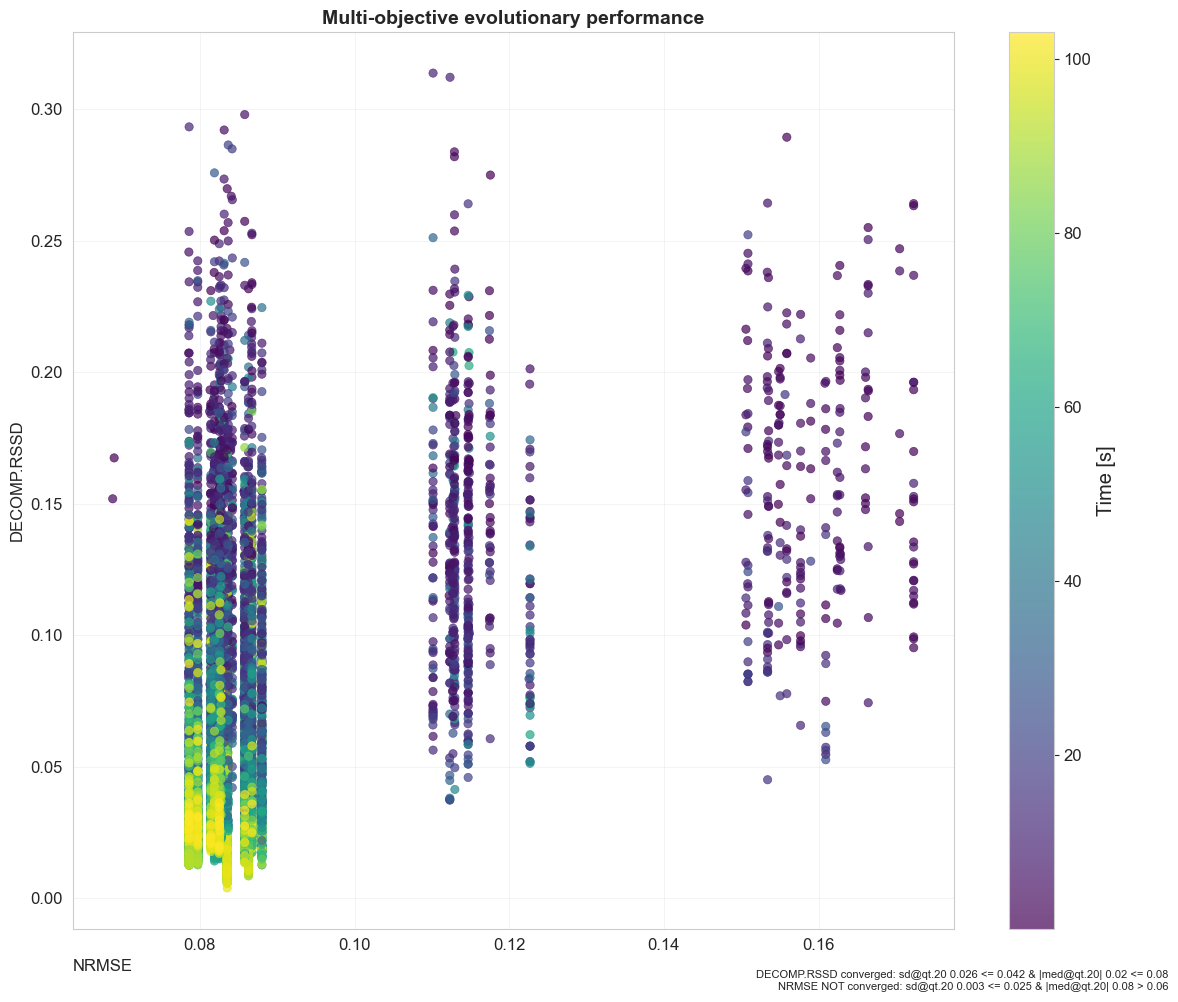

In [13]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(
    iterations=2000, trials=5
)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on x cores..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=16,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

In [14]:
from robyn.tutorials.utils.data_mapper import load_data_from_json, import_input_collect, import_output_models
%load_ext autoreload
%autoreload 2

# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/test_Pareto_50_iterations_1_trial_InputCollect.json"
)
raw_output_models = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/test_Pareto_50_iterations_1_trial_OutputModels.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_models = import_output_models(raw_output_models)

# Extract individual components
r_mmm_data = r_input_collect["mmm_data"]
r_featurized_mmm_data = r_input_collect["featurized_mmm_data"]
r_holidays_data = r_input_collect["holidays_data"]
r_hyperparameters = r_input_collect["hyperparameters"]

Python window calculation (start):
window_start: 2016-01-04 00:00:00
closest_start_date: 2016-01-04 00:00:00
closest_start_idx: 6
days_diff first few values: [-42. -35. -28. -21. -14.]
Python window calculation (end):
window_end: 2018-12-31 00:00:00
closest_end_date: 2018-12-31 00:00:00
closest_end_idx: 162
days_diff first few values: [-1134. -1127. -1120. -1113. -1106.]
Window length: 157
Raw hyperparameters data: {'facebook_S_alphas': [0.5, 3], 'facebook_S_gammas': [0.3, 1], 'facebook_S_thetas': [0, 0.3], 'print_S_alphas': [0.5, 3], 'print_S_gammas': [0.3, 1], 'print_S_thetas': [0.1, 0.4], 'tv_S_alphas': [0.5, 3], 'tv_S_gammas': [0.3, 1], 'tv_S_thetas': [0.3, 0.8], 'search_S_alphas': [0.5, 3], 'search_S_gammas': [0.3, 1], 'search_S_thetas': [0, 0.3], 'ooh_S_alphas': [0.5, 3], 'ooh_S_gammas': [0.3, 1], 'ooh_S_thetas': [0.1, 0.4], 'newsletter_alphas': [0.5, 3], 'newsletter_gammas': [0.3, 1], 'newsletter_thetas': [0.1, 0.4], 'train_size': [0.5, 0.8]}
Debug: R output data keys: ['trial1'

In [15]:
print("R Rolling window start:", r_mmm_data.mmmdata_spec.rolling_window_start_which)
print("R Rolling window end:", r_mmm_data.mmmdata_spec.rolling_window_end_which)
print("R Rolling window length:", r_mmm_data.mmmdata_spec.rolling_window_length)

R Rolling window start: 6
R Rolling window end: 162
R Rolling window length: 157


In [16]:
# new anytree

from anytree import Node, RenderTree
from dataclasses import is_dataclass, asdict
import pandas as pd


def build_tree(data, parent_key="", limit_trials=True):
    """
    Recursively build a tree structure from a dictionary, list, or dataclass.

    Args:
        data: The data structure (dict, list, or dataclass) to traverse.
        parent_key: The base key path for nested keys.
        limit_trials: Whether to limit the output to the first trial.

    Returns:
        A tree node representing the structure of the data.
    """
    if is_dataclass(data):
        data = asdict(data)  # Convert dataclass to dictionary

    if isinstance(data, dict):
        node = Node(f"{parent_key} (Dict)")
        for key, value in data.items():
            full_key = f"{parent_key}.{key}" if parent_key else key
            child_node = build_tree(value, full_key, limit_trials)
            child_node.parent = node
        return node
    elif isinstance(data, list):
        node = Node(f"{parent_key} (List)")
        for index, item in enumerate(data):
            if limit_trials and parent_key == "trials" and index > 0:
                break
            full_key = f"{parent_key}[{index}]"
            child_node = build_tree(item, full_key, limit_trials)
            child_node.parent = node
        return node
    elif isinstance(data, pd.DataFrame):
        node = Node(f"{parent_key} (DataFrame)")
        for column in data.columns:
            dtype = data[column].dtype
            column_node = Node(f"{parent_key}.{column} (dtype: {dtype})")
            column_node.parent = node
        return node
    else:
        dtype = type(data).__name__
        return Node(f"{parent_key} (dtype: {dtype})")


# Assuming output_models and r_output_models are instances of ModelOutputs
python_tree = build_tree(output_models)
r_tree = build_tree(r_output_models)

# Visualize the trees
print("Python ModelOutputs Structure:")
for pre, fill, node in RenderTree(python_tree):
    print(f"{pre}{node.name}")

print("\nR ModelOutputs Structure:")
for pre, fill, node in RenderTree(r_tree):
    print(f"{pre}{node.name}")

Python ModelOutputs Structure:
 (Dict)
├── trials (List)
│   └── trials[0] (Dict)
│       ├── trials[0].result_hyp_param (DataFrame)
│       │   ├── trials[0].result_hyp_param.facebook_S_thetas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.facebook_S_alphas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.facebook_S_gammas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.print_S_thetas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.print_S_alphas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.print_S_gammas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.tv_S_thetas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.tv_S_alphas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.tv_S_gammas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.search_S_thetas (dtype: float64)
│       │   ├── trials[0].result_hyp_param.search_S_alphas (dtype: float64)
│       │   ├── trials[0].result_hyp_par

In [17]:
# from anytree import Node, RenderTree
# from anytree.exporter import DotExporter
# from dataclasses import is_dataclass, asdict
# import pandas as pd


# def build_tree(data, parent_key="", limit_trials=True):
#     """
#     Recursively build a tree structure from a dictionary, list, or dataclass.

#     Args:
#         data: The data structure (dict, list, or dataclass) to traverse.
#         parent_key: The base key path for nested keys.
#         limit_trials: Whether to limit the output to the first trial.

#     Returns:
#         A tree node representing the structure of the data.
#     """
#     if is_dataclass(data):
#         data = asdict(data)  # Convert dataclass to dictionary

#     if isinstance(data, dict):
#         node = Node(parent_key)
#         for key, value in data.items():
#             full_key = f"{parent_key}.{key}" if parent_key else key
#             child_node = build_tree(value, full_key, limit_trials)
#             child_node.parent = node
#         return node
#     elif isinstance(data, list):
#         node = Node(parent_key)
#         for index, item in enumerate(data):
#             if limit_trials and parent_key == "trials" and index > 0:
#                 break
#             full_key = f"{parent_key}[{index}]"
#             child_node = build_tree(item, full_key, limit_trials)
#             child_node.parent = node
#         return node
#     elif isinstance(data, pd.DataFrame):
#         node = Node(f"{parent_key} (DataFrame: {data.shape})")
#         for column in data.columns:
#             column_node = Node(f"{parent_key}.{column}")
#             column_node.parent = node
#         return node
#     else:
#         return Node(parent_key)


# # Assuming output_models and r_output_models are instances of ModelOutputs
# python_tree = build_tree(output_models)
# r_tree = build_tree(r_output_models)

# # Visualize the trees
# print("Python ModelOutputs Structure:")
# for pre, fill, node in RenderTree(python_tree):
#     print(f"{pre}{node.name}")

# print("\nR ModelOutputs Structure:")
# for pre, fill, node in RenderTree(r_tree):
#     print(f"{pre}{node.name}")

In [18]:
import pandas as pd
import numpy as np
from typing import Dict, Any


def compare_model_values(py_output, r_output):
    """Compare key values between Python and R model outputs"""

    print("1. Basic Model Configuration Comparison:")
    basic_attrs = [
        "train_timestamp",
        "cores",
        "iterations",
        "intercept",
        "intercept_sign",
        "nevergrad_algo",
        "ts_validation",
        "add_penalty_factor",
    ]

    # Add debug prints
    print("\nDebugging attribute types:")
    for attr in basic_attrs:
        py_val = getattr(py_output, attr, None)
        r_val = getattr(r_output, attr, None)
        print(f"{attr:20s} - Python type: {type(py_val)} | R type: {type(r_val)}")
        print(f"{attr:20s} - Python value: {py_val} | R value: {r_val}")
        print("-" * 50)

    print("\n2. Trial Results Comparison (Descriptive Statistics):")
    if py_output.trials and r_output.trials:
        metrics = [
            "nrmse",
            "decomp_rssd",
            "mape",
            "rsq_train",
            "rsq_val",
            "rsq_test",
            "lambda_",
            "lambda_hp",
            "lambda_max",
            "lambda_min_ratio",
        ]
        # Convert trial results to DataFrames
        py_trials_df = pd.DataFrame(
            [
                {metric: getattr(trial, metric, np.nan) for metric in metrics}
                for trial in py_output.trials
            ]
        )

        # Aggregate R trial metrics
        r_trials_df = pd.DataFrame(
            [
                {
                    metric: getattr(trial, metric, pd.Series([np.nan])).mean()
                    for metric in metrics
                }
                for trial in r_output.trials
            ]
        )
        # Ensure R trial data is numeric
        r_trials_df = r_trials_df.apply(pd.to_numeric, errors="coerce")
        # Calculate descriptive statistics
        py_desc = py_trials_df.describe()
        r_desc = r_trials_df.describe()
        # Print descriptive statistics
        print("\nPython Trial Descriptive Statistics:")
        print(py_desc)
        print("\nR Trial Descriptive Statistics:")
        print(r_desc)
        # Calculate and print differences
        diff_desc = py_desc - r_desc
        print("\nDifference in Descriptive Statistics:")
        print(diff_desc)

    print("\n3. Hyperparameter Comparison:")
    if hasattr(py_output, "hyper_updated") and hasattr(r_output, "hyper_updated"):
        py_hyper = py_output.hyper_updated
        r_hyper = r_output.hyper_updated

        # Find all unique keys
        all_keys = set(py_hyper.keys()) | set(r_hyper.keys())

        print("\nHyperparameter Values:")
        print(f"{'Parameter':30s} {'Python':>15s} {'R':>15s} {'Diff':>15s}")
        print("-" * 75)

        for key in sorted(all_keys):
            py_val = py_hyper.get(key, "N/A")
            r_val = r_hyper.get(key, "N/A")

            if isinstance(py_val, (int, float)) and isinstance(r_val, (int, float)):
                diff = abs(py_val - r_val)
                print(f"{key:30s} {py_val:15.6f} {r_val:15.6f} {diff:15.6f}")
            else:
                print(f"{key:30s} {str(py_val):15s} {str(r_val):15s} {'N/A':>15s}")

    print("\n4. Data Shape Comparison:")
    data_attrs = ["all_result_hyp_param", "all_x_decomp_agg", "all_decomp_spend_dist"]

    for attr in data_attrs:
        py_shape = getattr(py_output, attr).shape if hasattr(py_output, attr) else None
        r_shape = getattr(r_output, attr).shape if hasattr(r_output, attr) else None
        print(f"{attr:20s} - Python shape: {py_shape} | R shape: {r_shape}")

    print("\n5. Total Effect and Effect Share Comparison:")
    if py_output.trials and r_output.trials:
        for i, (py_trial, r_trial) in enumerate(zip(py_output.trials, r_output.trials)):
            print(f"\nTrial {i+1}:")
            # Extract decomp_spend_dist DataFrames
            py_decomp_spend_dist = getattr(
                py_trial, "decomp_spend_dist", pd.DataFrame()
            )
            r_decomp_spend_dist = getattr(r_trial, "decomp_spend_dist", pd.DataFrame())
            # Check if the DataFrames are not empty
            if not py_decomp_spend_dist.empty and not r_decomp_spend_dist.empty:
                # Compare total effect
                py_total_effect = py_decomp_spend_dist.get(
                    "xDecompAgg", pd.Series([np.nan])
                ).sum()
                r_total_effect = r_decomp_spend_dist.get(
                    "xDecompAgg", pd.Series([np.nan])
                ).sum()
                total_effect_diff = abs(py_total_effect - r_total_effect)
                print(
                    f"Total Effect - Python: {py_total_effect:.6f}, R: {r_total_effect:.6f}, Diff: {total_effect_diff:.6f}"
                )
                # Compare effect share
                py_effect_share = py_decomp_spend_dist.get(
                    "effect_share", pd.Series([np.nan])
                ).sum()
                r_effect_share = r_decomp_spend_dist.get(
                    "effect_share", pd.Series([np.nan])
                ).sum()
                effect_share_diff = abs(py_effect_share - r_effect_share)
                print(
                    f"Effect Share - Python: {py_effect_share:.6f}, R: {r_effect_share:.6f}, Diff: {effect_share_diff:.6f}"
                )
            else:
                print(
                    "Decomposition spend distribution data is missing for this trial."
                )


# Run the comparison
print("Starting detailed value comparison...\n")
compare_model_values(output_models, r_output_models)

Starting detailed value comparison...

1. Basic Model Configuration Comparison:

Debugging attribute types:
train_timestamp      - Python type: <class 'str'> | R type: <class 'str'>
train_timestamp      - Python value: 2024-12-04 13:19:21 | R value: 2024-11-29 20:22:31
--------------------------------------------------
cores                - Python type: <class 'int'> | R type: <class 'int'>
cores                - Python value: 10 | R value: 9
--------------------------------------------------
iterations           - Python type: <class 'int'> | R type: <class 'int'>
iterations           - Python value: 2000 | R value: 50
--------------------------------------------------
intercept            - Python type: <class 'bool'> | R type: <class 'bool'>
intercept            - Python value: True | R value: True
--------------------------------------------------
intercept_sign       - Python type: <class 'str'> | R type: <class 'str'>
intercept_sign       - Python value: non_negative | R value: 

/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_1878/3835541963.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  py_desc = py_trials_df.describe()
/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_1878/3835541963.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  py_desc = py_trials_df.describe()
/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_1878/3835541963.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  py_desc = py_trials_df.describe()
/var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/ipykernel_1878/3835541963.py:65: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  py_des

In [19]:
# Assuming r_output_models is an instance of ModelOutputs
convergence_data = r_output_models.convergence

# Accessing attributes of ConvergenceData
moo_distrb_plot = convergence_data.moo_distrb_plot
moo_cloud_plot = convergence_data.moo_cloud_plot
errors = convergence_data.errors
conv_msg = convergence_data.conv_msg

# Example: Print the convergence messages
print("Convergence Messages:", conv_msg)

Convergence Messages: ['DECOMP.RSSD NOT converged: sd@qt.20 0.033 > 0.021 & |med@qt.20| 0.73 > 0.68', 'NRMSE NOT converged: sd@qt.20 0.12 > 0.085 & |med@qt.20| 0.25 > 0.14']


In [20]:
from PIL import Image
import io
import binascii
from typing import Optional

# Assuming convergence_data is an instance of ConvergenceData
# and contains hexadecimal strings of image data


def display_image(data: Optional[str]):
    if data:
        # If data is a list, join it into a single string
        if isinstance(data, list):
            data = "".join(data)

        # Convert hexadecimal string to binary data
        binary_data = binascii.unhexlify(data)

        # Open the image using PIL
        image = Image.open(io.BytesIO(binary_data))

        # Display the image
        image.show()
    else:
        print("No image data available.")


# print("moo distrb plot:", type(moo_distrb_plot))
# print("first 10 elements in moo distrb plot:", moo_distrb_plot[0:10])
# print("moo cloud plot:", type(moo_cloud_plot))
# Assuming convergence_data is an instance of ConvergenceData
# Display the moo_distrb_plot
# display_image(convergence_data.moo_distrb_plot)
# # Display the moo_cloud_plot
# display_image(convergence_data.moo_cloud_plot)

In [21]:
# # Function to print model output summary
# def print_model_output_summary(model_name, model):
#     print(f"\n{model_name} Model Output Summary:")
#     print(f"Number of trials: {len(model.trials)}")
#     print(
#         f"Average models per trial: {len(model.all_result_hyp_param) / len(model.trials)}"
#     )
#     print(f"Total unique models: {len(model.all_result_hyp_param['sol_id'].unique())}")

#     print("\nMetrics Distribution:")
#     metrics_df = model.all_result_hyp_param[["nrmse", "decomp.rssd", "mape"]]
#     print(metrics_df.describe())

#     # Additional validation to debug model output
#     print("\nColumns in result_hyp_param:")
#     print(model.all_result_hyp_param.columns.tolist())

#     print("\nSample rows of metrics:")
#     print(model.all_result_hyp_param[["sol_id", "nrmse", "decomp.rssd", "mape"]].head())

#     # Show shape of result dataframes
#     print("\nDataFrame Shapes:")
#     print(f"result_hyp_param: {model.all_result_hyp_param.shape}")
#     print(f"x_decomp_agg: {model.all_x_decomp_agg.shape}")
#     print(f"decomp_spend_dist: {model.all_decomp_spend_dist.shape}")


# # Print summaries for both output_models and r_output_models
# print_model_output_summary("Python Output Models", output_models)
# print_model_output_summary("R Output Models", r_output_models)

In [22]:
# def print_data_structure(data):
#     print("Columns:", data.columns.tolist())
#     print("\nFirst row:", data.iloc[0].to_dict())
#     print("\nShape:", data.shape)


# # Assuming you want to print the structure for the first trial
# first_trial_r = r_output_models.trials[0].decomp_spend_dist
# first_trial_python = output_models.trials[0].decomp_spend_dist

# print("R exported data structure:")
# print_data_structure(first_trial_r)

# # With Python calculated data
# print("\nPython calculated data structure:")
# print_data_structure(first_trial_python)